# Task A

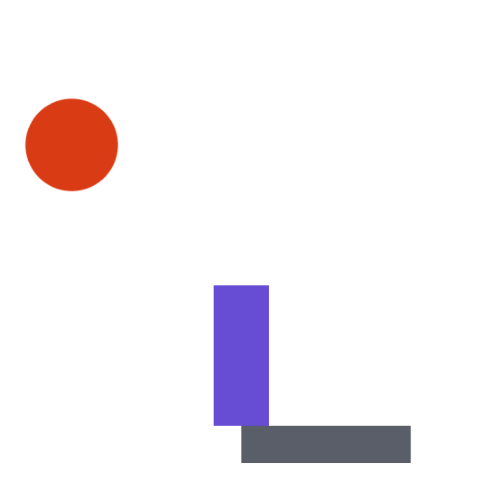

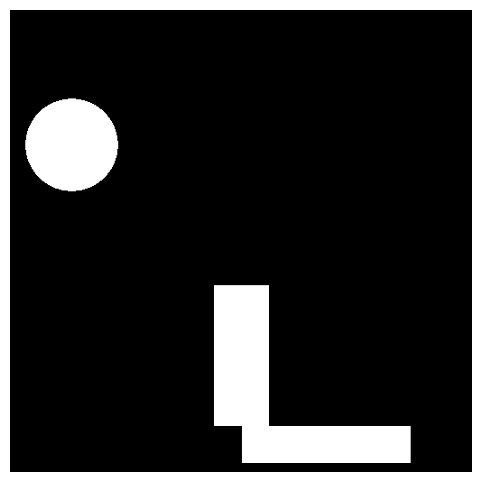

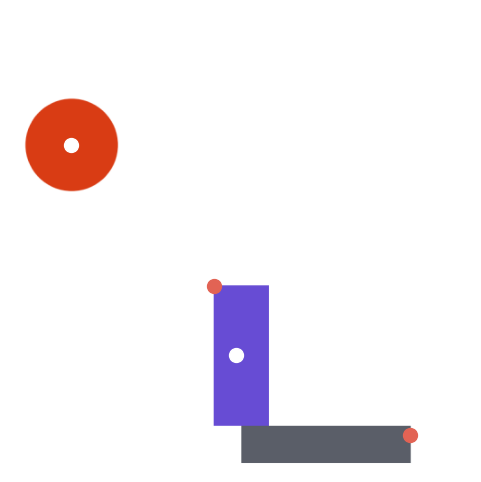

Saved Original Image at: /cpfs04/user/hanyujin/causal-dm/synthetic/synthetic_data_eight/example/original_image.pdf
Saved Masked Image at: /cpfs04/user/hanyujin/causal-dm/synthetic/synthetic_data_eight/example/masked_image.pdf
Saved Keypoints Image at: /cpfs04/user/hanyujin/causal-dm/synthetic/synthetic_data_eight/example/keypoints_image.pdf


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import re
from matplotlib import font_manager as fm
comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")
def calculate_center_and_end(mask, pole_center, is_pole=False):
    # 检查掩码是否为空
    if np.sum(mask) == 0:
        return (0, 0), (0, 0), (0, 0)
    
    # 使用霍夫变换检测直线
    lines = cv2.HoughLinesP(mask, 1, np.pi/180, threshold=30, minLineLength=mask.shape[0]/4, maxLineGap=20)
    
    if lines is not None:
        longest_line = max(lines, key=lambda x: np.sqrt((x[0][0]-x[0][2])**2 + (x[0][1]-x[0][3])**2))
        x1, y1, x2, y2 = longest_line[0]
        
        # 确保 x1 < x2 (对于影子) 或 y1 < y2 (对于旗杆)
        if (is_pole and y1 > y2) or (not is_pole and x1 > x2):
            x1, y1, x2, y2 = x2, y2, x1, y1
        
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # 对于旗杆，返回底端作为end_point
        if is_pole:
            return (center_x, center_y), (x1, y1), (x2, y2)
        # 对于影子，返回离旗杆最远的点作为end_point
        else:
            dist1 = np.sqrt((x1 - pole_center[0])**2 + (y1 - pole_center[1])**2)
            dist2 = np.sqrt((x2 - pole_center[0])**2 + (y2 - pole_center[1])**2)
            end_point = (x2, y2) if dist2 > dist1 else (x1, y1)
            other_end = (x1, y1) if dist2 > dist1 else (x2, y2)
            return (center_x, center_y), end_point, other_end
    
    # 如果霍夫变换失败，退回到轮廓方法
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        cnt = max(contours, key=cv2.contourArea)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
        else:
            center_x, center_y = 0, 0
        
        # 找到最远和最近的点
        dist = np.sqrt((cnt[:,:,0] - pole_center[0])**2 + (cnt[:,:,1] - pole_center[1])**2)
        far_index = np.argmax(dist)
        near_index = np.argmin(dist)
        far_point = tuple(cnt[far_index][0])
        near_point = tuple(cnt[near_index][0])
        
        return (center_x, center_y), far_point, near_point
    
    return (0, 0), (0, 0), (0, 0)

def analyze_single_image(image_path, target_size=256):
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        return "fail", None, "Image could not be read"

    # 调整图像大小为 target_size x target_size
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # 转换为RGB（用于显示）和HSV颜色空间
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 获取颜色值
    def get_dominant_color(mask):
        masked_img = cv2.bitwise_and(hsv, hsv, mask=mask)
        hist = cv2.calcHist([masked_img], [0, 1, 2], mask, [180, 256, 256], [0, 180, 0, 256, 0, 256])
        dominant_color = np.unravel_index(np.argmax(hist), hist.shape)
        return dominant_color

    # 定义颜色范围
    # sun_hsv_range = [(0, 60), (50, 255), (200, 255)]  # 扩大黄色和橙色范围
    # pole_hsv_range = [(90, 150), (50, 255), (50, 255)]  # 保持蓝绿色系，但扩大范围
    # shadow_hsv_range = [(0, 180), (0, 150), (0, 220)]  # 进一步扩大阴影的范围，包括更多灰色调

    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]
    shadow_hsv_range = [(0, 180), (0, 150), (50, 150)] 
    
    
    sun_lower = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])
    sun_upper = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

    pole_lower = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])
    pole_upper = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

    shadow_lower = np.array([shadow_hsv_range[0][0], shadow_hsv_range[1][0], shadow_hsv_range[2][0]])
    shadow_upper = np.array([shadow_hsv_range[0][1], shadow_hsv_range[1][1], shadow_hsv_range[2][1]])

    # 创建掩码
    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    # 获取颜色值
    sun_color = get_dominant_color(sun_mask)
    pole_color = get_dominant_color(pole_mask)
    shadow_color = get_dominant_color(shadow_mask)

    # 计算中心和末端
    (pole_cx, pole_cy), (pole_bottom_x, pole_bottom_y), (pole_top_x, pole_top_y) = calculate_center_and_end(pole_mask, (0, 0), is_pole=True)
    (sun_cx, sun_cy), _, _ = calculate_center_and_end(sun_mask, (pole_cx, pole_cy))
    (shadow_cx, shadow_cy), (shadow_end_x, shadow_end_y), (shadow_start_x, shadow_start_y) = calculate_center_and_end(shadow_mask, (pole_cx, pole_cy))

    # 检查是否有任何物体没有被检测到
    if (sun_cx, sun_cy) == (0, 0) or (pole_cx, pole_cy) == (0, 0) or (shadow_cx, shadow_cy) == (0, 0):
        return "fail", None, "One or more objects not detected"

    # 计算旗杆中心到地面的距离和影子到地面的距离
    pole_center_to_ground = pole_bottom_y - pole_cy
    shadow_to_ground = pole_bottom_y - shadow_cy

    # 检查旗杆中心到地面的距离是否小于等于影子到地面的距离
    if pole_center_to_ground <= shadow_to_ground:
        return "fail", None, "Pole center is not higher than shadow"

    # 确定方向、距离和真实性
    direction = 'l' if sun_cx < target_size/2 else 'r'
    distance_to_center = abs(sun_cx - target_size/2)
    near_distance = (0.00 * target_size, 0.25 * target_size)  # 近距离范围：图像大小的5%到25%
    far_distance = (0.25 * target_size, 0.5 * target_size)  # 远距离范围：图像大小的30%到50%
    if near_distance[0] <= distance_to_center <= near_distance[1]:
         distance = 'n' 
    elif far_distance[0] < distance_to_center <= far_distance[1]:
        distance = 'f'
    else:
        distance = 'unknown'
    
    # 根据影子尾端和太阳中心相对于杆子的位置判断真实性
    if (sun_cx < pole_cx and shadow_end_x > pole_cx) or (sun_cx > pole_cx and shadow_end_x < pole_cx):
        real = 'd'
    else:
        real = 's'

    return "success", (direction, distance, real), f"Sun center: ({sun_cx}, {sun_cy}), Shadow end: ({shadow_end_x}, {shadow_end_y}), Pole center: ({pole_cx}, {pole_cy}), Distance to center: {distance_to_center:.2f}"


def display_images(image_path, target_size=256):
    status, result, details = analyze_single_image(image_path, target_size=target_size)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]
    shadow_hsv_range = [(0, 180), (0, 150), (50, 150)]

    sun_lower = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])
    sun_upper = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

    pole_lower = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])
    pole_upper = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

    shadow_lower = np.array([shadow_hsv_range[0][0], shadow_hsv_range[1][0], shadow_hsv_range[2][0]])
    shadow_upper = np.array([shadow_hsv_range[0][1], shadow_hsv_range[1][1], shadow_hsv_range[2][1]])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    combined_mask = cv2.bitwise_or(cv2.bitwise_or(sun_mask, pole_mask), shadow_mask)

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    # plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Display the masked image
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_mask, cmap="gray")
    # plt.title("Masked Image")
    plt.axis("off")
    plt.show()

    print("Analysis Status:", status)
    print("Result:", result)
    print("Details:", details)


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

def save_images_with_keypoints(image_path, output_dir, target_size=256):
    status, result, details = analyze_single_image(image_path, target_size=target_size)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]
    shadow_hsv_range = [(0, 180), (0, 150), (50, 150)]

    sun_lower = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])
    sun_upper = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

    pole_lower = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])
    pole_upper = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

    shadow_lower = np.array([shadow_hsv_range[0][0], shadow_hsv_range[1][0], shadow_hsv_range[2][0]])
    shadow_upper = np.array([shadow_hsv_range[0][1], shadow_hsv_range[1][1], shadow_hsv_range[2][1]])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    combined_mask = cv2.bitwise_or(cv2.bitwise_or(sun_mask, pole_mask), shadow_mask)

    # Compute pole top and shadow start positions
    pole_top = tuple(np.unravel_index(np.argmax(pole_mask, axis=None), pole_mask.shape)[::-1])
    # shadow_start = tuple(np.unravel_index(np.argmin(shadow_mask, axis=None), shadow_mask.shape)[::-1])
    pole_bottom = tuple(np.unravel_index(np.argmin(pole_mask, axis=None), pole_mask.shape)[::-1])
    sun_cx, sun_cy = map(int, re.findall(r"Sun center: \((\d+), (\d+)\)", details)[0])
    shadow_end_x, shadow_end_y = map(int, re.findall(r"Shadow end: \((\d+), (\d+)\)", details)[0])
    pole_cx, pole_cy = map(int, re.findall(r"Pole center: \((\d+), (\d+)\)", details)[0])

    # Plot and save Original Image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    original_path = os.path.join(output_dir, "original_image.pdf")
    plt.savefig(original_path, format="pdf")
    plt.show()
    plt.close()

    # Plot and save Masked Image
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_mask, cmap="gray")
    plt.axis("off")
    masked_path = os.path.join(output_dir, "masked_image.pdf")
    plt.savefig(masked_path, format="pdf")
    plt.show()
    plt.close()

    # Plot and save Keypoints Image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.scatter(sun_cx, sun_cy, c='white', s=100)
    plt.scatter(pole_cx, pole_cy, c='white', s=100)
    plt.scatter(shadow_end_x, shadow_end_y, c='#E26354', s=100,label="Shadow End")
    plt.scatter(pole_top[0], pole_top[1], c='#E26354', s=100,label="Pole Top")
    # plt.legend(loc="upper left")
    plt.axis("off")
    keypoints_path = os.path.join(output_dir, "keypoints_image.pdf")
    plt.savefig(keypoints_path, format="pdf")
    plt.show()
    plt.close()

    print(f"Saved Original Image at: {original_path}")
    print(f"Saved Masked Image at: {masked_path}")
    print(f"Saved Keypoints Image at: {keypoints_path}")


# Example usage
output_dir = "/cpfs04/user/hanyujin/causal-dm/example"
os.makedirs(output_dir, exist_ok=True)

image_dir = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images"
image_files = ["/cpfs04/user/hanyujin/causal-dm/synthetic/synthetic_data_eight/l_f_d/41.png"]#[f for f in os.listdir(image_dir) if f.endswith(".png")] #[f for f in os.listdir(image_dir) if f.endswith(".png")] #["/cpfs04/user/hanyujin/causal-dm/synthetic/synthetic_data_eight/l_f_d/41.png"]#[f for f in os.listdir(image_dir) if f.endswith(".png")]

# Process and save a single random image
random_image = os.path.join(image_dir, random.choice(image_files))
save_images_with_keypoints(random_image, output_dir, target_size=512)



/root/miniconda3/envs/yjenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


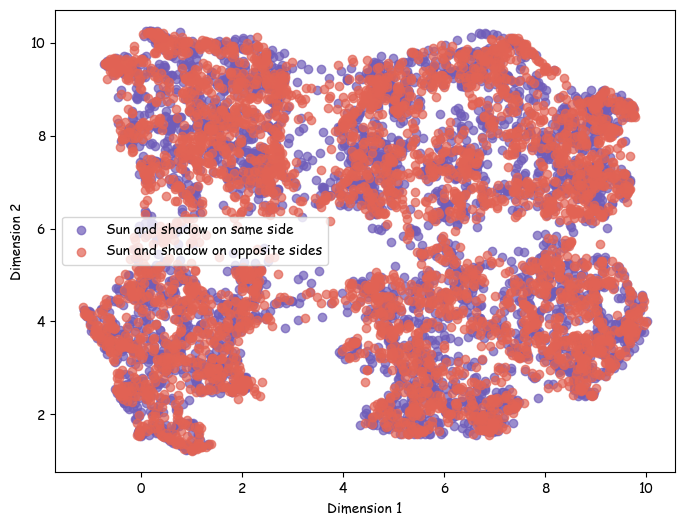

In [32]:
import os
import torch
from clip import clip
import numpy as np
import matplotlib.pyplot as plt
import umap
from PIL import Image
from matplotlib import font_manager as fm

comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")

# Set device to CUDA if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and preprocess function
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to load images from subfolders and apply CLIP preprocessing
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    if not os.path.exists(folder_path):
        print(f"Warning: Folder {folder_path} does not exist.")
        return images, labels
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path).convert("RGB")
            image = preprocess(image).unsqueeze(0).to(device)  # Apply CLIP preprocessing
            images.append(image)
            labels.append(label)
    return images, labels

# Define the main directory
main_dir = "/cpfs04/user/hanyujin/causal-dm/synthetic/synthetic_data_eight"

# Define lists to hold image data and labels
all_images = []
all_labels = []

# Loop through the subfolders that end with 's' or 'd' and assign corresponding labels
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    if os.path.isdir(folder_path):
        # Check if the folder name ends with 's' or 'd'
        if folder_name.endswith("s"):
            # Label for sun and shadow on the same side
            images, labels = load_images_from_folder(folder_path, 0)
        elif folder_name.endswith("d"):
            # Label for sun and shadow on opposite sides
            images, labels = load_images_from_folder(folder_path, 1)
        else:
            continue  # Skip folders that don't end with 's' or 'd'

        # Append images and labels
        all_images.extend(images)
        all_labels.extend(labels)

# Extract features using CLIP
features = []
for image in all_images:
    with torch.no_grad():
        feature = model.encode_image(image)
        features.append(feature.cpu().numpy().flatten())  # Flatten the feature vector

features = np.array(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_features = umap_model.fit_transform(features)

# Create a scatter plot of the reduced features
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[np.array(all_labels) == 0, 0], reduced_features[np.array(all_labels) == 0, 1], 
            c="#6f5db9", label="Sun and shadow on same side", alpha=0.7)
plt.scatter(reduced_features[np.array(all_labels) == 1, 0], reduced_features[np.array(all_labels) == 1, 1], 
            c="#E26354", label="Sun and shadow on opposite sides", alpha=0.7)

# Set labels and legend
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()

# Save the plot as PDF
output_path = "/cpfs04/user/hanyujin/causal-dm/example/taska_two_side.pdf"
plt.savefig(output_path, format="pdf")
plt.show()


In [ ]:
plt.figure(figsize=(f, 6))
plt.scatter(reduced_features[np.array(all_labels) == 0, 0], reduced_features[np.array(all_labels) == 0, 1], 
            c="#6f5db9", label="Sun and shadow on same side", alpha=0.7)
plt.scatter(reduced_features[np.array(all_labels) == 1, 0], reduced_features[np.array(all_labels) == 1, 1], 
            c="#E26354", label="Sun and shadow on opposite sides", alpha=0.7)

# Set labels and legend
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(fontsize=15)

# Save the plot as PDF
output_path = "/cpfs04/user/hanyujin/causal-dm/example/taska_two_side.pdf"
plt.savefig(output_path, format="pdf")
plt.show()

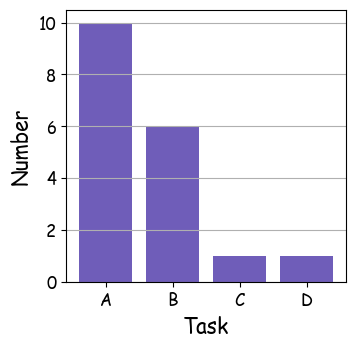

Figure saved as /cpfs04/user/hanyujin/causal-dm/example/highquality_gen.pdf


In [91]:
import numpy as np
import matplotlib.pyplot as plt

# 数据：任务标签及对应的规则符合生成样本数量
tasks = ["A", "B", "C", "D"]
counts = [10, 6, 1, 1]  # 对应的样本数量
ratios = [count / sum(counts) for count in counts]  # 计算占比

# 绘制柱状图
plt.figure(figsize=(4, 4))
color = "#6f5db9"  # 统一的颜色
plt.bar(tasks, counts, color=color, alpha=1)

# 添加标题和标签
plt.ylabel('Number', fontsize=15)
plt.xlabel('Task', fontsize=15)

# 调整x轴和y轴标签字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 调整坐标轴和标签之间的距离
plt.subplots_adjust(bottom=0.2, left=0.2)

# 显示网格
plt.grid(True, axis='y')

# 保存图形为PDF
output_pdf_path = '/cpfs04/user/hanyujin/causal-dm/example/highquality_gen.pdf'
plt.savefig(output_pdf_path, format='pdf')

# 显示图形
plt.show()

print(f"Figure saved as {output_pdf_path}")


## Training Vis

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import font_manager as fm
comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
# if os.path.exists(comic_sans_path):
#     fm.fontManager.addfont(comic_sans_path)
#     plt.rcParams['font.family'] = 'Comic Sans MS'
# else:
#     print("Comic Sans MS font not found. Using default font.")
# colors = ['#568CA9' if diff >= 0 else '#E26354' for diff in diff_values]
def analyze_image(image_path, target_size=128):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 使用提供的颜色范围
    sun_lower = np.array([0, 100, 200])
    sun_upper = np.array([30, 255, 255])
    pole_lower = np.array([90, 100, 100])
    pole_upper = np.array([150, 255, 255])
    shadow_lower = np.array([0, 0, 50])
    shadow_upper = np.array([180, 50, 150])
    # sun_lower = np.array([0, 50, 200])
    # sun_upper = np.array([60, 255, 255])
    # pole_lower = np.array([90, 50, 50])
    # pole_upper = np.array([150, 255, 255])
    # shadow_lower = np.array([0, 0, 0])
    # shadow_upper = np.array([180, 150, 220])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not sun_contours or not shadow_contours or not pole_contours:
        return None

    try:
        sun_contour = max(sun_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(pole_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(shadow_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx) # l1
        s2 = abs(sun_cy - pole_top[1]) # h1
        l2 = abs(pole_bottom[1] - pole_top[1]) # h2
        l1 = abs(shadow_right[0] - shadow_left[0]) # l2

        if l2 == 0 or s2 == 0:
            return None  # 跳过分母为0的情况

        return s1*l2/(target_size)**2, s2*l1/(target_size)**2
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None


# def analyze_image(image_path, target_size=128):
#     img = cv2.imread(image_path)
#     if img is None:
#         return None
    
#     img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     sun_lower = np.array([0, 50, 200])
#     sun_upper = np.array([60, 255, 255])
#     pole_lower = np.array([90, 50, 50])
#     pole_upper = np.array([150, 255, 255])
#     shadow_lower = np.array([0, 0, 0])
#     shadow_upper = np.array([180, 150, 220])
#     # sun_lower = np.array([0, 100, 200])
#     # sun_upper = np.array([30, 255, 255])
#     # pole_lower = np.array([90, 100, 100])
#     # pole_upper = np.array([150, 255, 255])
#     # shadow_lower = np.array([0, 0, 50])
#     # shadow_upper = np.array([180, 50, 150])

#     sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
#     pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
#     shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

#     sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if not sun_contours or not shadow_contours or not pole_contours:
#         return None

#     try:
#         sun_contour = max(sun_contours, key=cv2.contourArea)
#         sun_moments = cv2.moments(sun_contour)
#         sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
#         sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

#         pole_contour = max(pole_contours, key=cv2.contourArea)
#         pole_moments = cv2.moments(pole_contour)
#         pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
#         pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
#         pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
#         pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

#         shadow_contour = max(shadow_contours, key=cv2.contourArea)
#         shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
#         shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

#         s1 = abs(sun_cx - pole_cx) # l1
#         s2 = abs(sun_cy - pole_top[1]) #h1

#         # 确定阴影尾部
#         if pole_top[0] == pole_bottom[0] or abs(pole_bottom[0] - pole_top[0]) <= target_size * 0.01:
#             shadow_tail = shadow_right if abs(shadow_right[0]-pole_top[0] ) > abs(shadow_left[0]-pole_top[0] ) else shadow_left
#         else:
#             distances = [
#                     (abs(shadow_left[0] - pole_top[0]), shadow_left),
#                     (abs(shadow_right[0] - pole_top[0]), shadow_right),
#                     (abs(pole_bottom[0] - pole_top[0]), pole_bottom)
#             ]
#             _, shadow_tail = max(distances, key=lambda x: x[0])

            


#         # 计算 l1 和 l2
#         l1 = abs(shadow_tail[0] - pole_top[0]) # l2
#         # l2 = abs(pole_cx - shadow_tail[1]) # h2
#         l2 = abs(pole_top[0] - shadow_tail[1])
#         # print(l1,l2)
#         if l2 == 0 or s2 == 0:
#             return None

#         # 在图像上标记s1, s2, l1, l2
#         cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 255, 0), 2)  # s1
#         cv2.line(img, (sun_cx, sun_cy), (sun_cx, pole_top[1]), (255, 0, 0), 2)  # s2
#         cv2.line(img, (pole_top[0], shadow_tail[1]), (shadow_tail[0], shadow_tail[1]), (0, 0, 255), 2)  # l1
#         cv2.line(img, (pole_top[0], pole_top[1]), (pole_top[0], shadow_tail[1]), (255, 255, 0), 2)  # l2

#         # 添加文本标签
#         cv2.putText(img, 's1', (pole_cx, sun_cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
#         cv2.putText(img, 's2', (sun_cx + 5, (sun_cy + pole_top[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
#         cv2.putText(img, 'l1', ((pole_top[0] + shadow_tail[0]) // 2, shadow_tail[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
#         cv2.putText(img, 'l2', (pole_top[0] + 5, (pole_top[1] + shadow_tail[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

#         return s1*l2/(target_size)**2, s2*l1/(target_size)**2
#     except Exception as e:
#         print(f"Error processing image {image_path}: {str(e)}")
#         return None


# def calculate_center_and_end(mask, pole_center, is_pole=False):
#     # 检查掩码是否为空
#     if np.sum(mask) == 0:
#         return (0, 0), (0, 0), (0, 0)
    
#     # 使用霍夫变换检测直线
#     lines = cv2.HoughLinesP(mask, 1, np.pi/180, threshold=30, minLineLength=mask.shape[0]/4, maxLineGap=20)
    
#     if lines is not None:
#         longest_line = max(lines, key=lambda x: np.sqrt((x[0][0]-x[0][2])**2 + (x[0][1]-x[0][3])**2))
#         x1, y1, x2, y2 = longest_line[0]
        
#         # 确保 x1 < x2 (对于影子) 或 y1 < y2 (对于旗杆)
#         if (is_pole and y1 > y2) or (not is_pole and x1 > x2):
#             x1, y1, x2, y2 = x2, y2, x1, y1
        
#         center_x = (x1 + x2) // 2
#         center_y = (y1 + y2) // 2
        
#         # 对于旗杆，返回底端作为end_point
#         if is_pole:
#             return (center_x, center_y), (x1, y1), (x2, y2)
#         # 对于影子，返回离旗杆最远的点作为end_point
#         else:
#             dist1 = np.sqrt((x1 - pole_center[0])**2 + (y1 - pole_center[1])**2)
#             dist2 = np.sqrt((x2 - pole_center[0])**2 + (y2 - pole_center[1])**2)
#             end_point = (x2, y2) if dist2 > dist1 else (x1, y1)
#             other_end = (x1, y1) if dist2 > dist1 else (x2, y2)
#             return (center_x, center_y), end_point, other_end
    
#     # 如果霍夫变换失败，退回到轮廓方法
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if len(contours) > 0:
#         cnt = max(contours, key=cv2.contourArea)
#         M = cv2.moments(cnt)
#         if M["m00"] != 0:
#             center_x = int(M["m10"] / M["m00"])
#             center_y = int(M["m01"] / M["m00"])
#         else:
#             center_x, center_y = 0, 0
        
#         # 找到最远和最近的点
#         dist = np.sqrt((cnt[:,:,0] - pole_center[0])**2 + (cnt[:,:,1] - pole_center[1])**2)
#         far_index = np.argmax(dist)
#         near_index = np.argmin(dist)
#         far_point = tuple(cnt[far_index][0])
#         near_point = tuple(cnt[near_index][0])
        
#         return (center_x, center_y), far_point, near_point
    
#     return (0, 0), (0, 0), (0, 0)

# def analyze_image(image_path, target_size=256):
#     # 读取图像
#     img = cv2.imread(image_path)
#     if img is None:
#         return "fail", None, "Image could not be read"

# #     # 调整图像大小为 target_size x target_size
#     img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

#     # 转换为RGB（用于显示）和HSV颜色空间
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     # 获取颜色值
#     def get_dominant_color(mask):
#         masked_img = cv2.bitwise_and(hsv, hsv, mask=mask)
#         hist = cv2.calcHist([masked_img], [0, 1, 2], mask, [180, 256, 256], [0, 180, 0, 256, 0, 256])
#         dominant_color = np.unravel_index(np.argmax(hist), hist.shape)
#         return dominant_color

#     # 定义颜色范围
#     sun_hsv_range = [(0, 30), (100, 255), (200, 255)]
#     pole_hsv_range = [(90, 150), (100, 255), (100, 255)]
#     shadow_hsv_range = [(0, 180), (0, 150), (50, 150)] 
#     sun_lower = np.array([0, 100, 200])
#     sun_upper = np.array([30, 255, 255])
# #     pole_lower = np.array([90, 100, 100])
# #     pole_upper = np.array([150, 255, 255])
# #     shadow_lower = np.array([0, 0, 50])
# #     shadow_upper = np.array([180, 50, 150])
    
#     sun_lower = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])
#     sun_upper = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

#     pole_lower = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])
#     pole_upper = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

#     shadow_lower = np.array([shadow_hsv_range[0][0], shadow_hsv_range[1][0], shadow_hsv_range[2][0]])
#     shadow_upper = np.array([shadow_hsv_range[0][1], shadow_hsv_range[1][1], shadow_hsv_range[2][1]])

#     # 创建掩码
#     sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
#     pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
#     shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

#     # 获取颜色值
#     sun_color = get_dominant_color(sun_mask)
#     pole_color = get_dominant_color(pole_mask)
#     shadow_color = get_dominant_color(shadow_mask)

#     # 计算中心和末端
#     pole_top_x,pole_top_y = tuple(np.unravel_index(np.argmax(pole_mask, axis=None), pole_mask.shape)[::-1])
#     # pole_cx, pole_cy = map(int, re.findall(r"Pole center: \((\d+), (\d+)\)", details)[0])
#     (pole_cx, pole_cy), (pole_bottom_x, pole_bottom_y), (_, _) = calculate_center_and_end(pole_mask, (0, 0), is_pole=True)
#     (sun_cx, sun_cy), _, _ = calculate_center_and_end(sun_mask, (pole_cx, pole_cy))
#     (shadow_cx, shadow_cy), (shadow_end_x, shadow_end_y), (shadow_start_x, shadow_start_y) = calculate_center_and_end(shadow_mask, (pole_cx, pole_cy))

#     # 检查是否有任何物体没有被检测到
#     if (sun_cx, sun_cy) == (0, 0) or (pole_cx, pole_cy) == (0, 0) or (shadow_cx, shadow_cy) == (0, 0):
#         return "fail", None, "One or more objects not detected"

#     # 计算旗杆中心到地面的距离和影子到地面的距离
#     pole_center_to_ground = pole_bottom_y - pole_cy
#     shadow_to_ground = pole_bottom_y - shadow_cy

#     # 检查旗杆中心到地面的距离是否小于等于影子到地面的距离
#     if pole_center_to_ground <= shadow_to_ground:
#         return "fail", None, "Pole center is not higher than shadow"

#     # 计算 s1, s2, l1, l2
#     s1 = abs(sun_cx - pole_cx)  # Horizontal distance between sun and pole center
#     s2 = abs(sun_cy - pole_top_y)  # Vertical distance between sun center and pole top
#     l2 = 2 * abs(pole_top_y - pole_cy)  # Vertical shadow height (2x vertical distance from pole top to pole center)
#     l1 = abs(shadow_end_x - pole_cx)  # Horizontal shadow length (from shadow tail to pole center)

#     # Annotating image with lines for each parameter
#     cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 255, 0), 2)  # s1
#     cv2.line(img, (pole_cx, sun_cy), (pole_cx, pole_top_y), (255, 0, 0), 2)  # s2
#     cv2.line(img, (shadow_end_x, shadow_end_y), (pole_cx, shadow_end_y), (0, 0, 255), 2)  # l1
#     cv2.line(img, (pole_cx, shadow_end_y), (pole_cx, pole_top_y), (255, 255, 0), 2)  # l2

#     return s1*l2/(target_size)**2, s2*l1/(target_size)**2






def process_folder(folder_path,target_size):
    txt_files = glob.glob(os.path.join(folder_path, "('*', '*', 'd')_files.txt"))
    data = defaultdict(list)

    if txt_files:
        for txt_file in txt_files:
            category = os.path.basename(txt_file).split('_')[0]
            with open(txt_file, 'r') as f:
                image_ids = [line.strip() for line in f.readlines()]
            
            for image_id in image_ids:
                image_path = os.path.join(folder_path, image_id)
                result = analyze_image(image_path,target_size=target_size)
                if result:
                    data[category].append((result, image_path))
    else:
        # 如果没有txt文件，处理文件夹中所有的png图像
        image_files = glob.glob(os.path.join(folder_path, "*.png"))
        for image_path in image_files:
            result = analyze_image(image_path)
            if result:
                data["all_images"].append((result, image_path))

    return data


# 使用示例
base_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd"
folder_path = base_path + "/images"
output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/example", "taska_physical_law.pdf")
data = process_folder(folder_path,target_size=128)
# plot_scatter(data, output_pdf_path)

In [12]:
all_points = []
colors = ['#5762b8']
for (category, points), color in zip(data.items(), colors):
    # 提取有效点
    valid_points = [p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
    if valid_points:
        all_points.extend(valid_points)
count = 0
for x, y in all_points:
    # 确定x所在区间的索引（0~9）
    idx = int(x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1

# 计算占比
percentage = count / len(all_points)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：90.35%


/tmp/ipykernel_3319445/3317257097.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.2], [0, 0.2], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)


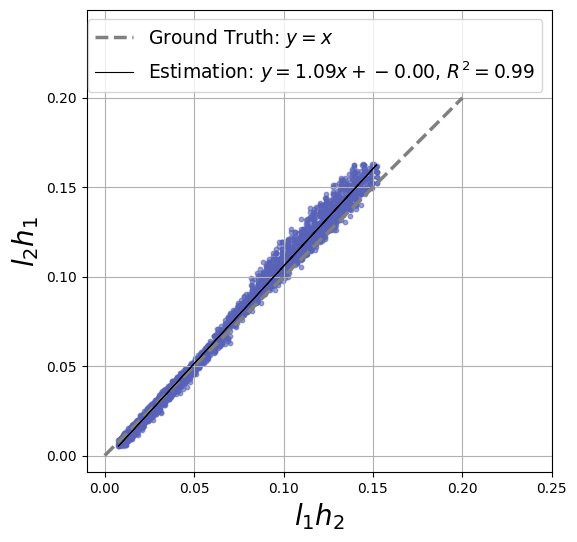

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages

def plot_scatter(data, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        colors = ['#5762b8']
        all_points = []
        
        for (category, points), color in zip(data.items(), colors):
            # 提取有效点
            valid_points = [p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
            if valid_points:
                all_points.extend(valid_points)
        
        # 转换为NumPy数组
        all_points = np.array(all_points)
        if all_points.size == 0:
            raise ValueError("No valid points found to plot.")
        
        # 计算2.5到97.5百分位范围
        x = all_points[:, 0]
        y = all_points[:, 1]
        x_min, x_max = np.percentile(x, [5, 95])
        y_min, y_max = np.percentile(y, [5, 95])
        mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
        
        # 过滤点以供绘图
        x_filtered = x[mask]
        y_filtered = y[mask]

        # 绘制筛选后的散点图
        plt.scatter(x_filtered, y_filtered, c=colors[0], alpha=0.6, s=10)
        
        # 绘制参考线
        plt.plot([0, 0.2], [0, 0.2], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)
        plt.xlabel(r'$l_1h_2$', fontsize=20)
        plt.ylabel(r'$l_2h_1$', fontsize=20)
        plt.grid(True)
        plt.axis('equal')
        plt.xlim(-0.01, 0.25)
        plt.ylim(-0.01, 0.25)

        # 拟合直线并计算R^2
        x_all = x_filtered.reshape(-1, 1)
        y_all = y_filtered
        lin_reg = LinearRegression()
        lin_reg.fit(x_all, y_all)
        y_pred = lin_reg.predict(x_all)
        r2 = r2_score(y_all, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        # 绘制拟合直线
        plt.plot(x_all, y_pred, color='black', linewidth=0.8, label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        plt.legend(fontsize=13.5)
        pdf.savefig()  # 保存当前图像到PDF
        plt.show()
        plt.close()

output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/ar_ddpm", "task1.pdf")
plot_scatter(data, output_pdf_path)

## Genvis

In [231]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tqdm import tqdm
import re

def calculate_center_and_end(mask, pole_center, is_pole=False):
    # 检查掩码是否为空
    if np.sum(mask) == 0:
        return (0, 0), (0, 0), (0, 0)
    
    # 使用霍夫变换检测直线
    lines = cv2.HoughLinesP(mask, 1, np.pi/180, threshold=30, minLineLength=mask.shape[0]/4, maxLineGap=20)
    
    if lines is not None:
        longest_line = max(lines, key=lambda x: np.sqrt((x[0][0]-x[0][2])**2 + (x[0][1]-x[0][3])**2))
        x1, y1, x2, y2 = longest_line[0]
        
        # 确保 x1 < x2 (对于影子) 或 y1 < y2 (对于旗杆)
        if (is_pole and y1 > y2) or (not is_pole and x1 > x2):
            x1, y1, x2, y2 = x2, y2, x1, y1
        
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # 对于旗杆，返回底端作为end_point
        if is_pole:
            return (center_x, center_y), (x1, y1), (x2, y2)
        # 对于影子，返回离旗杆最远的点作为end_point
        else:
            dist1 = np.sqrt((x1 - pole_center[0])**2 + (y1 - pole_center[1])**2)
            dist2 = np.sqrt((x2 - pole_center[0])**2 + (y2 - pole_center[1])**2)
            end_point = (x2, y2) if dist2 > dist1 else (x1, y1)
            other_end = (x1, y1) if dist2 > dist1 else (x2, y2)
            return (center_x, center_y), end_point, other_end
    
    # 如果霍夫变换失败，退回到轮廓方法
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        cnt = max(contours, key=cv2.contourArea)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
        else:
            center_x, center_y = 0, 0
        
        # 找到最远和最近的点
        dist = np.sqrt((cnt[:,:,0] - pole_center[0])**2 + (cnt[:,:,1] - pole_center[1])**2)
        far_index = np.argmax(dist)
        near_index = np.argmin(dist)
        far_point = tuple(cnt[far_index][0])
        near_point = tuple(cnt[near_index][0])
        
        return (center_x, center_y), far_point, near_point
    
    return (0, 0), (0, 0), (0, 0)




def analyze_single_image(image_path, target_size):
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        return "fail", None, "Image could not be read"

    # 调整图像大小为 target_size x target_size
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # 转换为RGB（用于显示）和HSV颜色空间
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 获取颜色值
    def get_dominant_color(mask):
        masked_img = cv2.bitwise_and(hsv, hsv, mask=mask)
        hist = cv2.calcHist([masked_img], [0, 1, 2], mask, [180, 256, 256], [0, 180, 0, 256, 0, 256])
        dominant_color = np.unravel_index(np.argmax(hist), hist.shape)
        return dominant_color

    # 定义颜色范围
    # sun_hsv_range = [(0, 60), (50, 255), (200, 255)]  # 扩大黄色和橙色范围
    # pole_hsv_range = [(90, 150), (50, 255), (50, 255)]  # 保持蓝绿色系，但扩大范围
    # shadow_hsv_range = [(0, 180), (0, 150), (0, 220)]  # 进一步扩大阴影的范围，包括更多灰色调

    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]
    shadow_hsv_range = [(0, 180), (0, 150), (50, 150)] 
    
    
    sun_lower = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])
    sun_upper = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

    pole_lower = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])
    pole_upper = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

    shadow_lower = np.array([shadow_hsv_range[0][0], shadow_hsv_range[1][0], shadow_hsv_range[2][0]])
    shadow_upper = np.array([shadow_hsv_range[0][1], shadow_hsv_range[1][1], shadow_hsv_range[2][1]])

    # 创建掩码
    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    # 获取颜色值
    sun_color = get_dominant_color(sun_mask)
    pole_color = get_dominant_color(pole_mask)
    shadow_color = get_dominant_color(shadow_mask)

    # 计算中心和末端
    (pole_cx, pole_cy), (pole_bottom_x, pole_bottom_y), (pole_top_x, pole_top_y) = calculate_center_and_end(pole_mask, (0, 0), is_pole=True)
    (sun_cx, sun_cy), _, _ = calculate_center_and_end(sun_mask, (pole_cx, pole_cy))
    (shadow_cx, shadow_cy), (shadow_end_x, shadow_end_y), (shadow_start_x, shadow_start_y) = calculate_center_and_end(shadow_mask, (pole_cx, pole_cy))

    # 检查是否有任何物体没有被检测到
    if (sun_cx, sun_cy) == (0, 0) or (pole_cx, pole_cy) == (0, 0) or (shadow_cx, shadow_cy) == (0, 0):
        return "fail", None, "One or more objects not detected"

    # 计算旗杆中心到地面的距离和影子到地面的距离
    pole_center_to_ground = pole_bottom_y - pole_cy
    shadow_to_ground = pole_bottom_y - shadow_cy

    # 检查旗杆中心到地面的距离是否小于等于影子到地面的距离
    if pole_center_to_ground <= shadow_to_ground:
        return "fail", None, "Pole center is not higher than shadow"

    # 确定方向、距离和真实性
    direction = 'l' if sun_cx < target_size/2 else 'r'
    distance_to_center = abs(sun_cx - target_size/2)
    near_distance = (0.00 * target_size, 0.25 * target_size)  # 近距离范围：图像大小的5%到25%
    far_distance = (0.25 * target_size, 0.5 * target_size)  # 远距离范围：图像大小的30%到50%
    if near_distance[0] <= distance_to_center <= near_distance[1]:
         distance = 'n' 
    elif far_distance[0] < distance_to_center <= far_distance[1]:
        distance = 'f'
    else:
        distance = 'unknown'
    
    # 根据影子尾端和太阳中心相对于杆子的位置判断真实性
    if (sun_cx < pole_cx and shadow_end_x > pole_cx) or (sun_cx > pole_cx and shadow_end_x < pole_cx):
        real = 'd'
    else:
        real = 's'

    return "success", (direction, distance, real), f"Sun center: ({sun_cx}, {sun_cy}), Shadow end: ({shadow_end_x}, {shadow_end_y}), Pole center: ({pole_cx}, {pole_cy}), Distance to center: {distance_to_center:.2f}"



def analyze_folder(folder_path, target_size):
    results = defaultdict(list)
    total_count = 0
    fail_count = 0
    processed_files = []
    skipped_files = []

    for filename in tqdm(sorted(os.listdir(folder_path))):
        if filename.endswith(('.png', '.jpg', '.jpeg')) and re.search(r'\d+\.(?:png|jpg|jpeg)$', filename):
            total_count += 1
            image_path = os.path.join(folder_path, filename)
            status, label, details = analyze_single_image(image_path, target_size)
            
            if status == "fail":
                fail_count += 1
                results["fail"].append(filename)
                skipped_files.append((filename, details))
            else:
                results[label].append(filename)
                processed_files.append(filename)
        else:
            skipped_files.append((filename, "Does not match the expected format"))

    # 计算统计信息
    fail_rate = (fail_count-1000) / 2000# total_count if total_count > 0 else 0
    succ_count = total_count - fail_count
    label_percentages = {label: len(files) / succ_count for label, files in results.items()} if succ_count > 0 else {}

    return fail_rate, label_percentages, results, processed_files, skipped_files

# 使用示例
folder_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345"
fail_rate, label_percentages, results, processed_files, skipped_files = analyze_folder(folder_path, target_size=128)

print(f"Total files in folder: {len(os.listdir(folder_path))}")
print(f"Processed files: {len(processed_files)}")
print(f"Skipped files: {len(skipped_files)}")
print(f"Fail rate: {fail_rate:.2%}")
print("\nLabel percentages:")
for label, percentage in label_percentages.items():
    print(f"{label}: {percentage:.2%}")

print("\nNumber of images in each category:")
for label, files in results.items():
    print(f"{label}: {len(files)}")

# # 保存失败率、标签百分比和每个类别的图片数量到文本文件
with open(os.path.join(folder_path, "analysis_results.txt"), "w") as f:
    f.write(f"Fail rate: {fail_rate:.2%}\n\n")
    
    f.write("Label percentages:\n")
    for label, percentage in label_percentages.items():
        f.write(f"{label}: {percentage:.2%}\n")
    f.write("\n")
    
    f.write("Number of images in each category:\n")
    for label, files in results.items():
        f.write(f"{label}: {len(files)}\n")

# 如果需要，可以将每个类别的文件ID保存到文件中
for label, files in results.items():
    with open(os.path.join(folder_path, f"{label}_files.txt"), "w") as f:
        for file in files:
            f.write(f"{file}\n")

print(f"\nAnalysis results have been saved to {os.path.join(folder_path, 'analysis_results.txt')}")

  0%|          | 0/2995 [00:00<?, ?it/s]

  8%|▊         | 226/2995 [00:09<01:54, 24.22it/s]


KeyboardInterrupt: 

In [167]:
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cv2
import math

# 文件路径
base_path = folder_path
files_list_path = os.path.join(base_path, "('l', 'f', 's')_files.txt")

# 读取文件列表
with open(files_list_path, 'r') as file:
    files_to_delete = [line.strip() for line in file.readlines()]

# 统计有多少张不满足要求的图片
num_files_to_delete = len(files_to_delete)
print(f"Number of files to delete: {num_files_to_delete}")

# 动态生成 PDF 文件名
pdf_file_name = os.path.basename(files_list_path).replace("_files.txt", "")
pdf_path = os.path.join(base_path, f"files_to_delete_{pdf_file_name}.pdf")

# 确定行列数
if num_files_to_delete == 1:
    rows, cols = 1, 1
else:
    cols = min(6, num_files_to_delete)  # 每行最多6个
    rows = math.ceil(num_files_to_delete / cols)  # 动态计算行数

# 显示并保存这些图片
with PdfPages(pdf_path) as pdf:
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))  # 调整图像大小
    if num_files_to_delete == 1:
        axes = [axes]  # 将单个轴对象包装在列表中
    else:
        axes = axes.flatten()
    for i, file_name in enumerate(files_to_delete):
        file_path = os.path.join(base_path, file_name)
        if os.path.exists(file_path):
            img = cv2.imread(file_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax = axes[i]
            ax.imshow(img_rgb)
            ax.axis('off')
            ax.set_title(file_name)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    pdf.savefig(fig)
    plt.close(fig)

print(f"Images have been saved to {pdf_path}")


Number of files to delete: 1
Images have been saved to /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/files_to_delete_('l', 'f', 's').pdf


In [242]:
import matplotlib.pyplot as plt
import os

# Set the file path and save location
input_image_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_1108.png"
output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/example/sunshadowweight_1108.pdf"

# Load the image
img = plt.imread(input_image_path)

# Plot the image
plt.figure(figsize=(6, 6))  # 512x512 pixels roughly corresponds to 6x6 inches at 100 dpi
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.tight_layout()

# Save the image as a PDF
plt.savefig(output_pdf_path, format='pdf', dpi=100)
plt.close()


In [14]:
import os

folder_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg7_classmodel015000.pt_1737336223.8524945"
selected_image =obs
# Create full image paths
image_paths = [os.path.join(folder_path, f"{image}.png") for image in selected_image]

# Delete the images
for path in image_paths:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")
    else:
        print(f"File not found: {path}")


Deleted: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg7_classmodel015000.pt_1737336223.8524945/sunshadow_lfd_lnd_rfd_rnd_2077.png
Deleted: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg7_classmodel015000.pt_1737336223.8524945/sunshadow_lfd_lnd_rfd_rnd_2160.png
Deleted: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg7_classmodel015000.pt_1737336223.8524945/sunshadow_lfd_lnd_rfd_rnd_1399.png
Deleted: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg7_classmodel015000.pt_1737336223.8524945/sunshadow_lfd_lnd_rfd_rnd_1217.png
Deleted: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg7_classmodel015000.pt_1737336223.8524945/sunshadow_lfd_lnd_rfd_rnd_2329.png
Deleted: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400

In [10]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# 定义模型
class MLP(nn.Module):
    def __init__(self, input_size=3 * 32 * 32, num_classes=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 加载模型
model_path = "/cpfs04/user/hanyujin/causal-dm/contrastive_dp/model/MLP_100.pth"
model = MLP()
model.load_state_dict(torch.load(model_path))
model.eval()  # 设置为评估模式

# 检查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 图片预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整图片大小
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 图片目录和保存目录
image_dir = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345"
save_dir = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345_class1_100"

# 创建保存目录
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 获取所有图片文件（支持 PNG 和 JPG）
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
total_files = len(image_files)

# 遍历图片目录，并添加进度条
for filename in tqdm(image_files, desc="Processing images", unit="image"):
    try:
        # 读取图片
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')  # 确保图片是RGB格式
        image = transform(image).unsqueeze(0).to(device)  # 增加batch维度并移动到设备

        # 预测
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

        # 如果预测标签为1，保存图片
        if predicted_label == 1:
            save_path = os.path.join(save_dir, filename)
            Image.open(image_path).save(save_path)
            # print(f"Saved {filename} to {save_dir}")
    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("Prediction and saving completed.")

Processing images: 100%|██████████| 2920/2920 [04:28<00:00, 10.86image/s]

Prediction and saving completed.


In [7]:
# Enhanced
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def analyze_image(image_path, target_size=128):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    sun_lower = np.array([0, 50, 200])
    sun_upper = np.array([60, 255, 255])
    pole_lower = np.array([90, 50, 50])
    pole_upper = np.array([150, 255, 255])
    shadow_lower = np.array([0, 0, 0])
    shadow_upper = np.array([180, 150, 220])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not sun_contours or not shadow_contours or not pole_contours:
        return None

    try:
        sun_contour = max(sun_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(pole_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(shadow_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx)
        s2 = abs(sun_cy - pole_top[1])

        # 确定阴影尾部
        if pole_top[0] == pole_bottom[0] or abs(pole_bottom[0] - pole_top[0]) <= target_size * 0.01:
            shadow_tail = shadow_right if abs(shadow_right[0] - pole_top[0]) > abs(shadow_left[0] - pole_top[0]) else shadow_left
        else:
            distances = [
                    (abs(shadow_left[0] - pole_top[0]), shadow_left),
                    (abs(shadow_right[0] - pole_top[0]), shadow_right),
                    (abs(pole_bottom[0] - pole_top[0]), pole_bottom)
            ]
            _, shadow_tail = max(distances, key=lambda x: x[0])

        # 计算 l1 和 l2
        l1 = abs(shadow_tail[0] - pole_top[0])
        l2 = abs(pole_top[1] - shadow_tail[1])

        if l2 == 0 or s2 == 0:
            return None

        # 计算和比较差异
        # diff = np.abs((s1 * l2) / (target_size ** 2) - (s2 * l1) / (target_size ** 2))
        a = ((s1 * l2) / (target_size ** 2))
        b = (s2 * l1) / (target_size ** 2)

        # if (b > 0.05 ) and (a < 0.02 ) :
        if (b / a - 1 > 1 ) :
            obs = os.path.splitext(os.path.basename(image_path))[0]
            # print(f"Imag{image_path} has significant difference: {a} and {b}")
        else:
            obs = 'skip'
        # 在图像上标记s1, s2, l1, l2
        cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 255, 0), 2)  # s1
        cv2.line(img, (sun_cx, sun_cy), (sun_cx, pole_top[1]), (255, 0, 0), 2)  # s2
        cv2.line(img, (pole_top[0], shadow_tail[1]), (shadow_tail[0], shadow_tail[1]), (0, 0, 255), 2)  # l1
        cv2.line(img, (pole_top[0], pole_top[1]), (pole_top[0], shadow_tail[1]), (255, 255, 0), 2)  # l2

        # 添加文本标签
        cv2.putText(img, 's1', (pole_cx, sun_cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.putText(img, 's2', (sun_cx + 5, (sun_cy + pole_top[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, 'l1', ((pole_top[0] + shadow_tail[0]) // 2, shadow_tail[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(img, 'l2', (pole_top[0] + 5, (pole_top[1] + shadow_tail[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        return (s1 * l2) / (target_size ** 2), (s2 * l1) / (target_size ** 2), ((s2 * l1) / (s1 * l2 + 1e-4) - 1), obs
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None



def process_folder(folder_path,target_size):
    txt_files = glob.glob(os.path.join(folder_path, "('*', '*', 'd')_files.txt"))
    data = defaultdict(list)
    ratios = []
    obs = []

    if txt_files:
        for txt_file in txt_files:
            category = os.path.basename(txt_file).split('_')[0]
            with open(txt_file, 'r') as f:
                image_ids = [line.strip() for line in f.readlines()]
            
            for image_id in image_ids:
                image_path = os.path.join(folder_path, image_id)
                # print(image_path,analyze_image(image_path,target_size=target_size))
                results = analyze_image(image_path,target_size=target_size)
                if results:
                    result_1,result_2,ratio,ob = results
                    data[category].append(((result_1,result_2), image_path))
                    ratios.append(ratio)
                    obs.append(ob)
    else:
        # 如果没有txt文件，处理文件夹中所有的png图像
        image_files = glob.glob(os.path.join(folder_path, "*.png"))
        for image_path in image_files:
            results = analyze_image(image_path)
            if results:
                result_1,result_2,ratio,ob = results
                data["all_images"].append(((result_1,result_2), image_path))
                ratios.append(ratio)
                obs.append(ob)
    

    return data,ratios, list(filter(lambda x: x != "skip", obs))

# 使用示例
# folder_path ="/cpfs04/user/hanyujin/causal-dm/AR_diff/results/sunshadow_lfd_lnd_rfd_rnd_parallelFalse_reverseFalse_patch16_dim480_depth6_mlpdepth3_noweightedlossTrue_trainsteps125000_unet/generations/checkpoint.125000"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd_mlp/vis/epoch_400_1743047826.9852993"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/results/sunshadow_lfd_lnd_rfd_rnd_parallelTrue_novae/generations/checkpoint.97200"
folder_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd_unet/vis/epoch_400_1733622674.3212345"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/AR_diff/results/sunshadow_lfd_lnd_rfd_rnd_parallelFalse_reverseFalse_patch16_dim480_depth3_mlpdepth3_noweightedlossTrue_trainsteps125000/generations/checkpoint.125000"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_contrastive_ternary_cfg7/vis/epoch_400_1734924465.4797819_class1"
# "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg1000000_classmodel015000.pt_1738160476.769051_pisewise"
# "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis_contrastive/epoch_400_cfg7_classmodel015000.pt_1738132207.6682127_pisewise"
data,ratios,obs = process_folder(folder_path, target_size=128)

[ WARN:0@622.067] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd_unet/vis/epoch_400_1733622674.3212345/sunshadowweight_1184.png'): can't open/read file: check file path/integrity
[ WARN:0@622.262] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd_unet/vis/epoch_400_1733622674.3212345/sunshadowweight_1485.png'): can't open/read file: check file path/integrity
[ WARN:0@622.379] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd_unet/vis/epoch_400_1733622674.3212345/sunshadowweight_1846.png'): can't open/read file: check file path/integrity
[ WARN:0@622.449] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd_unet/vis/epoch_400_1733622674.3212345/sunshadowweight_2013.png'): can't open/read file: check file path/integrity
[ WARN:0@622.626] global loa

In [9]:
all_points = []
for (category, points), color in zip(data.items(), colors):
    # 提取有效点
    valid_points = [p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
    if valid_points:
        all_points.extend(valid_points)
count = 0
for x, y in all_points:
    # 确定x所在区间的索引（0~9）
    idx = int(x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1

# 计算占比
percentage = count / len(all_points)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：75.53%


/tmp/ipykernel_2295918/2568306005.py:16: RuntimeWarning: divide by zero encountered in divide
  ratio_all = np.abs(y_all / x_all)
/tmp/ipykernel_2295918/2568306005.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)


All Points: 2654
Filtered Ratios: 2122
Max Ratio: 15.924496368874774
Min Ratio: -0.7719821502262071
Bias Error: 0.554368227276747
GAP Bias Error: 0.09739297374562683
Variance Error: 0.1384828472654629
Sum Error: 0.6928510745422098
Mean Sqrt Variance Error: 0.1384828472654629


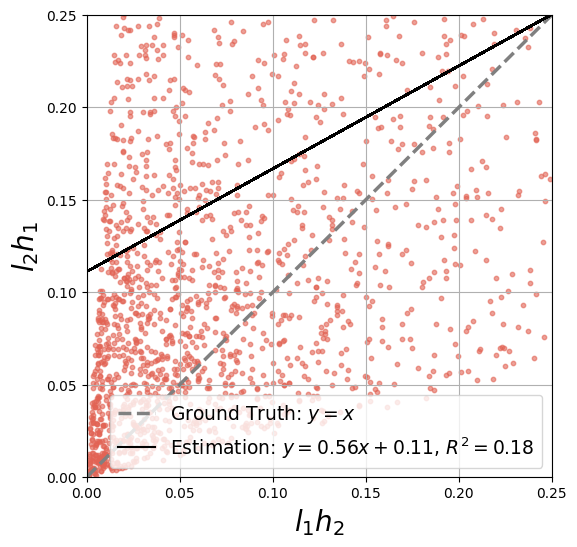

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/ar_ddpm/task1_ddpm_mlp.pdf


In [4]:
def plot_scatter(data, ratios, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 遍历所有 key 下的数值
        for points in data.values():
            all_points.extend(points)  # 合并所有点

        # 提取所有点的 x 和 y 坐标
        x_all = np.array([p[0][0] for p in all_points]) 
        y_all = np.array([p[0][1] for p in all_points]) 
        
        # 计算每个点的 |y/x| 比率
        ratio_all = np.abs(y_all / x_all)

        # 计算 |y/x| 的 2.5% 和 97.5% 百分位数
        ratio_low, ratio_high = np.percentile(ratio_all, [10, 90])

        # 筛选出 |y/x| 在 2.5% 和 97.5% 百分位数区间内的点
        mask = (ratio_low <= ratio_all) & (ratio_all <= ratio_high)
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered ,y_filtered , c=color, alpha=0.6, s=10)

        # 打印比率的统计信息

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_
        plt.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)
        print("All Points:", len(all_points))
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        print(f"Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"GAP Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)-np.sqrt((slope-1)**2+intercept**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2))+np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2))))}")
        

        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局
        plt.xlabel(r'$l_1h_2$', fontsize=20)
        plt.ylabel(r'$l_2h_1$', fontsize=20)
        plt.grid(True)
        plt.legend(fontsize=13.5)
        # plt.tight_layout()
        plt.xlim(0,0.25)
        plt.ylim(0,0.25)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages

# output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/example", "taska_rule_gen_contrastive_class1.pdf")
output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/ar_ddpm", "task1_ddpm_mlp.pdf")
plot_scatter(data, ratios, output_pdf_path)


In [5]:
import os
import shutil
import random

def sample_and_copy_images(source_root, target_root, sample_size=1000):
    """
    从源目录的每个子文件夹随机采样指定数量图片，保持结构复制到目标目录
    :param source_root: 源数据根目录（包含多个子文件夹）
    :param target_root: 目标根目录（将自动创建相同子文件夹结构）
    :param sample_size: 每个子文件夹采样的数量
    """
    # 获取所有子文件夹名称
    subdirs = [d for d in os.listdir(source_root) 
               if os.path.isdir(os.path.join(source_root, d))]
    
    for subdir in subdirs:
        src_dir = os.path.join(source_root, subdir)
        dst_dir = os.path.join(target_root, subdir)
        os.makedirs(dst_dir, exist_ok=True)  # 创建目标子文件夹
        
        # 获取所有图像文件
        all_images = [f for f in os.listdir(src_dir) 
                      if os.path.isfile(os.path.join(src_dir, f))]
        
        # 随机采样（如果文件不足则全取）
        sampled_images = random.sample(all_images, min(sample_size, len(all_images)))
        
        # 复制文件（关键修改点：shutil.copy 替代 shutil.move）
        for img in sampled_images:
            src_path = os.path.join(src_dir, img)
            dst_path = os.path.join(dst_dir, img)
            shutil.copy(src_path, dst_path)  # 仅复制文件
        
        print(f"Copied {len(sampled_images)} images from {subdir}")

if __name__ == "__main__":
    source_dir = "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist"
    target_dir = "/cpfs04/user/hanyujin/rule-gen/datasets/cifar-mnist-sample"
    sample_and_copy_images(source_dir, target_dir)

/tmp/ipykernel_892108/1209304371.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)


All Points: 2901
Filtered Ratios: 2663
Max Ratio: 8.047613662134724
Min Ratio: -0.758909870097144
Bias Error: 0.16949837832634357
GAP Bias Error: 0.005587749541193093
Variance Error: 0.014335322875382469
Sum Error: 0.18383370120172604
Mean Sqrt Variance Error: 0.014335322875382469


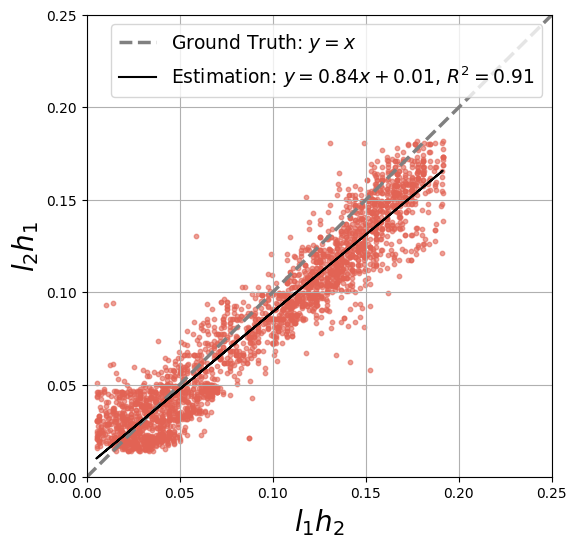

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/ar_ddpm/task1_ar.pdf


In [2]:
def plot_scatter(data, ratios, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 遍历所有 key 下的数值
        for points in data.values():
            all_points.extend(points)  # 合并所有点

        # 提取所有点的 x 和 y 坐标
        x_all = np.array([p[0][0] for p in all_points]) 
        y_all = np.array([p[0][1] for p in all_points]) 
        
        # 绘制所有点的散点图
       

        # 绘制参考线
        plt.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)
        plt.xlabel(r'$l_1h_2$', fontsize=20)
        plt.ylabel(r'$l_2h_1$', fontsize=20)
        plt.grid(True)
        # plt.axis('equal')

        # 计算 x 和 y 的 2.5% 和 97.5% 百分位数
        x_low, x_high = np.percentile(x_all, [2.5, 97.5])
        y_low, y_high = np.percentile(y_all, [2.5, 97.5])

        # 筛选在 95% 区间内的点
        mask = (x_low <= x_all) & (x_all <= x_high) & (y_low <= y_all) & (y_all <= y_high) & ~((0.10 < x_all) & (y_all < 0.05)) & ~((0.05 > x_all) & (y_all > 0.1)) &~((0.20 < x_all) & (y_all < 0.10))
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered ,y_filtered , c=color, alpha=0.6, s=10)

        # 打印比率的统计信息

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        print("All Points:", len(all_points))
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        print(f"Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"GAP Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)-np.sqrt((slope-1)**2+intercept**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2))+np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2))))}")
        

        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局
        plt.legend(fontsize=13.5)
        # plt.tight_layout()
        plt.xlim(0,0.25)
        plt.ylim(0,0.25)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages

# output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/example", "taska_rule_gen_contrastive_class1.pdf")
output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/ar_ddpm", "task1_ar.pdf")
plot_scatter(data, ratios, output_pdf_path)

## All epochs

In [17]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from matplotlib import font_manager as fm
comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")
base_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/"
folder_paths = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if folder.startswith('epoch_')]

# 输出 PDF 的保存路径
output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/example/taska_rule_all.pdf"

# 定义指定的 epoch 顺序
specified_epochs = [200, 400, 600, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3400, 4000]

# 从文件夹名称中提取 epoch 值，并按指定顺序排序
folder_paths_sorted = []
for epoch in specified_epochs:
    for folder_path in folder_paths:
        # 使用正则表达式提取 epoch 值
        match = re.search(r'epoch_(\d+)', folder_path)
        if match:
            folder_epoch = int(match.group(1))
            if folder_epoch == epoch:
                folder_paths_sorted.append(folder_path)
                break


# 初始化一个 PdfPages 对象，用于保存多个图表
with PdfPages(output_pdf_path) as pdf:
    # 创建一个大图
    fig, axes = plt.subplots(3, 4, figsize=(18, 12))  # 创建 3 行 4 列的子图
    axes = axes.flatten()  # 将子图列表展平，方便遍历

    # 依次处理每个文件夹
    for idx, folder_path in enumerate(folder_paths_sorted):
        epoch = specified_epochs[idx]  # 获取当前 epoch 的值
        print(f"Processing folder for Epoch {epoch}: {folder_path}")

        # 获取数据和比率
        data, ratios = process_folder(folder_path, target_size=128)

        # 当前子图位置
        ax = axes[idx]

        # 获取所有点
        all_points = []
        for points in data.values():
            all_points.extend(points)

        # 提取所有点的 x 和 y 坐标
        x_all = np.array([p[0][0] for p in all_points])
        y_all = np.array([p[0][1] for p in all_points])

        # 绘制散点图
  

        # 绘制参考线
        ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)
        ax.set_xlabel(r'$l_1h_2$', fontsize=12)
        ax.set_ylabel(r'$l_2h_1$', fontsize=12)
        ax.grid(True)

        # 计算 x 和 y 的 2.5% 和 97.5% 百分位数
        x_low, x_high = np.percentile(x_all, [2.5, 97.5])
        y_low, y_high = np.percentile(y_all, [2.5, 97.5])

        # 筛选在 95% 区间内的点
        mask = (x_low <= x_all) & (x_all <= x_high) & (y_low <= y_all) & (y_all <= y_high) & ~((0.10 < x_all) & (y_all < 0.05))
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]



        # 绘制过滤后的散点图
        ax.scatter(x_filtered, y_filtered, c='#E26354', alpha=0.6, s=10)

        # 使用线性回归拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        # 绘制拟合直线
        ax.plot(x_filtered, y_pred, color='black', label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 添加标题
        ax.set_title(f'Epoch {epoch}', fontsize=14)

        # 设置坐标轴范围
        ax.set_xlim(0, 0.25)
        ax.set_ylim(0, 0.25)

        # 添加图例
        ax.legend(fontsize=10)

    # 调整布局，避免图像重叠
    plt.tight_layout()

    # 将所有图表保存到 PDF
    pdf.savefig(fig)
    plt.close()

    print(f"Task completed. All plots saved in {output_pdf_path}")


Processing folder for Epoch 200: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_200_1733621054.0880237


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 400: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345


[ WARN:0@841.223] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_1184.png'): can't open/read file: check file path/integrity
[ WARN:0@841.295] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_1485.png'): can't open/read file: check file path/integrity
[ WARN:0@841.388] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_1846.png'): can't open/read file: check file path/integrity
[ WARN:0@841.429] global loadsave.cpp:241 findDecoder imread_('/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_2013.png'): can't open/read file: check file path/integrity
[ WARN:0@841.494] global loadsave.cpp:241 findDe

Processing folder for Epoch 600: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_600_1733624620.1235526


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 800: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_800_1733628335.9468262


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 1200: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_1200_1733744721.618166


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 1600: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_1600_1733745682.1908133


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 2000: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_2000_1733746635.6527812


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 2400: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_2400_1733747589.8990858


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 2800: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_2800_1733748543.4819417


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 3200: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_3200_1733749498.3538318


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 3400: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_3400_1733823137.8267617


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Processing folder for Epoch 4000: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_4000_1733751408.6393044


/tmp/ipykernel_3276760/3229813094.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


Task completed. All plots saved in /cpfs04/user/hanyujin/causal-dm/example/taska_rule_all.pdf


In [14]:
folder_paths

['/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_2000_1733746635.6527812',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_2400_1733747589.8990858',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_3400_1733823137.8267617',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_800_1733628335.9468262',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_3800_1733824092.4734702',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_1800_1733819313.364056',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_3000_1733822181.730333',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_600_1733624620.1235526',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_1200_1733744721.618166',
 '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/v

## Gen_vis case

In [138]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import font_manager as fm
comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")
# colors = ['#568CA9' if diff >= 0 else '#E26354' for diff in diff_values]
def analyze_image(image_path, target_size=128):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 使用提供的颜色范围
    sun_lower = np.array([0, 100, 200])
    sun_upper = np.array([30, 255, 255])
    pole_lower = np.array([90, 100, 100])
    pole_upper = np.array([150, 255, 255])
    shadow_lower = np.array([0, 0, 50])
    shadow_upper = np.array([180, 50, 150])
    # sun_lower = np.array([0, 50, 200])
    # sun_upper = np.array([60, 255, 255])
    # pole_lower = np.array([90, 50, 50])
    # pole_upper = np.array([150, 255, 255])
    # shadow_lower = np.array([0, 0, 0])
    # shadow_upper = np.array([180, 150, 220])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not sun_contours or not shadow_contours or not pole_contours:
        return None

    try:
        sun_contour = max(sun_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(pole_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(shadow_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx) # l1
        s2 = abs(sun_cy - pole_top[1]) # h1
        l2 = abs(pole_bottom[1] - pole_top[1]) # h2
        l1 = abs(shadow_right[0] - shadow_left[0]) # l2

        if l2 == 0 or s2 == 0:
            return None  # 跳过分母为0的情况

        return s1*l2/(target_size)**2, s2*l1/(target_size)**2
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None





def process_folder(folder_path,target_size):
    txt_files = glob.glob(os.path.join(folder_path, "('*', '*', 'd')_files.txt"))
    data = defaultdict(list)

    if txt_files:
        for txt_file in txt_files:
            category = os.path.basename(txt_file).split('_')[0]
            with open(txt_file, 'r') as f:
                image_ids = [line.strip() for line in f.readlines()]
            
            for image_id in image_ids:
                image_path = os.path.join(folder_path, image_id)
                result = analyze_image(image_path,target_size=target_size)
                if result:
                    data[category].append((result, image_path))
    else:
        # 如果没有txt文件，处理文件夹中所有的png图像
        image_files = glob.glob(os.path.join(folder_path, "*.png"))
        for image_path in image_files:
            result = analyze_image(image_path)
            if result:
                data["all_images"].append((result, image_path))

    return data


# 使用示例
base_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd"
folder_path = base_path + "/images"
output_pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/example", "taska_physical_law.pdf")
data = process_folder(folder_path,target_size=128)
# plot_scatter(data, output_pdf_path)

In [141]:
data

defaultdict(list,
            {'all_images': [((0.1416015625, 0.1563720703125),
               '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_f_d_845.png'),
              ((0.12451171875, 0.1251220703125),
               '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_f_d_819.png'),
              ((0.0498046875, 0.04833984375),
               '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/r_n_d_796.png'),
              ((0.11322021484375, 0.1275634765625),
               '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/r_f_d_447.png'),
              ((0.1431884765625, 0.1495361328125),
               '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_f_d_588.png'),
              ((0

In [140]:
all_points = []
colors = ['#5762b8']
for (category, points), color in zip(data.items(), colors):
    # 提取有效点
    valid_points = [p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
    if valid_points:
        all_points.extend(valid_points)
all_points = np.array(all_points)
if all_points.size == 0:
    raise ValueError("No valid points found to plot.")

# 计算2.5到97.5百分位范围
x = all_points[:, 0]
y = all_points[:, 1]

In [142]:
import numpy as np
from collections import defaultdict


y = all_points[:, 1]
index_equal_1 = np.where(np.isclose(y / x, 1))[0]

# 获取对应的 image_path
image_paths = [data['all_images'][i][1] for i in index_equal_1]
print(image_paths)


['/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_f_d_665.png', '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_n_d_756.png', '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/r_n_d_102.png', '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/r_n_d_816.png', '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_n_d_202.png', '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_f_d_447.png', '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/l_n_d_597.png', '/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images/r_n_d_162.png',

/tmp/ipykernel_198031/3798795027.py:6: RuntimeWarning: invalid value encountered in divide
  index_equal_1 = np.where(np.isclose(y / x, 1))[0]


Skipping /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_1613.png due to missing annotations.
Skipping /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_2778.png due to missing annotations.
Skipping /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_1503.png due to missing annotations.
Skipping /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_1712.png due to missing annotations.
Skipping /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_2131.png due to missing annotations.
Skipping /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1733622674.3212345/sunshadowweight_411.png due to missing annotations.
Skipping /cpfs04/user/hanyujin/caus

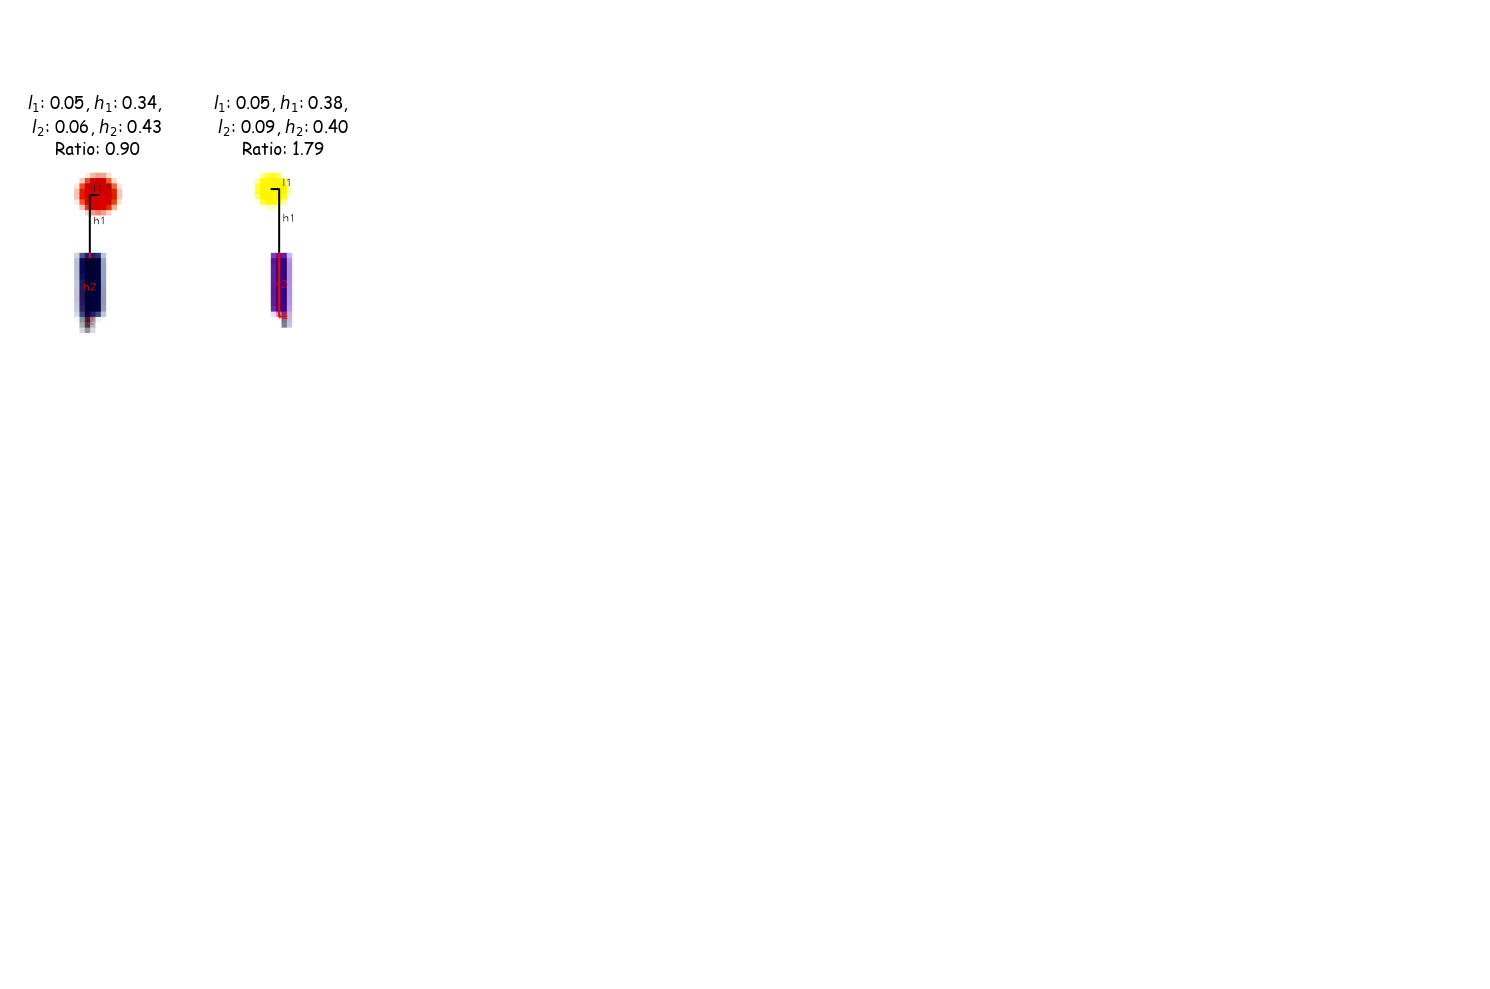

Saved annotated images to /cpfs04/user/hanyujin/causal-dm/example/taska_case_vis_gen.pdf


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
from collections import defaultdict
import re

# def calculate_center_and_end(mask, pole_center, is_pole=False):
#     # 检查掩码是否为空
#     if np.sum(mask) == 0:
#         return (0, 0), (0, 0), (0, 0)
    
#     # 使用霍夫变换检测直线
#     lines = cv2.HoughLinesP(mask, 1, np.pi/180, threshold=30, minLineLength=mask.shape[0]/4, maxLineGap=20)
    
#     if lines is not None:
#         longest_line = max(lines, key=lambda x: np.sqrt((x[0][0]-x[0][2])**2 + (x[0][1]-x[0][3])**2))
#         x1, y1, x2, y2 = longest_line[0]
        
#         # 确保 x1 < x2 (对于影子) 或 y1 < y2 (对于旗杆)
#         if (is_pole and y1 > y2) or (not is_pole and x1 > x2):
#             x1, y1, x2, y2 = x2, y2, x1, y1
        
#         center_x = (x1 + x2) // 2
#         center_y = (y1 + y2) // 2
        
#         # 对于旗杆，返回底端作为end_point
#         if is_pole:
#             return (center_x, center_y), (x1, y1), (x2, y2)
#         # 对于影子，返回离旗杆最远的点作为end_point
#         else:
#             dist1 = np.sqrt((x1 - pole_center[0])**2 + (y1 - pole_center[1])**2)
#             dist2 = np.sqrt((x2 - pole_center[0])**2 + (y2 - pole_center[1])**2)
#             end_point = (x2, y2) if dist2 > dist1 else (x1, y1)
#             other_end = (x1, y1) if dist2 > dist1 else (x2, y2)
#             return (center_x, center_y), end_point, other_end
    
#     # 如果霍夫变换失败，退回到轮廓方法
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if len(contours) > 0:
#         cnt = max(contours, key=cv2.contourArea)
#         M = cv2.moments(cnt)
#         if M["m00"] != 0:
#             center_x = int(M["m10"] / M["m00"])
#             center_y = int(M["m01"] / M["m00"])
#         else:
#             center_x, center_y = 0, 0
        
#         # 找到最远和最近的点
#         dist = np.sqrt((cnt[:,:,0] - pole_center[0])**2 + (cnt[:,:,1] - pole_center[1])**2)
#         far_index = np.argmax(dist)
#         near_index = np.argmin(dist)
#         far_point = tuple(cnt[far_index][0])
#         near_point = tuple(cnt[near_index][0])
        
#         return (center_x, center_y), far_point, near_point
    
#     return (0, 0), (0, 0), (0, 0)

# def draw_dashed_line(image, pt1, pt2, color, thickness, dash_length=5):
#     # 计算两点之间的距离
#     dist = np.linalg.norm(np.array(pt2) - np.array(pt1))
#     # 计算需要绘制的线段数
#     num_dashes = int(dist // dash_length)

#     # 计算方向向量
#     direction = np.array(pt2) - np.array(pt1)
#     direction = direction / np.linalg.norm(direction)  # 单位化方向向量

#     for i in range(num_dashes):
#         start_point = tuple((np.array(pt1) + i * dash_length * direction).astype(int))
#         end_point = tuple((np.array(pt1) + (i + 1) * dash_length * direction).astype(int))
#         cv2.line(image, start_point, end_point, color, thickness)



# def analyze_image(image_path, target_size=256):
    # 读取图像
    # img = cv2.imread(image_path)
    # if img is None:
    #     return "fail", None, "Image could not be read"

    # # 调整图像大小为 target_size x target_size
    # img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # # 转换为RGB（用于显示）和HSV颜色空间
    # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # # 获取颜色值
    # def get_dominant_color(mask):
    #     masked_img = cv2.bitwise_and(hsv, hsv, mask=mask)
    #     hist = cv2.calcHist([masked_img], [0, 1, 2], mask, [180, 256, 256], [0, 180, 0, 256, 0, 256])
    #     dominant_color = np.unravel_index(np.argmax(hist), hist.shape)
    #     return dominant_color

    # # 定义颜色范围
    # sun_hsv_range = [(0, 30), (100, 255), (200, 255)]
    # pole_hsv_range = [(90, 150), (100, 255), (100, 255)]
    # shadow_hsv_range = [(0, 180), (0, 150), (50, 150)] 
    
    # sun_lower = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])
    # sun_upper = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

    # pole_lower = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])
    # pole_upper = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

    # shadow_lower = np.array([shadow_hsv_range[0][0], shadow_hsv_range[1][0], shadow_hsv_range[2][0]])
    # shadow_upper = np.array([shadow_hsv_range[0][1], shadow_hsv_range[1][1], shadow_hsv_range[2][1]])

    # # 创建掩码
    # sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    # pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    # shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    # # 获取颜色值
    # sun_color = get_dominant_color(sun_mask)
    # pole_color = get_dominant_color(pole_mask)
    # shadow_color = get_dominant_color(shadow_mask)

    # # 计算中心和末端
    # pole_top_x,pole_top_y = tuple(np.unravel_index(np.argmax(pole_mask, axis=None), pole_mask.shape)[::-1])
    # # pole_cx, pole_cy = map(int, re.findall(r"Pole center: \((\d+), (\d+)\)", details)[0])
    # (pole_cx, pole_cy), (pole_bottom_x, pole_bottom_y), (_, _) = calculate_center_and_end(pole_mask, (0, 0), is_pole=True)
    # (sun_cx, sun_cy), _, _ = calculate_center_and_end(sun_mask, (pole_cx, pole_cy))
    # (shadow_cx, shadow_cy), (shadow_end_x, shadow_end_y), (shadow_start_x, shadow_start_y) = calculate_center_and_end(shadow_mask, (pole_cx, pole_cy))

    # 检查是否有任何物体没有被检测到
    # if (sun_cx, sun_cy) == (0, 0) or (pole_cx, pole_cy) == (0, 0) or (shadow_cx, shadow_cy) == (0, 0):
    #     return "fail", None, "One or more objects not detected"

    # # 计算旗杆中心到地面的距离和影子到地面的距离
    # pole_center_to_ground = pole_bottom_y - pole_cy
    # shadow_to_ground = pole_bottom_y - shadow_cy

    # # 检查旗杆中心到地面的距离是否小于等于影子到地面的距离
    # if pole_center_to_ground <= shadow_to_ground:
    #     return "fail", None, "Pole center is not higher than shadow"

    # # 计算 s1, s2, l1, l2
    # s1 = abs(sun_cx - pole_cx)  # Horizontal distance between sun and pole center s1-l1; s2-h1; l2-h2; l1-l2
    # s2 = abs(sun_cy - pole_top_y)  # Vertical distance between sun center and pole top s2-h1
    # l2 = 2 * abs(pole_top_y - pole_cy)  # Vertical shadow height (2x vertical distance from pole top to pole center) l2-h2
    # l1 = abs(shadow_end_x - pole_cx)  # Horizontal shadow length (from shadow tail to pole center) l1-l2

    # s1: 黑色虚线
    # draw_dashed_line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 0, 0), 2)  # s1 (黑色)

    # # s2: 黑色虚线
    # draw_dashed_line(img, (pole_cx, sun_cy), (pole_cx, pole_top_y), (0, 0, 0), 2)  # s2 (黑色)

    # # l1: 红色虚线
    # draw_dashed_line(img, (shadow_end_x, shadow_end_y), (pole_cx, shadow_end_y), (0, 0, 255), 2)  # l1 (红色)

    # # l2: 红色虚线
    # draw_dashed_line(img, (pole_cx, shadow_end_y), (pole_cx, pole_top_y), (0, 0, 255), 2)  # l2 (红色)

    # return "Succ",img, (s1/target_size, s2/target_size, l1/target_size, l2/target_size)





# def analyze_image(image_path, target_size=128):
#     img = cv2.imread(image_path)
#     if img is None:
#         return None
    
#     img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     sun_lower = np.array([0, 50, 200])
#     sun_upper = np.array([60, 255, 255])
#     pole_lower = np.array([90, 50, 50])
#     pole_upper = np.array([150, 255, 255])
#     shadow_lower = np.array([0, 0, 0])
#     shadow_upper = np.array([180, 150, 220])
#     # sun_lower = np.array([0, 100, 200])
#     # sun_upper = np.array([30, 255, 255])
#     # pole_lower = np.array([90, 100, 100])
#     # pole_upper = np.array([150, 255, 255])
#     # shadow_lower = np.array([0, 0, 50])
#     # shadow_upper = np.array([180, 50, 150])

#     sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
#     pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
#     shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

#     sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if not sun_contours or not shadow_contours or not pole_contours:
#         return "fail", None, "Pole center is not higher than shadow"

#     try:
#         sun_contour = max(sun_contours, key=cv2.contourArea)
#         sun_moments = cv2.moments(sun_contour)
#         sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
#         sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

#         pole_contour = max(pole_contours, key=cv2.contourArea)
#         pole_moments = cv2.moments(pole_contour)
#         pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
#         pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
#         pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
#         pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

#         shadow_contour = max(shadow_contours, key=cv2.contourArea)
#         shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
#         shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

#         s1 = abs(sun_cx - pole_cx) # l1
#         s2 = abs(sun_cy - pole_top[1]) #h1

#         # 确定阴影尾部
#         if pole_top[0] == pole_bottom[0] or abs(pole_bottom[0] - pole_top[0]) <= target_size * 0.01:
#             shadow_tail = shadow_right if abs(shadow_right[0]-pole_top[0] ) > abs(shadow_left[0]-pole_top[0] ) else shadow_left
#         else:
#             distances = [
#                     (abs(shadow_left[0] - pole_top[0]), shadow_left),
#                     (abs(shadow_right[0] - pole_top[0]), shadow_right),
#                     (abs(pole_bottom[0] - pole_top[0]), pole_bottom)
#             ]
#             _, shadow_tail = max(distances, key=lambda x: x[0])

            


#         # 计算 l1 和 l2
#         l1 = abs(shadow_tail[0] - pole_cx) # l2
#         l2 = abs(pole_cx - shadow_tail[1]) # h2
#         # print(l1,l2)
#         if l2 == 0 or s2 == 0:
#             return None
#         s1 = abs(sun_cx - pole_cx) # l1
#         s2 = abs(sun_cy - pole_top[1]) #h1
#         # 在图像上标记s1, s2, l1, l2
#         cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 0, 0), 2)  # l1
#         cv2.line(img, (pole_cx, sun_cy), (pole_cx, pole_top[1]), (0, 0, 0), 2)  # h1
#         cv2.line(img, (pole_cx, shadow_tail[1]), (shadow_tail[0], shadow_tail[1]), (0, 0, 255), 2)  # l2
#         cv2.line(img, (pole_cx, pole_top[1]), (pole_cx, shadow_tail[1]), (0, 0, 255), 2)  # h2

#         # 添加文本标签
#         cv2.putText(img, 'l1', (pole_cx+5, sun_cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
#         cv2.putText(img, 'h1', (pole_cx + 5, (sun_cy + pole_top[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
#         cv2.putText(img, 'l2', ((pole_top[0] + shadow_tail[0]) // 2, shadow_tail[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
#         cv2.putText(img, 'h2', (pole_top[0] + 5, (pole_top[1] + shadow_tail[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5,  (0, 0, 255), 1)

#         return "Succ",img, (s1/target_size, s2/target_size, l1/target_size, l2/target_size)
#         # return (s1*l2)/(target_size)**2, s2*l1/(target_size)**2, ((s2*l1)/(s1*l2+1e-4)-1)
#     except Exception as e:
#         print(f"Error processing image {image_path}: {str(e)}")
#         return None

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import font_manager as fm
comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")
# colors = ['#568CA9' if diff >= 0 else '#E26354' for diff in diff_values]
def analyze_image(image_path, target_size=128):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 使用提供的颜色范围
    sun_lower = np.array([0, 100, 200])
    sun_upper = np.array([30, 255, 255])
    pole_lower = np.array([90, 100, 100])
    pole_upper = np.array([150, 255, 255])
    shadow_lower = np.array([0, 0, 50])
    shadow_upper = np.array([180, 50, 150])
    # sun_lower = np.array([0, 50, 200])
    # sun_upper = np.array([60, 255, 255])
    # pole_lower = np.array([90, 50, 50])
    # pole_upper = np.array([150, 255, 255])
    # shadow_lower = np.array([0, 0, 0])
    # shadow_upper = np.array([180, 150, 220])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not sun_contours or not shadow_contours or not pole_contours:
        return None

    try:
        sun_contour = max(sun_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(pole_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(shadow_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx) # l1
        s2 = abs(sun_cy - pole_top[1]) # h1
        l2 = abs(pole_bottom[1] - pole_top[1]) # h2
        l1 = abs(shadow_right[0] - shadow_left[0]) # l2

        if l2 == 0 or s2 == 0:
            return None  # 跳过分母为0的情况

        return s1*l2/(target_size)**2, s2*l1/(target_size)**2
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None


# def analyze_image(image_path, target_size=128):
#     img = cv2.imread(image_path)
#     if img is None:
#         return None
    
#     img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     sun_lower = np.array([0, 50, 200])
#     sun_upper = np.array([60, 255, 255])
#     pole_lower = np.array([90, 50, 50])
#     pole_upper = np.array([150, 255, 255])
#     shadow_lower = np.array([0, 0, 0])
#     shadow_upper = np.array([180, 150, 220])
#     # sun_lower = np.array([0, 100, 200])
#     # sun_upper = np.array([30, 255, 255])
#     # pole_lower = np.array([90, 100, 100])
#     # pole_upper = np.array([150, 255, 255])
#     # shadow_lower = np.array([0, 0, 50])
#     # shadow_upper = np.array([180, 50, 150])

#     sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
#     pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
#     shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

#     sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if not sun_contours or not shadow_contours or not pole_contours:
#         return None

#     try:
#         sun_contour = max(sun_contours, key=cv2.contourArea)
#         sun_moments = cv2.moments(sun_contour)
#         sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
#         sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

#         pole_contour = max(pole_contours, key=cv2.contourArea)
#         pole_moments = cv2.moments(pole_contour)
#         pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
#         pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
#         pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
#         pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

#         shadow_contour = max(shadow_contours, key=cv2.contourArea)
#         shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
#         shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

#         s1 = abs(sun_cx - pole_cx) # l1
#         s2 = abs(sun_cy - pole_top[1]) #h1

#         # 确定阴影尾部
#         if pole_top[0] == pole_bottom[0] or abs(pole_bottom[0] - pole_top[0]) <= target_size * 0.01:
#             shadow_tail = shadow_right if abs(shadow_right[0]-pole_top[0] ) > abs(shadow_left[0]-pole_top[0] ) else shadow_left
#         else:
#             distances = [
#                     (abs(shadow_left[0] - pole_top[0]), shadow_left),
#                     (abs(shadow_right[0] - pole_top[0]), shadow_right),
#                     (abs(pole_bottom[0] - pole_top[0]), pole_bottom)
#             ]
#             _, shadow_tail = max(distances, key=lambda x: x[0])

            


#         # 计算 l1 和 l2
#         l1 = abs(shadow_tail[0] - pole_top[0]) # l2
#         # l2 = abs(pole_cx - shadow_tail[1]) # h2
#         l2 = abs(pole_top[0] - shadow_tail[1])
#         # print(l1,l2)
#         if l2 == 0 or s2 == 0:
#             return None

#         # 在图像上标记s1, s2, l1, l2
#         cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 255, 0), 2)  # s1
#         cv2.line(img, (sun_cx, sun_cy), (sun_cx, pole_top[1]), (255, 0, 0), 2)  # s2
#         cv2.line(img, (pole_top[0], shadow_tail[1]), (shadow_tail[0], shadow_tail[1]), (0, 0, 255), 2)  # l1
#         cv2.line(img, (pole_top[0], pole_top[1]), (pole_top[0], shadow_tail[1]), (255, 255, 0), 2)  # l2

#         # 添加文本标签
#         cv2.putText(img, 's1', (pole_cx, sun_cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
#         cv2.putText(img, 's2', (sun_cx + 5, (sun_cy + pole_top[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
#         cv2.putText(img, 'l1', ((pole_top[0] + shadow_tail[0]) // 2, shadow_tail[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
#         cv2.putText(img, 'l2', (pole_top[0] + 5, (pole_top[1] + shadow_tail[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

#         return s1*l2/(target_size)**2, s2*l1/(target_size)**2
#     except Exception as e:
#         print(f"Error processing image {image_path}: {str(e)}")
#         return None


# def calculate_center_and_end(mask, pole_center, is_pole=False):
#     # 检查掩码是否为空
#     if np.sum(mask) == 0:
#         return (0, 0), (0, 0), (0, 0)
    
#     # 使用霍夫变换检测直线
#     lines = cv2.HoughLinesP(mask, 1, np.pi/180, threshold=30, minLineLength=mask.shape[0]/4, maxLineGap=20)
    
#     if lines is not None:
#         longest_line = max(lines, key=lambda x: np.sqrt((x[0][0]-x[0][2])**2 + (x[0][1]-x[0][3])**2))
#         x1, y1, x2, y2 = longest_line[0]
        
#         # 确保 x1 < x2 (对于影子) 或 y1 < y2 (对于旗杆)
#         if (is_pole and y1 > y2) or (not is_pole and x1 > x2):
#             x1, y1, x2, y2 = x2, y2, x1, y1
        
#         center_x = (x1 + x2) // 2
#         center_y = (y1 + y2) // 2
        
#         # 对于旗杆，返回底端作为end_point
#         if is_pole:
#             return (center_x, center_y), (x1, y1), (x2, y2)
#         # 对于影子，返回离旗杆最远的点作为end_point
#         else:
#             dist1 = np.sqrt((x1 - pole_center[0])**2 + (y1 - pole_center[1])**2)
#             dist2 = np.sqrt((x2 - pole_center[0])**2 + (y2 - pole_center[1])**2)
#             end_point = (x2, y2) if dist2 > dist1 else (x1, y1)
#             other_end = (x1, y1) if dist2 > dist1 else (x2, y2)
#             return (center_x, center_y), end_point, other_end
    
#     # 如果霍夫变换失败，退回到轮廓方法
#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     if len(contours) > 0:
#         cnt = max(contours, key=cv2.contourArea)
#         M = cv2.moments(cnt)
#         if M["m00"] != 0:
#             center_x = int(M["m10"] / M["m00"])
#             center_y = int(M["m01"] / M["m00"])
#         else:
#             center_x, center_y = 0, 0
        
#         # 找到最远和最近的点
#         dist = np.sqrt((cnt[:,:,0] - pole_center[0])**2 + (cnt[:,:,1] - pole_center[1])**2)
#         far_index = np.argmax(dist)
#         near_index = np.argmin(dist)
#         far_point = tuple(cnt[far_index][0])
#         near_point = tuple(cnt[near_index][0])
        
#         return (center_x, center_y), far_point, near_point
    
#     return (0, 0), (0, 0), (0, 0)

# def analyze_image(image_path, target_size=256):
#     # 读取图像
#     img = cv2.imread(image_path)
#     if img is None:
#         return "fail", None, "Image could not be read"

# #     # 调整图像大小为 target_size x target_size
#     img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

#     # 转换为RGB（用于显示）和HSV颜色空间
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     # 获取颜色值
#     def get_dominant_color(mask):
#         masked_img = cv2.bitwise_and(hsv, hsv, mask=mask)
#         hist = cv2.calcHist([masked_img], [0, 1, 2], mask, [180, 256, 256], [0, 180, 0, 256, 0, 256])
#         dominant_color = np.unravel_index(np.argmax(hist), hist.shape)
#         return dominant_color

#     # 定义颜色范围
#     sun_hsv_range = [(0, 30), (100, 255), (200, 255)]
#     pole_hsv_range = [(90, 150), (100, 255), (100, 255)]
#     shadow_hsv_range = [(0, 180), (0, 150), (50, 150)] 
#     sun_lower = np.array([0, 100, 200])
#     sun_upper = np.array([30, 255, 255])
# #     pole_lower = np.array([90, 100, 100])
# #     pole_upper = np.array([150, 255, 255])
# #     shadow_lower = np.array([0, 0, 50])
# #     shadow_upper = np.array([180, 50, 150])
    
#     sun_lower = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])
#     sun_upper = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

#     pole_lower = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])
#     pole_upper = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

#     shadow_lower = np.array([shadow_hsv_range[0][0], shadow_hsv_range[1][0], shadow_hsv_range[2][0]])
#     shadow_upper = np.array([shadow_hsv_range[0][1], shadow_hsv_range[1][1], shadow_hsv_range[2][1]])

#     # 创建掩码
#     sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
#     pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
#     shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

#     # 获取颜色值
#     sun_color = get_dominant_color(sun_mask)
#     pole_color = get_dominant_color(pole_mask)
#     shadow_color = get_dominant_color(shadow_mask)

#     # 计算中心和末端
#     pole_top_x,pole_top_y = tuple(np.unravel_index(np.argmax(pole_mask, axis=None), pole_mask.shape)[::-1])
#     # pole_cx, pole_cy = map(int, re.findall(r"Pole center: \((\d+), (\d+)\)", details)[0])
#     (pole_cx, pole_cy), (pole_bottom_x, pole_bottom_y), (_, _) = calculate_center_and_end(pole_mask, (0, 0), is_pole=True)
#     (sun_cx, sun_cy), _, _ = calculate_center_and_end(sun_mask, (pole_cx, pole_cy))
#     (shadow_cx, shadow_cy), (shadow_end_x, shadow_end_y), (shadow_start_x, shadow_start_y) = calculate_center_and_end(shadow_mask, (pole_cx, pole_cy))

#     # 检查是否有任何物体没有被检测到
#     if (sun_cx, sun_cy) == (0, 0) or (pole_cx, pole_cy) == (0, 0) or (shadow_cx, shadow_cy) == (0, 0):
#         return "fail", None, "One or more objects not detected"

#     # 计算旗杆中心到地面的距离和影子到地面的距离
#     pole_center_to_ground = pole_bottom_y - pole_cy
#     shadow_to_ground = pole_bottom_y - shadow_cy

#     # 检查旗杆中心到地面的距离是否小于等于影子到地面的距离
#     if pole_center_to_ground <= shadow_to_ground:
#         return "fail", None, "Pole center is not higher than shadow"

#     # 计算 s1, s2, l1, l2
#     s1 = abs(sun_cx - pole_cx)  # Horizontal distance between sun and pole center
#     s2 = abs(sun_cy - pole_top_y)  # Vertical distance between sun center and pole top
#     l2 = 2 * abs(pole_top_y - pole_cy)  # Vertical shadow height (2x vertical distance from pole top to pole center)
#     l1 = abs(shadow_end_x - pole_cx)  # Horizontal shadow length (from shadow tail to pole center)

#     # Annotating image with lines for each parameter
#     cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 255, 0), 2)  # s1
#     cv2.line(img, (pole_cx, sun_cy), (pole_cx, pole_top_y), (255, 0, 0), 2)  # s2
#     cv2.line(img, (shadow_end_x, shadow_end_y), (pole_cx, shadow_end_y), (0, 0, 255), 2)  # l1
#     cv2.line(img, (pole_cx, shadow_end_y), (pole_cx, pole_top_y), (255, 255, 0), 2)  # l2

#     return s1*l2/(target_size)**2, s2*l1/(target_size)**2



def analyze_image(image_path, target_size=128):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # sun_lower = np.array([0, 50, 200])
    # sun_upper = np.array([60, 255, 255])
    # pole_lower = np.array([90, 50, 50])
    # pole_upper = np.array([150, 255, 255])
    # shadow_lower = np.array([0, 0, 0])
    # shadow_upper = np.array([180, 150, 220])
    sun_lower = np.array([0, 100, 200])
    sun_upper = np.array([30, 255, 255])
    pole_lower = np.array([90, 100, 100])
    pole_upper = np.array([150, 255, 255])
    shadow_lower = np.array([0, 0, 50])
    shadow_upper = np.array([180, 50, 150])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not sun_contours or not shadow_contours or not pole_contours:
        # print("fail")
        return "fail", None, "Pole center is not higher than shadow"

    try:
        sun_contour = max(sun_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(pole_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(shadow_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx)
        s2 = abs(sun_cy - pole_top[1])

        # 确定阴影尾部
        if pole_top[0] == pole_bottom[0] or abs(pole_bottom[0] - pole_top[0]) <= target_size * 0.01:
            shadow_tail = shadow_right if abs(shadow_right[0]-pole_top[0] ) > abs(shadow_left[0]-pole_top[0] ) else shadow_left
        else:
            distances = [
                    (abs(shadow_left[0] - pole_top[0]), shadow_left),
                    (abs(shadow_right[0] - pole_top[0]), shadow_right),
                    (abs(pole_bottom[0] - pole_top[0]), pole_bottom)
            ]
            _, shadow_tail = max(distances, key=lambda x: x[0])

            


        # 计算 l1 和 l2
        l1 = abs(shadow_tail[0] - pole_top[0])
        l2 = abs(pole_top[1] - shadow_tail[1])
        # l2 = abs(pole_bottom[1] - pole_top[1]) # h2
        # l1 = abs(shadow_right[0] - shadow_left[0]) # l2
        # print("l2,h2:",l1,l2)
        if l2 == 0 or s2 == 0:
            return "fail", None, "Pole center is not higher than shadow"
        cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 0, 0), 2)  # l1
        cv2.line(img, (pole_cx, sun_cy), (pole_cx, pole_top[1]), (0, 0, 0), 2)  # h1
        cv2.line(img, (pole_cx, pole_bottom[1]), (shadow_tail[0], pole_bottom[1]), (0, 0, 255), 2)  # l2
        # cv2.line(img, (pole_cx, shadow_tail[1]), (shadow_tail[0], shadow_tail[1]), (0, 0, 255), 2)  # l2
        cv2.line(img, (pole_cx, pole_bottom[1]), (pole_cx, pole_top[1]), (0, 0, 255), 2)  # h2
        # cv2.line(img, (pole_cx, pole_top[1]), (pole_cx, shadow_tail[1]), (0, 0, 255), 2)  # h2

        # 添加文本标签
        cv2.putText(img, 'l1', (pole_cx+5, sun_cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.putText(img, 'h1', (pole_cx + 5, (sun_cy + pole_top[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.putText(img, 'l2', ((pole_top[0] + shadow_tail[0]) // 2, shadow_tail[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(img, 'h2', (pole_top[0] + 5, (pole_top[1] + shadow_tail[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5,  (0, 0, 255), 1)

        return "Succ",img, (s1/target_size, s2/target_size, l1/target_size, l2/target_size)
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None




def visualize_selected_images(folder_path, output_pdf_path, selected_image, target_size=128):
    # Step 1: Retrieve image files from the folder
    image_files = glob.glob(os.path.join(folder_path, "*.png"))

    # # Step 2: If selected_image_numbers is None, randomly select 8 images
    if selected_image is None:
        selected_image = np.random.choice([os.path.basename(f) for f in image_files], 8, replace=False).tolist()
        print("selected_image:",selected_image)


    annotated_images = []
    coordinates_list = []
    skipped_images = []  # List to store images that are skipped
    image_paths = [os.path.join(folder_path, f"{image}.png") for image in selected_image]


    # Step 5: Attempt to analyze each selected image
    for image_path in image_paths:
        # print("image_path:",image_path)
        message, annotated_img, coordinates = analyze_image(image_path, target_size=target_size)
        
        # If the image is invalid (couldn't be annotated), skip it
        if annotated_img is None or coordinates is None:
            print(f"Skipping {image_path} due to missing annotations.")
            skipped_images.append(image_path)
            continue  # Skip this image and move to the next one

        # If image is valid, append the results
        annotated_images.append(annotated_img)
        coordinates_list.append(coordinates)

    # Step 6: Check if any images were skipped, and if so, randomly select replacements
    if len(skipped_images) > 0:
        print(f"{len(skipped_images)} images skipped. Selecting additional images to replace them.")
        # Randomly select the missing number of images to replace the skipped ones
        remaining_images = np.random.choice([img for img in image_files if img not in selected_image], len(skipped_images), replace=False).tolist()

        # Re-analyze the selected images
        for image_path in remaining_images:
            message, annotated_img, coordinates = analyze_image(image_path, target_size=target_size)
            if annotated_img is None or coordinates is None:
                print(f"Skipping {image_path} due to missing annotations.")
                continue  # Skip this image if still invalid

            annotated_images.append(annotated_img)
            coordinates_list.append(coordinates)

    # Step 7: Plot the selected images
    pdf_pages = PdfPages(output_pdf_path)

    # Number of columns per row
    ncols = 8
    nrows = (len(selected_image) + ncols - 1) // ncols  # Calculate the number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Flatten the axes to make indexing easier

    # For each image, add to the corresponding subplot
    for i, (annotated_img, coordinates) in enumerate(zip(annotated_images, coordinates_list)):
        s1, s2, l1, l2 = coordinates
        ax = axes[i]  # Select the corresponding subplot

        # Drawing lines with arrows (black for s1, s2; white for l1, l2)
        cv2.line(annotated_img, (int(s1), int(s2)), (int(s1), int(s2) + 10), (0, 0, 0), 2)  # s1 (black line)
        cv2.line(annotated_img, (int(s2), int(s1)), (int(s2), int(s1) + 10), (0, 0, 0), 2)  # s2 (black line)

        # White lines for l1 and l2
        cv2.line(annotated_img, (int(l1), int(l2)), (int(l1), int(l2) + 10), (255, 255, 255), 2)  # l1 (white line)
        cv2.line(annotated_img, (int(l2), int(l1)), (int(l2), int(l1) + 10), (255, 255, 255), 2)  # l2 (white line)

        # Update plot
        ax.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"$l_1$: {s1:.2f}, $h_1$: {s2:.2f}, \n $l_2$: {l1:.2f}, $h_2$: {l2:.2f} \n Ratio: {(l1*s2)/(s1*l2):.2f}")
        # ax.set_title(f"$l_1$: {s1:.2f}, $h_1$: {s2:.2f}, \n $l_2$: {s1*l2/s2:.2f}, $h_2$: {l2:.2f} \n Ratio: {1.00:.2f}")
        # ax.set_title(f"{os.path.basename(selected_images[i])}\n$l_1$: {s1:.2f}, $h_1$: {s2:.2f}, \n $l_2$: {l1:.2f}, $h_2$: {l2:.2f}")
        ax.axis('off')

    # Remove any unused subplots (if selected_image_numbers isn't a perfect multiple of ncols)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    pdf_pages.savefig(fig)  # Save the figure to the PDF
    plt.show()

    pdf_pages.close()
    print(f"Saved annotated images to {output_pdf_path}")

# Example usage
output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/example/taska_case_vis_gen.pdf"
# selected_image = None
# folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_lfd_lnd_rfd_rnd/images"
selected_image =  obs
# ["l_f_d_665", "l_n_d_756","r_n_d_102", "r_n_d_816","l_n_d_202", "l_f_d_447","l_n_d_597", "l_f_d_307"]


# ["sunshadowweight_2464", "sunshadowweight_612", "sunshadowweight_1890", 
#                           "sunshadowweight_2966", "sunshadowweight_1909", "sunshadowweight_1680", 
#                           "sunshadowweight_93", "sunshadowweight_166"]
visualize_selected_images(folder_path, output_pdf_path, selected_image, target_size=128*2)


## COntrastive

In [14]:
# Enhanced
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def analyze_image(image_path, target_size=128):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    sun_lower = np.array([0, 50, 200])
    sun_upper = np.array([60, 255, 255])
    pole_lower = np.array([90, 50, 50])
    pole_upper = np.array([150, 255, 255])
    shadow_lower = np.array([0, 0, 0])
    shadow_upper = np.array([180, 150, 220])

    sun_mask = cv2.inRange(hsv, sun_lower, sun_upper)
    pole_mask = cv2.inRange(hsv, pole_lower, pole_upper)
    shadow_mask = cv2.inRange(hsv, shadow_lower, shadow_upper)

    sun_contours, _ = cv2.findContours(sun_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pole_contours, _ = cv2.findContours(pole_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not sun_contours or not shadow_contours or not pole_contours:
        return None

    try:
        sun_contour = max(sun_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(pole_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(shadow_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx)
        s2 = abs(sun_cy - pole_top[1])

        # 确定阴影尾部
        if pole_top[0] == pole_bottom[0] or abs(pole_bottom[0] - pole_top[0]) <= target_size * 0.01:
            shadow_tail = shadow_right if abs(shadow_right[0] - pole_top[0]) > abs(shadow_left[0] - pole_top[0]) else shadow_left
        else:
            distances = [
                    (abs(shadow_left[0] - pole_top[0]), shadow_left),
                    (abs(shadow_right[0] - pole_top[0]), shadow_right),
                    (abs(pole_bottom[0] - pole_top[0]), pole_bottom)
            ]
            _, shadow_tail = max(distances, key=lambda x: x[0])

        # 计算 l1 和 l2
        l1 = abs(shadow_tail[0] - pole_top[0])
        l2 = abs(pole_top[1] - shadow_tail[1])

        if l2 == 0 or s2 == 0:
            return None

        # 计算和比较差异
        # diff = np.abs((s1 * l2) / (target_size ** 2) - (s2 * l1) / (target_size ** 2))
        a = ((s1 * l2) / (target_size ** 2))
        b = (s2 * l1) / (target_size ** 2)

        # if (b > 0.05 ) and (a < 0.02 ) :
        if (b / a - 1 > 1 ) :
            obs = os.path.splitext(os.path.basename(image_path))[0]
            # print(f"Imag{image_path} has significant difference: {a} and {b}")
        else:
            obs = 'skip'
        # 在图像上标记s1, s2, l1, l2
        cv2.line(img, (sun_cx, sun_cy), (pole_cx, sun_cy), (0, 255, 0), 2)  # s1
        cv2.line(img, (sun_cx, sun_cy), (sun_cx, pole_top[1]), (255, 0, 0), 2)  # s2
        cv2.line(img, (pole_top[0], shadow_tail[1]), (shadow_tail[0], shadow_tail[1]), (0, 0, 255), 2)  # l1
        cv2.line(img, (pole_top[0], pole_top[1]), (pole_top[0], shadow_tail[1]), (255, 255, 0), 2)  # l2

        # 添加文本标签
        cv2.putText(img, 's1', (pole_cx, sun_cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.putText(img, 's2', (sun_cx + 5, (sun_cy + pole_top[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, 'l1', ((pole_top[0] + shadow_tail[0]) // 2, shadow_tail[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(img, 'l2', (pole_top[0] + 5, (pole_top[1] + shadow_tail[1]) // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        return (s1 * l2) / (target_size ** 2), (s2 * l1) / (target_size ** 2), ((s2 * l1) / (s1 * l2 + 1e-4) - 1), obs
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None



def process_folder(folder_path,target_size):
    txt_files = glob.glob(os.path.join(folder_path, "('*', '*', 'd')_files.txt"))
    data = defaultdict(list)
    ratios = []
    obs = []

    if txt_files:
        for txt_file in txt_files:
            category = os.path.basename(txt_file).split('_')[0]
            with open(txt_file, 'r') as f:
                image_ids = [line.strip() for line in f.readlines()]
            
            for image_id in image_ids:
                image_path = os.path.join(folder_path, image_id)
                # print(image_path,analyze_image(image_path,target_size=target_size))
                results = analyze_image(image_path,target_size=target_size)
                if results:
                    result_1,result_2,ratio,ob = results
                    data[category].append(((result_1,result_2), image_path))
                    ratios.append(ratio)
                    obs.append(ob)
    else:
        # 如果没有txt文件，处理文件夹中所有的png图像
        image_files = glob.glob(os.path.join(folder_path, "*.png"))
        for image_path in image_files:
            results = analyze_image(image_path)
            if results:
                result_1,result_2,ratio,ob = results
                data["all_images"].append(((result_1,result_2), image_path))
                ratios.append(ratio)
                obs.append(ob)
    

    return data,ratios, list(filter(lambda x: x != "skip", obs))

# 使用示例
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_contrastive_ternary/0"
data_0,ratios,obs = process_folder(folder_path, target_size=128)

In [15]:
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_contrastive_ternary/1"
data_1,_,_ = process_folder(folder_path, target_size=128)

/tmp/ipykernel_553486/1109941360.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  if (b / a - 1 > 1 ) :


In [16]:
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/sunshadow_contrastive_ternary/2"
data_2,_,_ = process_folder(folder_path, target_size=128)

In [17]:
all_points = []
for points in data_0.values():
            all_points.extend(points)  
x_all_0 = np.array([p[0][0] for p in all_points]) 
y_all_0 = np.array([p[0][1] for p in all_points]) 

In [18]:
all_points = []
for points in data_1.values():
            all_points.extend(points)  
x_all_1 = np.array([p[0][0] for p in all_points]) 
y_all_1 = np.array([p[0][1] for p in all_points]) 

In [19]:
all_points = []
for points in data_2.values():
            all_points.extend(points)  
x_all_2 = np.array([p[0][0] for p in all_points]) 
y_all_2 = np.array([p[0][1] for p in all_points]) 

/tmp/ipykernel_553486/1319816264.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ground_truth_line, = plt.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)


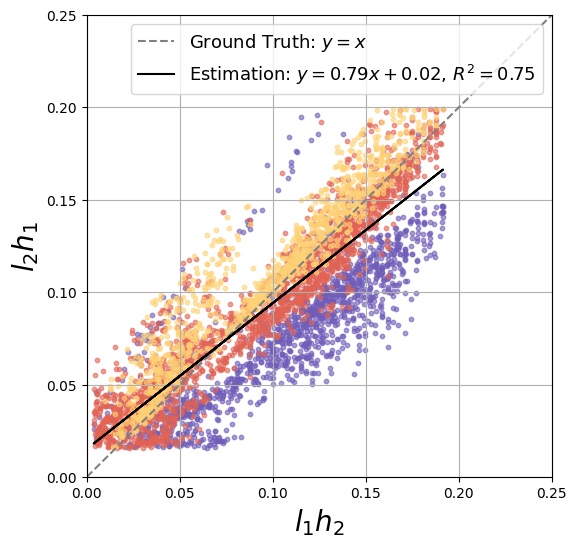

Scatter plot saved to scatter_plot_3_groups.pdf


/tmp/ipykernel_553486/1319816264.py:16: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(output_pdf_path) as pdf:


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter(data_list, output_pdf_path):
    """
    绘制散点图，每组数据使用不同的颜色，并添加拟合直线。

    Args:
        data_list (list of dict): 包含三组数据的列表，每个字典表示一组数据，
                           键可以是任意标识符，值是点的列表。
        output_pdf_path (str): 输出 PDF 文件的路径。
    """
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        colors = ["#6f5db9", '#E26354', "#ffd275"]  # 定义颜色列表

        all_points = []

        # 遍历所有数据组
        for i, data in enumerate(data_list):
          
            points_in_group = []
            for points in data.values():
                points_in_group.extend(points)  # 合并当前组的所有点
            
            
            all_points.extend(points_in_group) # 合并所有数据组的点
            
        # 提取所有点的 x 和 y 坐标
        x_all = np.array([p[0] for p in all_points])
        y_all = np.array([p[1] for p in all_points])



        # 绘制参考线
        ground_truth_line, = plt.plot([0, 0.3], [0, 0.3], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=1.5)
        plt.xlabel(r'$l_1h_2$', fontsize=20)
        plt.ylabel(r'$l_2h_1$', fontsize=20)
        plt.grid(True)

        # 计算 x 和 y 的 2.5% 和 97.5% 百分位数
        x_low, x_high = np.percentile(x_all, [2.5, 97.5])
        y_low, y_high = np.percentile(y_all, [2.5, 97.5])


        # 筛选在 95% 区间内的点
        mask = (x_low <= x_all) & (x_all <= x_high) & (y_low <= y_all) & (y_all <= y_high) & ~((0.10 < x_all) & (y_all < 0.05)) & ~((0.05 > x_all) & (y_all > 0.1)) &~((0.20 < x_all) & (y_all < 0.10))
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]

        
        
        # 对每个数据组进行绘制散点图，并应用不同的颜色
        start_index = 0
        estimation_lines = []
        for i, data in enumerate(data_list):
          num_points_in_group = 0
          for points in data.values():
            num_points_in_group+= len(points)  # 合并当前组的所有点
          color = colors[i] # 获取当前组的颜色
          
          
          end_index = start_index + num_points_in_group
          
          x_group = x_filtered[start_index:end_index]
          y_group = y_filtered[start_index:end_index]

          plt.scatter(x_group,y_group , c=color, alpha=0.6, s=10)
          start_index = end_index

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_
        
        # 绘制拟合直线
        estimation_line, = plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')
        estimation_lines.append(estimation_line)

        # 设置图例和布局
        legend_elements = [ground_truth_line, ] + estimation_lines
        plt.legend(handles=legend_elements, fontsize=13)
        # plt.tight_layout()
        plt.xlim(0,0.25)
        plt.ylim(0,0.25)
        # pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")


if __name__ == '__main__':
   
    data_list = [
      {"group1": list(zip(x_all_0,y_all_0)) , "group2": []},
      {"group1": list(zip(x_all_1,y_all_1)), "group2": []},
      {"group1": list(zip(x_all_2,y_all_2)), "group2": []},
    ]
    


    output_pdf = 'scatter_plot_3_groups.pdf'
    plot_scatter(data_list, output_pdf)

## Mitigation

Number of -1 values: 899
Histogram of positive data with intervals of 0.5:
Interval 0.0 to 0.5: 194
Interval 0.5 to 1.0: 1421
Interval 1.0 to 1.5: 415
Interval 1.5 to 2.0: 31
Interval 2.0 to 2.5: 11
Interval 2.5 to 3.0: 7
Interval 3.0 to 3.5: 4
Interval 3.5 to 4.0: 2
Interval 4.0 to 4.5: 2
Interval 4.5 to 5.0: 3
Interval 5.0 to 5.5: 2
Interval 5.5 to 6.0: 1
Interval 6.0 to 6.5: 0
Interval 6.5 to 7.0: 0
Interval 7.0 to 7.5: 1
Interval 7.5 to 8.0: 1
Interval 8.0 to 8.5: 1
Interval 8.5 to 9.0: 0
Interval 9.0 to 9.5: 0
Interval 9.5 to 10.0: 0
Interval 10.0 to 10.5: 0
Interval 10.5 to 11.0: 1
Interval 11.0 to 11.5: 0
Interval 11.5 to 12.0: 0
Interval 12.0 to 12.5: 0
Interval 12.5 to 13.0: 1
Interval 13.0 to 13.5: 0
Interval 13.5 to 14.0: 0
Interval 14.0 to 14.5: 0
Interval 14.5 to 15.0: 1
Interval 15.0 to 15.5: 0
Interval 15.5 to 16.0: 0
Interval 16.0 to 16.5: 0
Interval 16.5 to 17.0: 0
Interval 17.0 to 17.5: 0
Interval 17.5 to 18.0: 0
Interval 18.0 to 18.5: 0
Interval 18.5 to 19.0: 0
Inter

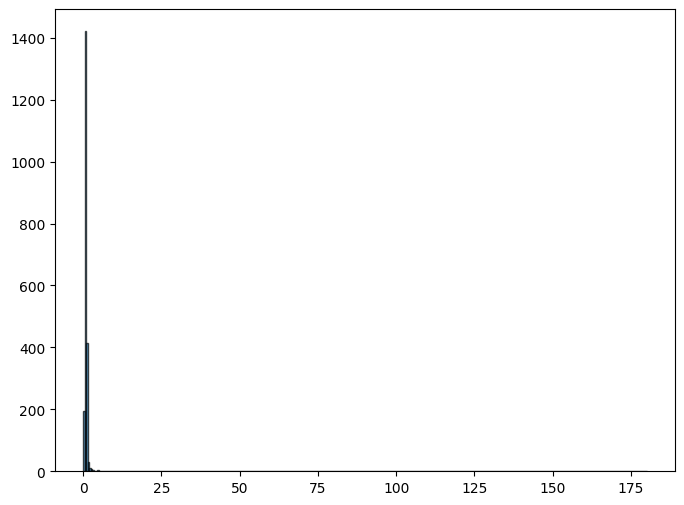

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_plot_distribution(data_list):
    # 将数据转为 numpy 数组
    data = np.array(data_list)

    # 统计 -1 的数量
    minus_one_count = np.sum(data == -1)
    
    # 过滤大于 0 的数据
    positive_data = data[data > 0]
    
    # 定义区间范围，从0开始，0.5为一个区间
    bin_edges = np.arange(0, positive_data.max() + 0.5, 0.5)
    
    # 统计每个区间的数量
    hist, bins = np.histogram(positive_data, bins=bin_edges)

    # 输出统计结果
    print(f"Number of -1 values: {minus_one_count}")
    print("Histogram of positive data with intervals of 0.5:")
    for i in range(len(hist)):
        print(f"Interval {bins[i]:.1f} to {bins[i+1]:.1f}: {hist[i]}")

    # 绘制直方图
    plt.figure(figsize=(8, 6))
    plt.hist(positive_data, bins=bin_edges, edgecolor='black', alpha=0.7)

    # 设置图表标题和标签
    # plt.title('Histogram of Positive Data', fontsize=16)
    # plt.xlabel('Value', fontsize=14)
    # plt.ylabel('Frequency', fontsize=14)
    
    # # 显示区间
    # plt.xticks(np.arange(0, positive_data.max() + 1, 0.5))
    
    # # 显示图形
    # plt.grid(True)
    # plt.show()


analyze_and_plot_distribution(scores)


In [50]:
len(scores)

3000

In [51]:
import numpy as np
import os

def add_labels_to_predictions(scores, folder_path):
    """
    This function reads all `.npz` files that start with 'prediction_' from the folder,
    adds labels to the predictions, and saves them back to the same `.npz` files.
    :param scores: List of scores to assign as labels (length should match the number of prediction data points)
    :param folder_path: Path to the folder containing the `.npz` files
    """
    # Get all files in the folder that start with 'prediction_' and end with '.npz'
    files = [f for f in os.listdir(folder_path) if f.startswith('prediction_') and f.endswith('.npz')]
    
    # Sort the files if necessary (e.g., by the number in the filename, or by timestamp)
    files.sort()

    # Iterate over each file
    for i, file in enumerate(files):
        # Load the .npz file
        file_path = os.path.join(folder_path, file)
        data = np.load(file_path)
        
        # Get the prediction data
        prediction_data = data['x']  # Assuming 'x' contains the prediction data
        # print("prediction_data shape:", prediction_data.shape)
        
        # Check if the number of samples in prediction_data matches the number of scores
        if prediction_data.shape[0] != len(scores):
            print(f"Error: The number of samples in {file} does not match the number of scores!")
            continue

        # Create a new labels array with the same length as prediction_data
        labels = np.array(scores)  # Assuming scores is a list or array of length 3000

        # Add label to the prediction data
        data_dict = {
            'x': prediction_data,
            'label': labels
        }
        
        # Save back to the same .npz file with the new label
        np.savez(file_path, **data_dict)
        print(f"Updated: {file_path}")


folder_path = "/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018"
add_labels_to_predictions(scores, folder_path)


prediction_data shape: (3000, 3072)
Updated: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_10.npz
prediction_data shape: (3000, 3072)
Updated: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_100.npz
prediction_data shape: (3000, 3072)
Updated: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_1000.npz
prediction_data shape: (3000, 3072)
Updated: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_200.npz
prediction_data shape: (3000, 3072)
Updated: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_300.npz
prediction_data shape: (3000, 3072)
Updated: /cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_499.npz
prediction_data shape: (3000, 3072

In [52]:
a = np.load("/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_10.npz")

In [73]:
a["label"][3] >=-1

True

In [71]:
scores

[0.4129869915331433,
 0.9574609186619834,
 0.9685534083567396,
 -1,
 1.0259221992049783,
 0.9680573032557169,
 0.8796992113743018,
 0.8181817849763885,
 -1,
 -1,
 0.8907589428148954,
 0.7995266802053184,
 0.9714285136054457,
 -1,
 1.0239361248255263,
 0.6293705193408183,
 0.24444439917696312,
 0.8524251512753646,
 -1,
 0.27450974411552415,
 -1,
 -1,
 -1,
 0.1578947130985394,
 1.2553569186862645,
 -1,
 -1,
 -1,
 0.8834100975387051,
 1.0996492957437376,
 0.6797385418972507,
 -1,
 0.8760605795133157,
 -1,
 -1,
 0.8538461210059184,
 0.7148540877037769,
 -1,
 0.8067915454686315,
 0.7777777425044107,
 0.9562841203454876,
 0.5791960805683025,
 -1,
 -1,
 0.7067307479948693,
 0.8509512842546212,
 0.9056603417586343,
 0.989852668089929,
 0.4727272113341284,
 0.8173076431906464,
 0.8811188503105296,
 1.2337660735368736,
 0.8325122896393999,
 0.6059800463129552,
 -1,
 -1,
 -1,
 0.47972026294684394,
 -1,
 0.6678082001196289,
 -1,
 -1,
 1.2352940710673426,
 -1,
 -1,
 0.7005494264921213,
 0.871212055

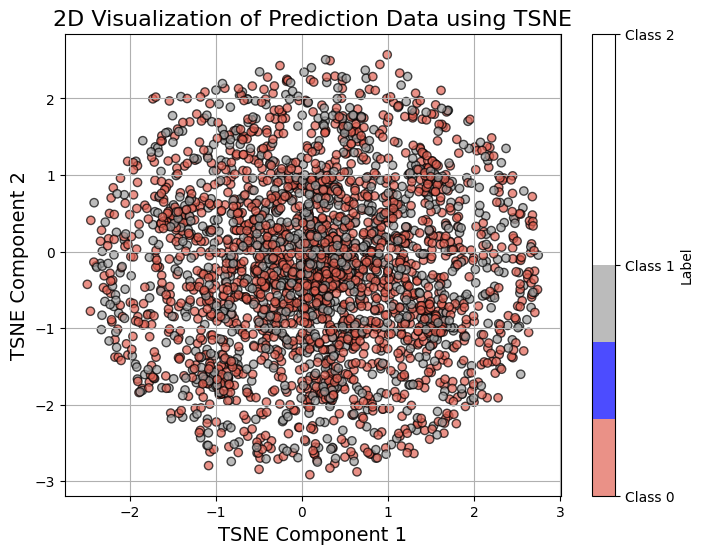

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

def visualize_prediction_with_labels(npz_file, method='umap'):
    """
    This function visualizes prediction data with labels, reducing the dimensions using either UMAP or t-SNE.
    :param npz_file: Path to the .npz file containing the data and labels
    :param method: The dimensionality reduction method to use ('umap' or 'tsne')
    """
    # 读取 npz 文件
    data = np.load(npz_file)
    
    # 获取数据和标签
    x = data['x']  # 假设 'x' 包含高维数据
    labels_filtered = data['label']  # 假设 'label' 包含对应的标签
    scaler = StandardScaler()
    # 假设 x 是 (n_samples, height, width, channels)，
    # 先将其变成 2D 形状，以便进行标准化
    original_shape = x.shape  # 保留原始形状
    x = x.reshape(x.shape[0], -1)  # 扁平化为 2D，每行是一个样本的特征
    x = scaler.fit_transform(x)   # 标准化

    # 将数据恢复为原始形状
    x_filtered = x.reshape(original_shape)  # 恢复原始形状
    # 筛选标签在 -1 到 10 之间的数据
    # mask = (labels >= -1) & (labels <= 10)
    # x_filtered = x[mask]
    # labels_filtered = labels[mask]
    # print(min(labels_filtered),max(labels_filtered ))

    # 对标签进行划分：
    # -1 -> 0, 0.8到1.2之间 -> 1, 其他 -> 2
    new_labels = np.zeros_like(labels_filtered)
    # new_labels[(labels_filtered <= 0)] = 0
    new_labels[(labels_filtered >= 0.8) & (labels_filtered <= 1.2)] = 1
    new_labels[((labels_filtered < 0.8 )& (labels_filtered > 0)) | (labels_filtered > 1.2) | (labels_filtered < 0)] = 0
    # print(np.unique(new_labels))

    # 检查 x_filtered 和 new_labels 的长度是否匹配
    if len(x_filtered) != len(new_labels):
        print(f"Length mismatch: x_filtered length = {len(x_filtered)}, new_labels length = {len(new_labels)}")
        return
    
    # 降维到二维
    if method == 'umap':
        reducer = umap.UMAP(n_components=2)
        x_2d = reducer.fit_transform(x_filtered)
    elif method == 'tsne':
        reducer = TSNE(n_components=2)
        x_2d = reducer.fit_transform(x_filtered)
    else:
        raise ValueError("Method should be either 'umap' or 'tsne'")

    # 定义离散颜色映射
    cmap = ListedColormap(['#E26354', 'blue', '#9E9E9E'])  # 这里你可以选择适合的颜色

    # 绘制散点图，颜色由新标签决定
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=new_labels, cmap=cmap, alpha=0.7, edgecolors='k')
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ticks=[0, 1, 2])  # 颜色条显示离散的标签
    cbar.set_label('Label')
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(['Class 0', 'Class 1', 'Class 2'])

    # 设置标题和标签
    plt.title(f'2D Visualization of Prediction Data using {method.upper()}', fontsize=16)
    plt.xlabel(f'{method.upper()} Component 1', fontsize=14)
    plt.ylabel(f'{method.upper()} Component 2', fontsize=14)

    # 显示图形
    plt.grid(True)
    plt.show()

# Example usage:
npz_file = '/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_900.npz'
visualize_prediction_with_labels(npz_file, method='tsne')  # or method='tsne'


In [198]:
import numpy as np
import matplotlib.pyplot as plt

file = 1000
# 假设你已经加载了数据：x 和 score
score = np.load(f"/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_{file}.npz")['label']
x = np.load(f"/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_{file}.npz")['x']
# 绘制 score 的分布图
# plt.hist(score, bins=50, density=True)
# plt.title("Score Distribution")
# plt.xlabel("Score")
# plt.ylabel("Density")
# plt.show()


Cluster-wise Score Statistics:
         count      mean       std       min       25%       50%       75%  \
Cluster                                                                      
0         26.0  0.840904  0.304115  0.170000  0.748725  0.871023  0.986400   
1         87.0  0.840441  0.307389  0.107858  0.682903  0.830508  0.967413   
2        481.0  0.849850  0.263416  0.100213  0.716667  0.848485  0.983928   
3        427.0  0.845676  0.274774  0.047866  0.723870  0.844828  0.968319   
4        228.0  0.836070  0.287538  0.098490  0.694182  0.844209  0.997727   
5        172.0  0.833735  0.251678  0.124621  0.731526  0.817745  0.946412   
6        231.0  0.862486  0.278378  0.111071  0.702282  0.848485  1.016618   
7        137.0  0.852640  0.334016  0.049872  0.701299  0.833333  0.968000   
8         55.0  0.742177  0.240214  0.057439  0.667687  0.782704  0.898616   
9        228.0  0.867242  0.308920  0.057754  0.719924  0.860175  1.004646   

              max  
Cluster     

/tmp/ipykernel_3541014/2825990069.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)


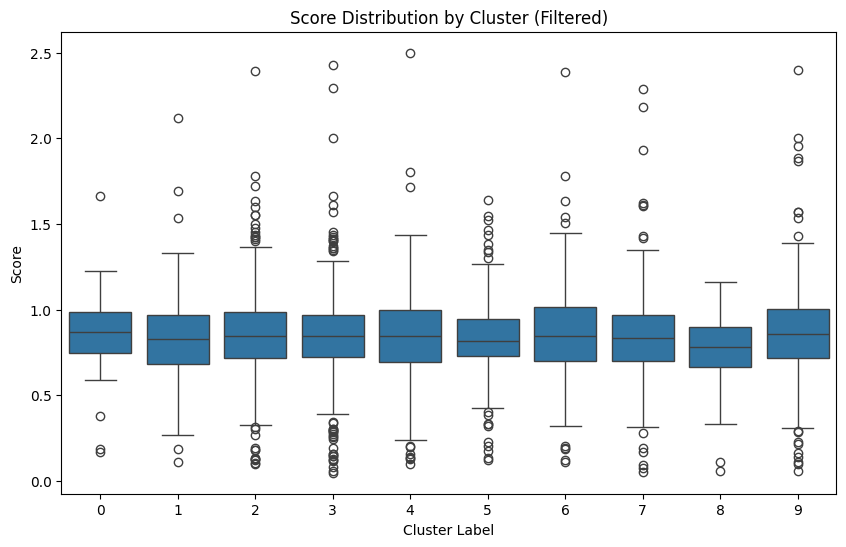

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 假设你的聚类标签是 `labels`，score 是 `score`
# labels.shape == (3000,) 和 score.shape == (3000,)

# 将聚类标签和 score 组合成一个 DataFrame
df = pd.DataFrame({
    'Cluster': labels,   # 聚类标签
    'Score': score       # 对应的分数
})

# 排除 score 大于 2.5 或小于 0 的样本
df_filtered = df[(df['Score'] <= 2.5) & (df['Score'] >= 0)]

# 计算每个聚类标签的统计信息
cluster_stats = df_filtered.groupby('Cluster')['Score'].describe()

# 计算 Score 在 [0.9, 1.1] 范围内的样本量占比
df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)

# 计算每个聚类标签中，Score 在 [0.9, 1.1] 范围内的样本量占比
range_proportion = df_filtered.groupby('Cluster')['In_Range'].mean()

# 打印统计信息和占比
print("Cluster-wise Score Statistics:")
print(cluster_stats)

print("\nProportion of samples with Score in [0.9, 1.1] range:")
print(range_proportion)

# 使用 seaborn 画 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Score', data=df_filtered)

# 设置标题和标签
plt.title("Score Distribution by Cluster (Filtered)")
plt.xlabel("Cluster Label")
plt.ylabel("Score")

# 显示图形
plt.show()


In [206]:
import numpy as np
import torch
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # 引入 tqdm 库，用于显示进度条

# 假设你的数据是 x 和对应的 score
# x.shape == (3000, 3072)，score.shape == (3000,)
x_flattened = x.reshape(x.shape[0], -1)  # 将数据拉伸为一维

# 初始化参数
best_k = None
best_k_proportion = 0
best_k_means = None
best_k_covariances = None

# 尝试不同的 k 值（从 2 到 10）
k_range = range(10, 21)

# 使用 tqdm 来显示进度条
for k in tqdm(k_range, desc="Trying different k values", ncols=100):
    # 使用 GMM
    gmm = GaussianMixture(n_components=k)
    gmm.fit(x_flattened)
    
    # 获取每个样本对应的标签
    labels = gmm.predict(x_flattened)
    
    # 将聚类标签和 score 组合成一个 DataFrame
    df = pd.DataFrame({
        'Cluster': labels,   # 聚类标签
        'Score': score       # 对应的分数
    })
    
    # 排除 score 大于 2.5 或小于 0 的样本
    df_filtered = df[(df['Score'] <= 2.5) & (df['Score'] >= 0)]
    
    # 计算每个聚类标签中，Score 在 [0.9, 1.1] 范围内的样本量占比
    df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
    range_proportion = df_filtered.groupby('Cluster')['In_Range'].mean()
    
    # 打印每个 k 对应的占比
    print(f"Proportion of samples with Score in [0.9, 1.1] for k={k}:")
    print(range_proportion)
    
    # 计算最大占比的 k 和对应的均值和方差
    max_proportion = range_proportion.max()
    if max_proportion > best_k_proportion:
        best_k_proportion = max_proportion
        best_k = k
        best_k_means = gmm.means_
        best_k_covariances = gmm.covariances_

# 输出最佳 k 对应的均值和方差
print(f"\nBest k: {best_k}")
print(f"Best k Proportion of samples with Score in [0.9, 1.1]: {best_k_proportion}")
print(f"Best k Means (Cluster Centers):")
print(best_k_means)
print(f"Best k Covariances:")
print(best_k_covariances)



Trying different k values:   0%|                                             | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:   9%|███▎                                 | 1/11 [00:36<06:07, 36.73s/it]

Proportion of samples with Score in [0.9, 1.1] for k=10:
Cluster
0    0.243902
1    0.259875
2    0.257143
3    0.269231
4    0.221698
5    0.287129
6    0.269663
7    0.362069
8    0.257053
9    0.288000
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  18%|██████▋                              | 2/11 [01:13<05:32, 36.99s/it]

Proportion of samples with Score in [0.9, 1.1] for k=11:
Cluster
0     0.206897
1     0.267327
2     0.228346
3     0.307692
4     0.294574
5     0.275862
6     0.245690
7     0.244318
8     0.248889
9     0.276074
10    0.196850
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  27%|██████████                           | 3/11 [01:59<05:28, 41.12s/it]

Proportion of samples with Score in [0.9, 1.1] for k=12:
Cluster
0     0.333333
1     0.229412
2     0.125000
3     0.264706
4     0.298246
5     0.273810
6     0.292453
7     0.307692
8     0.325000
9     0.265745
10    0.270142
11    0.290323
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  36%|█████████████▍                       | 4/11 [02:48<05:07, 43.94s/it]

Proportion of samples with Score in [0.9, 1.1] for k=13:
Cluster
0     0.424242
1     0.267559
2     0.236181
3     0.228571
4     0.243902
5     0.314286
6     0.253394
7     0.268293
8     0.319149
9     0.205128
10    0.285340
11    0.251429
12    0.303448
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  45%|████████████████▊                    | 5/11 [03:37<04:35, 45.95s/it]

Proportion of samples with Score in [0.9, 1.1] for k=14:
Cluster
0     0.666667
1     0.257143
2     0.250000
3     0.242812
4     0.282219
5     0.313253
6     0.336735
7     0.166667
8     0.245399
9     0.247312
10    0.219512
11    0.344828
12    0.267606
13    0.217949
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  55%|████████████████████▏                | 6/11 [04:29<04:00, 48.06s/it]

Proportion of samples with Score in [0.9, 1.1] for k=15:
Cluster
0     0.242236
1     0.210526
2     0.273585
3     0.297872
4     0.267123
5     0.229730
6     0.220588
7     0.273469
8     0.222222
9     0.269231
10    0.312139
11    0.291139
12    0.255474
13    0.281915
14    0.248120
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  64%|███████████████████████▌             | 7/11 [05:26<03:23, 50.80s/it]

Proportion of samples with Score in [0.9, 1.1] for k=16:
Cluster
0     0.400000
1     0.251142
2     0.307018
3     0.276596
4     0.240964
5     0.250000
6     0.170732
7     0.279793
8     0.266010
9     0.300578
10    0.331343
11    0.182573
12    0.255924
13    0.100000
14    0.200000
15    0.409091
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  73%|██████████████████████████▉          | 8/11 [06:26<02:41, 53.73s/it]

Proportion of samples with Score in [0.9, 1.1] for k=17:
Cluster
0     0.285714
1     0.252252
2     0.254682
3     0.313253
4     0.237113
5     0.272997
6     0.095238
7     0.310345
8     0.230769
9     0.318182
10    0.319797
11    0.130435
12    0.270833
13    0.243243
14    0.321429
15    0.293478
16    0.253521
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  82%|██████████████████████████████▎      | 9/11 [07:27<01:51, 55.96s/it]

Proportion of samples with Score in [0.9, 1.1] for k=18:
Cluster
0     0.228261
1     0.321429
2     0.282051
3     0.208333
4     0.111111
5     0.293478
6     0.313725
7     0.255682
8     0.333333
9     0.243902
10    0.209877
11    0.260586
12    0.245902
13    0.236559
14    0.286307
15    0.227586
16    0.338710
17    0.263158
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values:  91%|████████████████████████████████▋   | 10/11 [08:37<01:00, 60.29s/it]

Proportion of samples with Score in [0.9, 1.1] for k=19:
Cluster
0     0.315789
1     0.299363
2     0.262857
3     0.357143
4     0.386364
5     0.272152
6     0.243243
7     0.222222
8     0.265306
9     0.255892
10    0.264368
11    0.272059
12    0.294118
13    0.246154
14    0.253394
15    0.333333
16    0.343750
17    0.222222
18    0.130435
Name: In_Range, dtype: float64


/tmp/ipykernel_3541014/1122976583.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)
Trying different k values: 100%|████████████████████████████████████| 11/11 [09:48<00:00, 53.53s/it]

Proportion of samples with Score in [0.9, 1.1] for k=20:
Cluster
0     0.350000
1     0.262626
2     0.210526
3     0.287037
4     0.203125
5     0.208333
6     0.233333
7     0.375000
8     0.264382
9     0.357143
10    0.000000
11    0.306452
12    0.314917
13    0.355263
14    0.294118
15    0.173913
16    0.210526
17    0.257143
18    0.350000
19    0.263566
Name: In_Range, dtype: float64

Best k: 14
Best k Proportion of samples with Score in [0.9, 1.1]: 0.6666666666666666
Best k Means (Cluster Centers):
[[-0.44438596 -0.1775137   0.21515979 ... -0.45245498 -0.33239396
   0.03652995]
 [ 0.09323482 -0.31121532  0.03311737 ... -0.18506574  0.06972562
  -0.19794278]
 [ 0.33148981 -0.33386867 -0.02167581 ... -0.13712875  0.01458599
   0.03200439]
 ...
 [-0.02885485  0.06105233 -0.17032224 ...  0.05348143  0.03623687
   0.23775257]
 [-0.01398067 -0.02431246  0.02596881 ... -0.04527633 -0.0520957
   0.00146674]
 [ 0.04781289 -0.01430383 -0.1059856  ... -0.05059709 -0.02401256
   0.002716

In [209]:
save_path = '/cpfs04/user/hanyujin/causal-dm/latent_class'
best_k_means_tensor = torch.tensor(best_k_means, dtype=torch.float32)  # 将均值转为 Tensor
best_k_covariances_tensor = torch.tensor(best_k_covariances, dtype=torch.float32)  # 将方差转为 Tensor

# 将均值和方差保存为 .pt 文件
torch.save(best_k_means_tensor, os.path.join(save_path, f'best_k_{best_k}_means.pt'))
torch.save(best_k_covariances_tensor, os.path.join(save_path, f'best_k_{best_k}_covariances.pt'))

print(f"\nSaved best k means and covariances for k={best_k} to {save_path}")


Saved best k means and covariances for k=14 to /cpfs04/user/hanyujin/causal-dm/latent_class


Cluster-wise Score Statistics:
         count      mean       std       min       25%       50%       75%  \
Cluster                                                                      
0          2.0  0.647124  0.267204  0.458182  0.552653  0.647124  0.741595   
1        278.0  0.841024  0.274122  0.090686  0.717500  0.833333  0.972059   
2         33.0  0.872763  0.272963  0.107858  0.764822  0.857843  0.972093   
3        746.0  0.833563  0.278268  0.047866  0.706065  0.832042  0.967799   
4        120.0  0.857526  0.300344  0.180769  0.738553  0.835282  0.967875   
5        116.0  0.884024  0.270520  0.103594  0.761820  0.907342  1.018047   
6         59.0  0.816990  0.272030  0.124621  0.688301  0.840000  0.981490   
7         66.0  0.845740  0.249488  0.204255  0.706808  0.843444  0.943094   
8        144.0  0.847969  0.305176  0.049872  0.705974  0.834611  0.965888   
9          8.0  0.946298  0.397644  0.384774  0.718326  0.876940  1.135829   
10        36.0  0.902835  0.46796

/tmp/ipykernel_3541014/833706124.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)


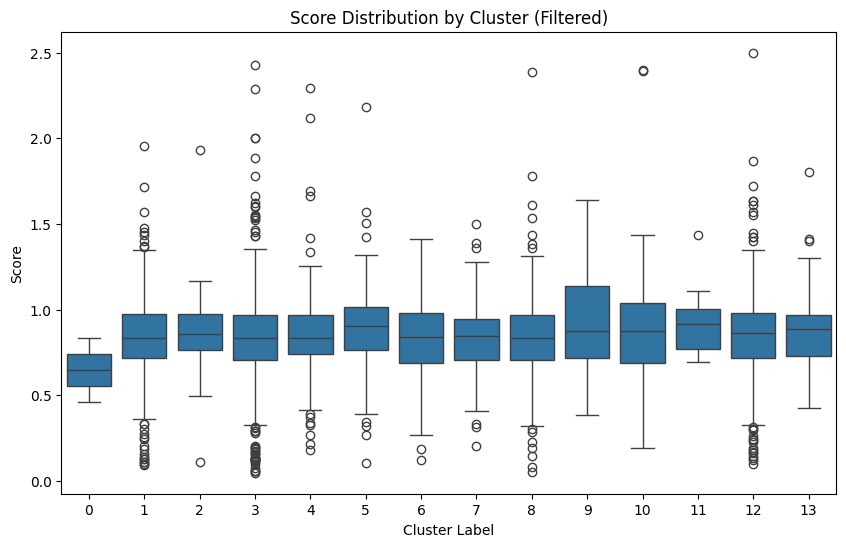

In [207]:
# from sklearn.cluster import KMeans
# k = 5
# kmeans = KMeans(n_clusters=k)
# kmeans.fit(x)

# # 聚类结果
# labels = kmeans.labels_

# # 查看聚类的均值
# print(kmeans.cluster_centers_)

from sklearn.mixture import GaussianMixture
import numpy as np

# 假设 x 是你的数据
# k 是聚类的数量
k = 14

# 使用 GMM
gmm = GaussianMixture(n_components=k)

# 拟合模型
gmm.fit(x)

# 获取每个样本对应的标签
labels = gmm.predict(x)

# 查看 GMM 的均值（每个聚类的均值）
# print("GMM Cluster Centers (means of components):")
# print(gmm.means_)

# 如果你还需要每个样本的分布概率（责任度）
# probabilities = gmm.predict_proba(x)  # 每个样本属于各个高斯成分的概率

# # 查看前几个样本的概率
# print("First 5 samples' probabilities for each component:")
# print(probabilities[:5])

# labels 现在是每个数据点所属的 GMM 聚类标签

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 假设你的聚类标签是 `labels`，score 是 `score`
# labels.shape == (3000,) 和 score.shape == (3000,)

# 将聚类标签和 score 组合成一个 DataFrame
df = pd.DataFrame({
    'Cluster': labels,   # 聚类标签
    'Score': score       # 对应的分数
})

# 排除 score 大于 2.5 或小于 0 的样本
df_filtered = df[(df['Score'] <= 2.5) & (df['Score'] >= 0)]

# 计算每个聚类标签的统计信息
cluster_stats = df_filtered.groupby('Cluster')['Score'].describe()

# 计算 Score 在 [0.9, 1.1] 范围内的样本量占比
df_filtered['In_Range'] = df_filtered['Score'].between(0.9, 1.1)

# 计算每个聚类标签中，Score 在 [0.9, 1.1] 范围内的样本量占比
range_proportion = df_filtered.groupby('Cluster')['In_Range'].mean()

# 打印统计信息和占比
print("Cluster-wise Score Statistics:")
print(cluster_stats)

print("\nProportion of samples with Score in [0.9, 1.1] range:")
print(range_proportion)

# 使用 seaborn 画 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Score', data=df_filtered)

# 设置标题和标签
plt.title("Score Distribution by Cluster (Filtered)")
plt.xlabel("Cluster Label")
plt.ylabel("Score")

# 显示图形
plt.show()


In [ ]:
import torch
import numpy as np

# 假设 `best_mean` 和 `best_cov` 是你计算得到的
np.save('/cpfs04/user/hanyujin/causal-dm/latent_class/model/best_mean.npy', best_mean)  # 保存均值
np.save('/cpfs04/user/hanyujin/causal-dm/latent_class/model/best_cov.npy', best_cov)    # 保存协方差


### save sampling

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 假设文件名是已知的
file = 1000

# 加载数据：score 和 x
score = np.load(f"/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_{file}.npz")['label']
x = np.load(f"/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_{file}.npz")['x']

# 选择 score 在 [0.95, 1.05] 范围内的样本
mask = (score >= 0.95) & (score <= 1.05)
filtered_x = x[mask]
filtered_score = score[mask]

# 打印筛选出来的样本数量
print(f"Number of samples with score in range [0.95, 1.05]: {filtered_x.shape[0]}")




Number of samples with score in range [0.95, 1.05]: 283


In [61]:
import torch
import numpy as np
score = np.load("/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_1000.npz")['label']
x = np.load("/cpfs04/user/hanyujin/causal-dm/results/sunshadow_lfd_lnd_rfd_rnd/vis/epoch_400_1737189887.87018/prediction_1000.npz")['x']
# 选择 score 在 [0.95, 1.05] 范围内的样本
mask = (score >= 0.99) & (score <= 1.01)
filtered_x = x[mask]
print("filtered_x:",filtered_x.shape)
target_size = 1000
repeats = target_size // filtered_x.shape[0] + 1  # 计算需要重复的次数
x_repeated = np.repeat(filtered_x, repeats, axis=0)[:target_size]  # 重复并截取到 (3000, 3072)

# Step 2: 将数据 reshape 为 (3000, 3, 32, 32)
x_repeated_tensor = torch.from_numpy(x_repeated)
x_reshaped = x_repeated_tensor.view((target_size, 3, 32, 32))  # 转换形状，确保输入的维度是正确的

# Step 3: 计算均值和设定固定的标准差
mean_tensor = x_reshaped.mean(dim=0)  # 计算均值，形状为 (3, 32, 32)
std_tensor = torch.ones_like(mean_tensor) * 0.1  # 设置标准差为 0.1，形状与 mean_tensor 相同


# Step 4: 使用均值和标准差生成新采样的数据
new_samples = torch.normal(mean=mean_tensor.unsqueeze(0).expand(target_size, -1, -1, -1),
                           std=std_tensor.unsqueeze(0).expand(target_size, -1, -1, -1))  # 采样

# 输出结果
print(f"Original x shape: {x.shape}")
print(f"Repeated x shape: {x_repeated.shape}")
print(f"Reshaped x shape: {x_reshaped.shape}")
print(f"New samples shape: {new_samples.shape}")

filtered_x: (53, 3072)
Original x shape: (3000, 3072)
Repeated x shape: (1000, 3072)
Reshaped x shape: torch.Size([1000, 3, 32, 32])
New samples shape: torch.Size([1000, 3, 32, 32])


# Task B

## Traing Vis

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def find_rectangles_by_color(image, range1, range2):
    """
    基于颜色范围筛选图像中符合条件的矩形，并返回它们的坐标和大小。
    """
    # 转为 HSV 色彩空间
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 创建颜色范围的掩膜
    mask1 = cv2.inRange(hsv, np.array(range1[:3]), np.array(range1[3:]))
    mask2 = cv2.inRange(hsv, np.array(range2[:3]), np.array(range2[3:]))

    # 合并两个掩膜
    final_mask = cv2.bitwise_or(mask1, mask2)

    # 查找外部轮廓
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = []

    # 遍历轮廓，筛选出四边形
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:  # 只保留四边形
            x, y, w, h = cv2.boundingRect(approx)
            rectangles.append((x, y, w, h))  # 记录矩形的左上角坐标和宽高

    # 按左侧 x 坐标排序
    return sorted(rectangles, key=lambda r: r[0])


def process_images(folder_path, target_size=128):
    """
    遍历文件夹中的图片，并对数据进行处理；保存失败图片和 `l2 <= s2` 条件的图片 ID。
    """
    failed_images = []           # 存储处理失败的图片 ID
    l2_leq_s2_images = []        # 存储 l2 <= s2 的图片 ID
    coordinates = []             # 存储有效的数据点 (l1/l2, s1/s2)
    total_count = 0

    # 定义颜色范围
    # rectangles_range1 = [0, 20, 100, 100, 255, 255]  # 黄色系 HSV 范围（进一步扩展）
    # rectangles_range2 = [60, 20, 20, 180, 255, 255]  # 蓝绿色系 HSV 范围（进一步扩展）

    rectangles_range1 = [0, 30, 100, 255, 200, 255]  # 黄色系 HSV 范围
    rectangles_range2 = [90, 150, 100, 255, 100, 255]  # 蓝绿色系 HSV 范围



    # 遍历文件夹内的图片
    for filename in tqdm(sorted(os.listdir(folder_path)), desc="Processing Images"):
        if not filename.endswith(".png"):  # 忽略非 PNG 文件
            continue

        total_count += 1
        image_path = os.path.join(folder_path, filename)

        # 读取并调整图像大小
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {filename}")
            failed_images.append(filename)
            continue
        image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)

        # 检测符合颜色的矩形
        rectangles = find_rectangles_by_color(image, rectangles_range1, rectangles_range2)

        # 如果检测到的矩形少于 2 个，记录为失败
        if len(rectangles) < 2:
            failed_images.append(filename)
            continue

        # 提取第1和第2个矩形的参数
        x1, y1, w1, h1 = rectangles[0]
        x2, y2, w2, h2 = rectangles[1]

        # 计算 l1, l2, s1, s2
        l1 = x1/target_size # l1
        l2 = h1/target_size # h1
        s1 = x2/target_size # l2
        s2 = h2/target_size # h2

        if l2 <= s2:
            l2_leq_s2_images.append(filename)  # 记录 l2 <= s2 的图片 ID

        coordinates.append((l1 * l2, s1 * s2))

    # 保存 `failed_images` 和 `l2_leq_s2_images` 到文本文件
    if failed_images:
        with open(os.path.join(folder_path, "failed_images.txt"), "w") as f:
            for item in failed_images:
                f.write(item + "\n")

    if l2_leq_s2_images:
        with open(os.path.join(folder_path, "l2_leq_s2_images.txt"), "w") as f:
            for item in l2_leq_s2_images:
                f.write(item + "\n")

    # 返回有效数据点
    return np.array(coordinates), total_count, len(failed_images), len(l2_leq_s2_images)


# 主程序
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/perspective_type1/images"
coordinates, total_count, fail_count, l2_leq_s2_count = process_images(folder_path, target_size=256)  # 数据处理
print(f"Total images processed: {total_count}")
print(f"Failed images: {fail_count}")
print(f"Images with l2 <= s2: {l2_leq_s2_count}")


Processing Images:   1%|          | 20/2001 [00:00<00:22, 89.76it/s]

Processing Images: 100%|██████████| 2001/2001 [00:23<00:00, 85.35it/s]

Total images processed: 2000
Failed images: 779
Images with l2 <= s2: 0


In [33]:
all_points = []
colors = ['#5762b8']
# x = coordinates[:, 0]
# y = coordinates[:, 1]
for x,y in (coordinates):
    # 提取有效点
    valid_points = (x,y)#[p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
    if valid_points:
        all_points.extend(valid_points)
count = fail_count = 0
for x, y in coordinates:
    # 确定x所在区间的索引（0~9）
    idx = int(x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    # print(x,y,idx,lower,upper )
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1
    else:
        fail_count += 1
        # print(x,y,idx,lower,upper,lower <= y < upper)

# 计算占比
percentage = count / len(coordinates)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：97.22%


In [32]:
fail_count

10

In [22]:
coordinates

array([[0.09228516, 0.09265137],
       [0.07580566, 0.07751465],
       [0.12243652, 0.11862183],
       ...,
       [0.02929688, 0.03225708],
       [0.04653931, 0.05053711],
       [0.02114868, 0.02392578]])

In [20]:
coordinates[:0]

array([], shape=(0, 2), dtype=float64)

/tmp/ipykernel_198031/1010876328.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.15], [0, 0.15], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)


Scatter plot and fit saved to /cpfs04/user/hanyujin/causal-dm/example/taskb_rule.pdf


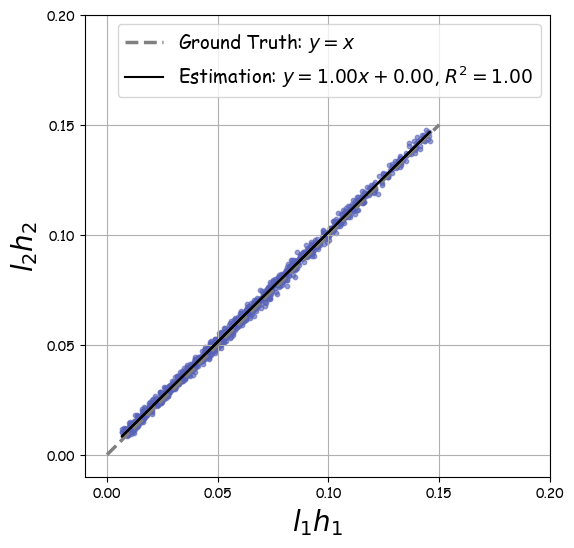

In [61]:
def plot_data_with_fit(coordinates, folder_path):
    """
    绘制数据的散点图，并对有效数据进行线性拟合，保存为 PDF。
    """
    colors = ['#5762b8']
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    # 提取 x 和 y 的 2.5% 和 97.5% 分位范围，剔除极值点
    x_min, x_max = np.percentile(x, [2.5, 97.5])
    y_min, y_max = np.percentile(y, [2.5, 97.5])
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)

    # 筛选有效数据点
    x_filtered = x[mask].reshape(-1, 1)
    y_filtered = y[mask]

    # 使用线性回归模型拟合直线
    model = LinearRegression()
    model.fit(x_filtered, y_filtered)
    y_pred = model.predict(x_filtered)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y_filtered, y_pred)

    # 绘制散点图和拟合直线
    plt.figure(figsize=(6, 6))
    plt.scatter(x_filtered, y_filtered, c=colors[0], alpha=0.6, s=10)
    plt.plot([0, 0.15], [0, 0.15], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)
    plt.plot(x_filtered, y_pred, color='black', label=f"Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$")
    plt.xlabel(r"$l_1h_1$",fontsize=20)
    plt.ylabel(r"$l_2h_2$",fontsize=20)
    plt.legend(fontsize=13.5)
    plt.xticks([0.00, 0.05,0.10, 0.15, 0.20])
    plt.yticks([0.00, 0.05,0.10, 0.15, 0.20])
    plt.grid()
    # plt.tight_layout()
    plt.xlim(-0.01, 0.2)
    plt.ylim(-0.01, 0.2)

    # 保存为 PDF
    pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/example", "taskb_rule.pdf")
    plt.savefig(pdf_path)
    print(f"Scatter plot and fit saved to {pdf_path}")


if len(coordinates) > 0:
    plot_data_with_fit(coordinates, folder_path)  # 数据拟合和绘图


## Genvis

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# 定义模型
class MLP(nn.Module):
    def __init__(self, input_size=3 * 32 * 32, num_classes=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 加载模型
model_path = "/cpfs04/user/hanyujin/causal-dm/contrsastive_dp/model/perspective_contrastive_ternary_MLP_100.pth"
model = MLP()
model.load_state_dict(torch.load(model_path))
model.eval()  # 设置为评估模式

# 检查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 图片预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整图片大小
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 图片目录和保存目录
image_dir = "/cpfs04/user/hanyujin/causal-dm/results/perspective_type1/vis/epoch_800_1735106255.0770738"
save_dir = "/cpfs04/user/hanyujin/causal-dm/results/perspective_type1/vis/epoch_800_1735106255.0770738_class1_100"

# 创建保存目录
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 获取所有图片文件（支持 PNG 和 JPG）
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
total_files = len(image_files)

# 遍历图片目录，并添加进度条
for filename in tqdm(image_files, desc="Processing images", unit="image"):
    try:
        # 读取图片
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')  # 确保图片是RGB格式
        image = transform(image).unsqueeze(0).to(device)  # 增加batch维度并移动到设备

        # 预测
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

        # 如果预测标签为1，保存图片
        if predicted_label == 1:
            save_path = os.path.join(save_dir, filename)
            Image.open(image_path).save(save_path)
            # print(f"Saved {filename} to {save_dir}")
    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("Prediction and saving completed.")

Processing images: 100%|██████████| 5984/5984 [00:25<00:00, 233.48image/s]

Prediction and saving completed.


In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def find_rectangles_by_color(image, range1, range2):
    """
    基于颜色范围筛选图像中符合条件的矩形，并返回它们的坐标和大小。
    """
    # 转为 HSV 色彩空间
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 创建颜色范围的掩膜
    mask1 = cv2.inRange(hsv, np.array(range1[:3]), np.array(range1[3:]))
    mask2 = cv2.inRange(hsv, np.array(range2[:3]), np.array(range2[3:]))

    # 合并两个掩膜
    final_mask = cv2.bitwise_or(mask1, mask2)

    # 查找外部轮廓
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = []

    # 遍历轮廓，筛选出四边形
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:  # 只保留四边形
            x, y, w, h = cv2.boundingRect(approx)
            rectangles.append((x, y, w, h))  # 记录矩形的左上角坐标和宽高

    # 按左侧 x 坐标排序
    return sorted(rectangles, key=lambda r: r[0])


def process_images(folder_path, target_size=128):
    """
    遍历文件夹中的图片，并对数据进行处理；保存失败图片和 `l2 <= s2` 条件的图片 ID。
    """
    failed_images = []  # 存储处理失败的图片 ID
    error_case_images = []  # 存储 l2 <= s2 的图片 ID
    coordinates = []  # 存储有效的数据点 (l1/l2, s1/s2)
    labels = []  # 存储数据点的标签 (l2 <= s2: 0, l2 > s2: 1)
    total_count = 0

    # 定义颜色范围
    rectangles_range1 = [0, 20, 100, 100, 255, 255]  # 黄色系 HSV 范围（进一步扩展）
    rectangles_range2 = [60, 20, 20, 180, 255, 255]  # 蓝绿色系 HSV 范围（进一步扩展）

    # 创建文件夹
    failed_folder = folder_path
    error_folder = folder_path

    os.makedirs(failed_folder, exist_ok=True)
    os.makedirs(error_folder, exist_ok=True)

    # 遍历文件夹内的图片
    for filename in tqdm(sorted(os.listdir(folder_path)), desc="Processing Images"):
        if not filename.endswith(".png"):  # 忽略非 PNG 文件
            continue

        total_count += 1
        image_path = os.path.join(folder_path, filename)

        # 读取并调整图像大小
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {filename}")
            failed_images.append(filename)
            continue
        image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)

        # 检测符合颜色的矩形
        rectangles = find_rectangles_by_color(image, rectangles_range1, rectangles_range2)

        # 如果检测到的矩形少于 2 个，记录为失败
        if len(rectangles) < 2:
            failed_images.append(filename)
            continue
        # 提取第1和第2个矩形的参数
        x1, y1, w1, h1 = rectangles[0]
        x2, y2, w2, h2 = rectangles[1]

        # 计算 l1, l2, s1, s2
        l1 = x1 / target_size # l1
        l2 = h1 / target_size # h1
        s1 = x2 / target_size
        s2 = h2 / target_size
        if l1 * l2 == 0 or s1 * s2 == 0:
            failed_images.append(filename)
            continue

        coordinates.append((l1 * l2, s1 * s2, ((s1*s2)/(l1*l2)-1)))
        is_error_case = l2 <= s2
        labels.append(0 if is_error_case else 1)  # 0 代表 l2 <= s2 (蓝色), 1 代表 l2 > s2 (红色)
        # if 11*12>0.10 and s1*s2>0.1:
        #     print(filename)
        
        if is_error_case:
            error_case_images.append(filename)

    # 保存 `failed_images` 和 `error_case_images` 到各自的文件夹下的文本文件
    if failed_images:
      with open(os.path.join(failed_folder, "failed_images.txt"), "w") as f:
          for item in failed_images:
              f.write(item + "\n")
    if error_case_images:
      with open(os.path.join(error_folder, "error_case_images.txt"), "w") as f:
          for item in error_case_images:
             f.write(item + "\n")


    # 返回有效数据点
    return np.array(coordinates), labels, total_count, len(failed_images)


# 主程序
# folder_path = "/cpfs01/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/perspective_type1/images"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/results/perspective_contrastive_ternary/vis/epoch_800_1735553933.9013307"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/results/perspective_type1/vis/epoch_800_1735106255.0770738"  # 图片路径
# folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/perspective_type1/epoch_800_cfg1000000_classmodel019999.pt_1738161552.7618198_pisewise"
folder_path = "/cpfs04/user/hanyujin/causal-dm/results/perspective_type1/vis/epoch_800_1735106255.0770738"
coordinates, labels, total_count, fail_count = process_images(folder_path, target_size=128)  # 数据处理
print(f"Total images processed: {total_count}")
print(f"Failed images: {fail_count}")

Processing Images:   1%|          | 59/5988 [00:00<00:10, 581.72it/s]

Processing Images: 100%|██████████| 5988/5988 [00:11<00:00, 536.39it/s]

Total images processed: 5984
Failed images: 4790


In [36]:
coordinates

array([[ 0.02929688,  0.015625  , -0.46666667],
       [ 0.0703125 ,  0.04980469, -0.29166667],
       [ 0.02539062,  0.05859375,  1.30769231],
       ...,
       [ 0.02734375,  0.0546875 ,  1.        ],
       [ 0.09277344,  0.0703125 , -0.24210526],
       [ 0.10546875,  0.13476562,  0.27777778]])

In [39]:
all_points = []
colors = ['#5762b8']
# x = coordinates[:, 0]
# y = coordinates[:, 1]
# for x,y in (coordinates):
#     # 提取有效点
#     valid_points = (x,y)#[p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
#     if valid_points:
#         all_points.extend(valid_points)
count = fail_count = 0
for x, y,_ in coordinates:
    # 确定x所在区间的索引（0~9）
    idx = int( x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    # print(x,y,idx,lower,upper )
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1
    else:
        fail_count += 1
        # print(x,y,idx,lower,upper,lower <= y < upper)

# 计算占比
percentage = count / len(coordinates)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：80.99%


All Points: 0
Filtered Ratios: 1136
Max Ratio: 1.4285714285714284
Min Ratio: -0.5625
Bias Error: 0.07302488871886444
Variance Error: 0.01340591719031297
Sum Error: 0.08392869490225968
Mean Sqrt Variance Error: 0.013405917190312972


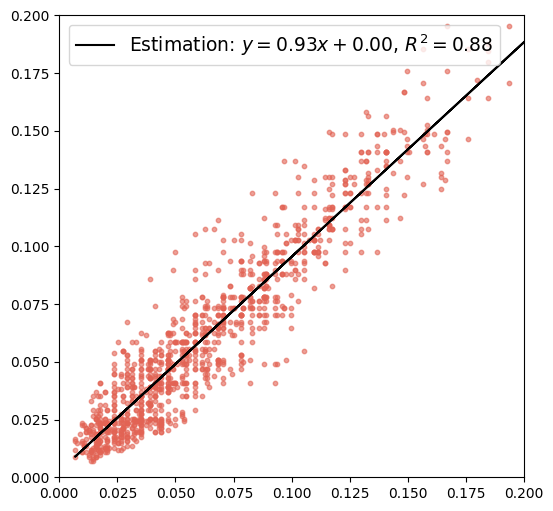

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/example/taskb_gen_class_100000.pdf


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages

def plot_scatter(data, labels, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 提取所有点的 x 和 y 坐标
        x_all = data[:, 0]
        y_all = data[:, 1]
        ratios = data[:, 2]
        labels = np.array(labels)

        # 计算每个点的 |y/x| 比率
        ratio_all = np.abs(y_all / x_all)

        # 计算 |y/x| 的 2.5% 和 97.5% 百分位数
        ratio_low, ratio_high = np.percentile(ratio_all, [2.5, 97.5])

        # 筛选出 |y/x| 在 2.5% 和 97.5% 百分位数区间内的点
        mask = (ratio_low <= ratio_all) & (ratio_all <= ratio_high)
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered , y_filtered, c=color, alpha=0.6, s=10)

        # 打印比率的统计信息

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        print("All Points:", len(all_points))
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        print(f"Bias Error: {np.sqrt(intercept**2)+np.sqrt((slope-1)**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) +np.sqrt(intercept**2+(slope-1)**2)}")
        print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2))))}")

        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局
        plt.legend(fontsize=13.5)
        # plt.tight_layout()
        plt.xlim(0,0.20)
        plt.ylim(0,0.20)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")


folder_path = "/cpfs04/user/hanyujin/causal-dm/example/taskb_gen_class_100000.pdf"#_class_100.pdf"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/example/taskb_rule_contrastive_epoch_800_cfg10_classmodel019999.pdf"
if len(coordinates) > 0:
    plot_scatter(coordinates, labels, folder_path)  # 数据拟合和绘图


/tmp/ipykernel_4058513/1043901782.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0.25], [0, 0.25], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)


All Points: 0
Filtered Ratios: 297
Max Ratio: 0.8400000000000001
Min Ratio: -0.6666666666666667
Bias Error: 0.03958596806462175
Variance Error: 0.012151815137118502
Sum Error: 0.051581038466982976
Mean Sqrt Variance Error: 0.012151815137118502


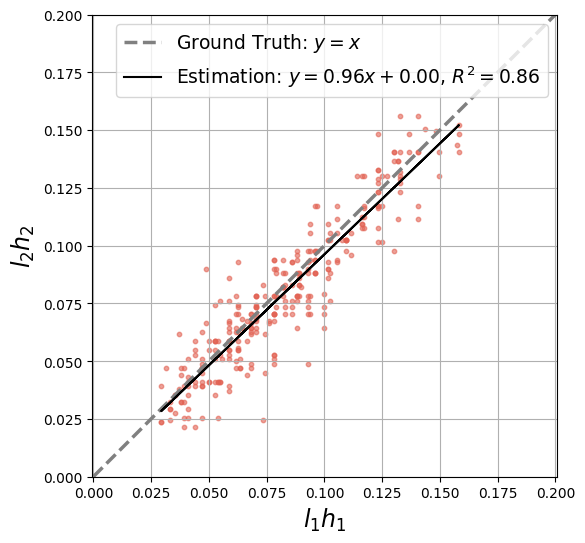

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/example/taskb_gen_class_100000.pdf


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages

def plot_scatter(data, labels, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 遍历所有 key 下的数值
        # for points in data.values():
        #     all_points.extend(points)  # 合并所有点

        # 提取所有点的 x 和 y 坐标
        x_all = data[:, 0]
        y_all = data[:, 1]
        ratios = data[:, 2]
        labels = np.array(labels)
        
        # 绘制所有点的散点图
        

        # 绘制参考线
        plt.plot([0, 0.25], [0, 0.25], 'k--', label='Ground Truth: $y=x$', color='gray', linewidth=2.5)
        plt.xlabel(r'$l_1h_1$', fontsize=17)
        plt.ylabel(r'$l_2h_2$', fontsize=17)
        plt.grid(True)
        plt.axis('equal')

        # 计算 x 和 y 的 2.5% 和 97.5% 百分位数
        x_low, x_high = np.percentile(x_all, [2.5, 97.5])
        y_low, y_high = np.percentile(y_all, [2.5, 97.5])

        # 筛选在 95% 区间内的点
        mask = (x_low <= x_all) & (x_all <= x_high) & (y_low <= y_all) & (y_all <= y_high)
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered , y_filtered, c=color, alpha=0.6, s=10)

        # 打印比率的统计信息

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_
 
        print("All Points:", len(all_points))
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        # print(f"Bias Error: {np.sqrt(intercept**2+(slope-1)**2)}")
        print(f"Bias Error: {np.sqrt(intercept**2)+np.sqrt((slope-1)**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) +np.sqrt(intercept**2+(slope-1)**2)}")
        print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2))))}")
       

        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局
        plt.legend(fontsize=13.5)
        # plt.tight_layout()
        plt.xlim(0,0.20)
        plt.ylim(0,0.20)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")


folder_path = "/cpfs04/user/hanyujin/causal-dm/example/taskb_gen_class_100000.pdf"#_class_100.pdf"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/example/taskb_rule_contrastive_epoch_800_cfg10_classmodel019999.pdf"
if len(coordinates) > 0:
    plot_scatter(coordinates, labels, folder_path)  # 数据拟合和绘图

# Bias Error: 0.07619555823987954
# Variance Error: 0.08555180563043892
# Mean Sqrt Variance Error: 0.0128887552126996

## Gen Vis Case

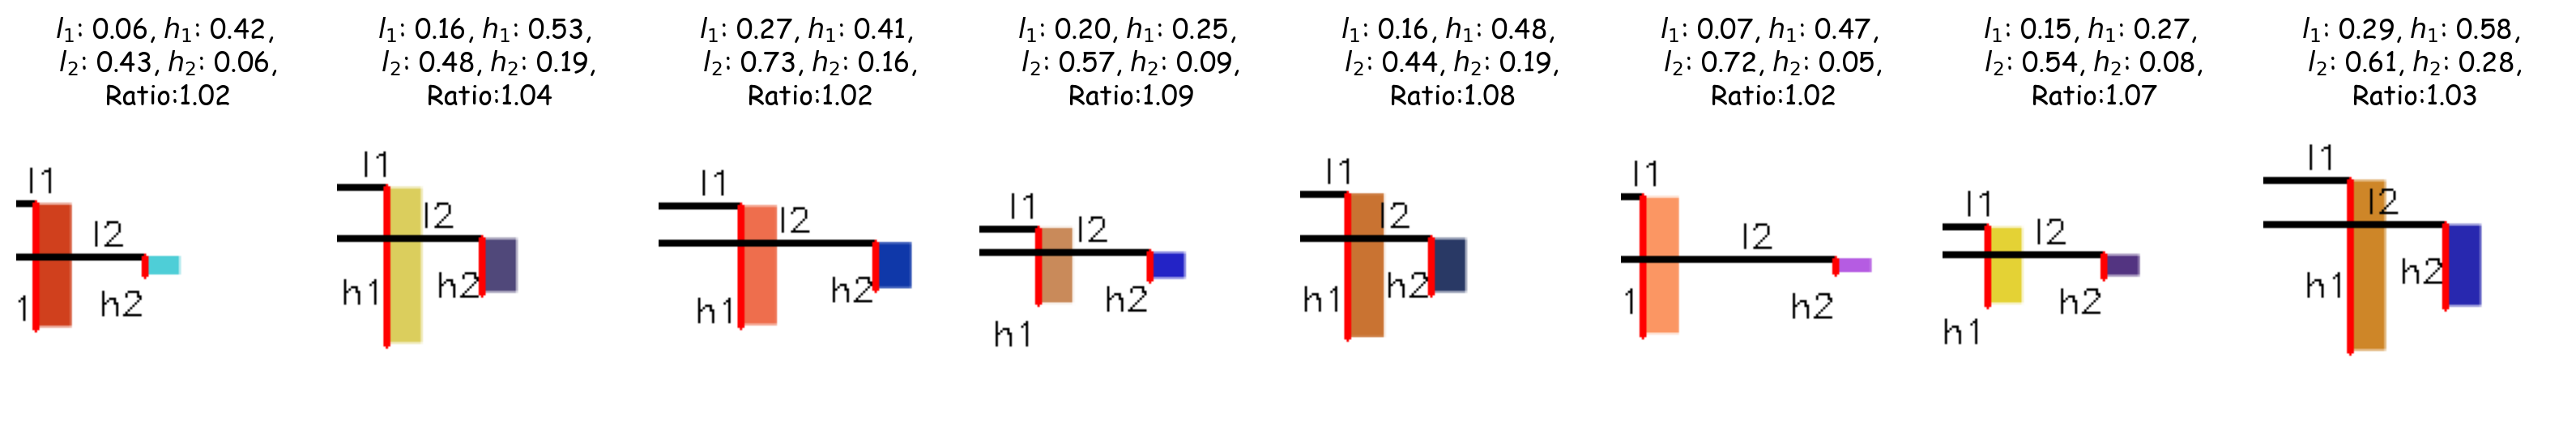

The Images is Saved to : /cpfs04/user/hanyujin/causal-dm/example/taskb_rule_case_train.pdf
Coordinates: [[0.02636719 0.02685547 0.01851852]
 [0.0871582  0.09082031 0.04201681]
 [0.11108398 0.11352539 0.02197802]
 [0.04882812 0.0534668  0.095     ]
 [0.07568359 0.08203125 0.08387097]
 [0.03295898 0.03369141 0.02222222]
 [0.03942871 0.04211426 0.06811146]
 [0.16711426 0.17138672 0.02556611]]
Labels: [1, 1, 1, 1, 1, 1, 1, 1]
Total images processed: 8
Failed images: 0


In [11]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def find_rectangles_by_color(image, range1, range2):
    """
    基于颜色范围筛选图像中符合条件的矩形，并返回它们的坐标和大小。
    """
    # 转为 HSV 色彩空间
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 创建颜色范围的掩膜
    mask1 = cv2.inRange(hsv, np.array(range1[:3]), np.array(range1[3:]))
    mask2 = cv2.inRange(hsv, np.array(range2[:3]), np.array(range2[3:]))

    # 合并两个掩膜
    final_mask = cv2.bitwise_or(mask1, mask2)

    # 查找外部轮廓
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = []

    # 遍历轮廓，筛选出四边形
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:  # 只保留四边形
            x, y, w, h = cv2.boundingRect(approx)
            rectangles.append((x, y, w, h))  # 记录矩形的左上角坐标和宽高

    # 按左侧 x 坐标排序
    return sorted(rectangles, key=lambda r: r[0])


def process_images(folder_path, selected_images, target_size=128, store_path="output.pdf"):
    """
    遍历文件夹中的图片，并对数据进行处理，将处理后的图像保存为PDF。
    """
    failed_images = []
    error_case_images = []
    coordinates = []
    labels = []
    total_count = 0
    
    # rectangles_range1 = [0, 20, 100, 100, 255, 255]
    # rectangles_range2 = [60, 20, 20, 180, 255, 255]
    rectangles_range1 = [0, 30, 100, 255, 200, 255]  # 黄色系 HSV 范围
    rectangles_range2 = [90, 150, 100, 255, 100, 255]  # 蓝绿色系 HSV 范围
    
    os.makedirs(folder_path, exist_ok=True)
    
    with PdfPages(store_path) as pdf:
        fig, axes = plt.subplots(1, len(selected_images), figsize=(8*2, 6),dpi=200)
        
        if len(selected_images) == 1:
            axes = [axes]
        
        for idx, image_name in enumerate(selected_images):
            filename = os.path.join(folder_path, image_name)
            if not filename.endswith(".png"):
                continue
            
            total_count += 1
            image_path = filename
            
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {filename}")
                failed_images.append(filename)
                continue
            image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)
            
            rectangles = find_rectangles_by_color(image, rectangles_range1, rectangles_range2)
            
            if len(rectangles) < 2:
                failed_images.append(filename)
                continue
            
            x1, y1, w1, h1 = rectangles[0]
            x2, y2, w2, h2 = rectangles[1]
            
            l1 = x1 / target_size # l1
            l2 = h1 / target_size # h1
            s1 = x2 / target_size # l2
            s2 = h2 / target_size # h2
            if l1 * l2 == 0 or s1 * s2 == 0:
                failed_images.append(filename)
                continue
            
            coordinates.append((l1 * l2, s1 * s2, ((s1*s2)/(l1*l2)-1)))
            is_error_case = l2 <= s2
            labels.append(0 if is_error_case else 1)

            cv2.line(image, (0, y1), (x1, y1), (0, 0, 0), 2)  # l1
            cv2.line(image, (x1, y1), (x1, y1 + h1), (0, 0, 255), 2)  # h1
            cv2.line(image, (0, y2), (x2, y2), (0, 0, 0), 2)  # l2
            cv2.line(image, (x2, y2), (x2, y2 + h2), (0, 0, 255), 2)  # h2
            
            cv2.putText(image, f"l1", (x1//2, y1-5 ), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            cv2.putText(image, f"h1", (x1-20, y1 +50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            cv2.putText(image, f"l2", (x2//2+5, y2-5 ), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            cv2.putText(image, f"h2", (x2 - 20, y2 +25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            
            axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f"$l_1$: {l1:.2f}, $h_1$: {l2:.2f}, \n $l_2$: {s1:.2f}, $h_2$: {s2:.2f}, \n Ratio:{s1*s2/(l1*l2):.2f}")
            # axes[idx].set_title(f"{image_name}")
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        pdf.savefig(fig)
        plt.close()
        print(f"The Images is Saved to : {store_path}")
        

    return np.array(coordinates), labels, total_count, len(failed_images)



# folder_path = "/cpfs04/user/hanyujin/causal-dm/results/perspective_type1/vis/epoch_800_1735106255.0770738"
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/perspective_type1/images"
image_names = [
    "type_1_7.png", "type_1_591.png", "type_1_1090.png", 
    "type_1_79.png", "type_1_61.png", "type_1_52.png", 
    "type_1_1289.png", "type_1_18.png"
]
# image_names = [
#     "perspective_2506.png", "perspective_591.png", "perspective_1090.png", 
#     "perspective_3179.png", "perspective_1181.png", "perspective_1252.png", 
#     "perspective_1289.png", "perspective_1318.png"
# ]
store_path = "/cpfs04/user/hanyujin/causal-dm/example/taskb_rule_case_train.pdf"

coordinates, labels, total_count, failed_count = process_images(folder_path, image_names, target_size=128, store_path=store_path)

print("Coordinates:", coordinates)
print("Labels:", labels)
print("Total images processed:", total_count)
print("Failed images:", failed_count)

# Task C

## Training Vis

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# def find_circles(image, min_radius=5, max_radius=50):
#     """
#     使用Hough圆变换检测图像中的圆，并返回检测到的圆的半径。
#     """
#     # 将图像转换为灰度图
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
#     # 使用Hough圆变换检测圆
#     circles = cv2.HoughCircles(
#         gray, 
#         cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, 
#         param1=50, param2=30, minRadius=min_radius, maxRadius=max_radius
#     )
    
#     # 如果检测到圆，返回圆的半径
#     if circles is not None:
#         circles = np.round(circles[0, :]).astype("int")
#         return [r for (x, y, r) in circles]  # 只返回半径
#     return []

def find_circles(image, image_size):
    """
    使用颜色范围检测图像中的圆，并返回检测到的圆的半径（归一化）。
    :param image: 输入的图像
    :param image_size: 图片尺寸，用于归一化处理
    :return: 检测到的圆的归一化半径列表
    """
    # 转换为HSV颜色空间
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 定义颜色范围（更新为黄色和蓝绿色）
    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]  # 黄色系
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]  # 蓝绿色系

    # 创建颜色掩码函数
    def create_mask(hsv_image, hsv_range):
        lower_bound = np.array([hsv_range[0][0], hsv_range[1][0], hsv_range[2][0]])
        upper_bound = np.array([hsv_range[0][1], hsv_range[1][1], hsv_range[2][1]])
        return cv2.inRange(hsv_image, lower_bound, upper_bound)

    # 创建颜色掩码
    yellow_mask = create_mask(hsv, sun_hsv_range)
    blue_green_mask = create_mask(hsv, pole_hsv_range)

    # 合并颜色掩码
    mask = yellow_mask | blue_green_mask

    # 寻找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 存储圆的信息
    circles = []

    for contour in contours:
        # 使用最小外接圆计算圆的半径和中心
        (x, y), radius = cv2.minEnclosingCircle(contour)
        radius = int(radius)

        # 判断是否为有效的圆（半径范围符合条件）
        if radius > 5:  # 最小半径限制
            circles.append(radius)

    # 归一化半径
    normalized_radii = [r / image_size for r in circles]

    return normalized_radii


def process_images(base_path, target_size=128):
    """
    遍历文件夹中的图片，计算每张图片中大圆和小圆的半径。
    """
    folder_path = base_path + '/images'
    failed_images = []  # 存储处理失败的图片
    radii_data = []     # 存储小圆半径和大圆半径的对应数据 (小圆半径, 大圆半径)

    # 遍历文件夹中的图片
    for filename in tqdm(sorted(os.listdir(folder_path)), desc="Processing Images"):
        if not filename.endswith(".png"):  # 忽略非 PNG 文件
            continue

        image_path = os.path.join(folder_path, filename)
        
        # 读取图片并调整大小
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {filename}")
            failed_images.append(filename)
            continue
        image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)

        # 检测图像中的圆
        radii = find_circles(image, image_size = target_size)
        
        # 如果检测到的圆少于2个，认为检测失败
        if len(radii) < 2:
            failed_images.append(filename)
            continue
        
        # 假设第一个圆为小圆，第二个圆为大圆
        small_radius, large_radius = sorted(radii)[:2]  # 取前两个圆，排序后赋值
        if large_radius > small_radius:
            radii_data.append((small_radius, large_radius))

    # 返回有效数据
    return np.array(radii_data), len(failed_images)


# 主程序
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/circles_two"  # 这里填写你的文件夹路径
radii_data, fail_count = process_images(folder_path, target_size=1024*2)  # 数据处理
print(f"Failed images: {fail_count}")

# if len(radii_data) > 0:
#     plot_data_with_fit(radii_data, folder_path)  # 数据拟合和绘图


Processing Images:   0%|          | 8/2000 [00:00<00:53, 37.07it/s]

Processing Images: 100%|██████████| 2000/2000 [00:59<00:00, 33.40it/s]

Failed images: 363


In [42]:
all_points = []
colors = ['#5762b8']
# x = coordinates[:, 0]
# y = coordinates[:, 1]
# for x,y in (coordinates):
#     # 提取有效点
#     valid_points = (x,y)#[p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
#     if valid_points:
#         all_points.extend(valid_points)
count = fail_count = 0
for x, y in radii_data:
    # 确定x所在区间的索引（0~9）
    idx = int(np.sqrt(2)*x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    # print(x,y,idx,lower,upper )
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1
    else:
        fail_count += 1
        # print(x,y,idx,lower,upper,lower <= y < upper)

# 计算占比
percentage = count / len(radii_data)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：99.51%


Scatter plot and fit saved to /cpfs04/user/hanyujin/causal-dm/example/taskc_rule.pdf


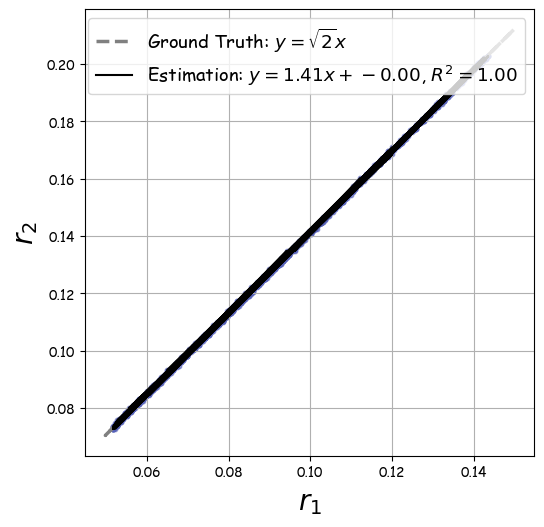

In [37]:

def plot_data_with_fit(radii_data, base_path):
    """
    绘制小圆半径与大圆半径的散点图，并进行拟合，画出拟合线及y = np.sqrt(2) * x的灰色虚线。
    """
    # 提取小圆半径和大圆半径
    x = radii_data[:, 0]  # 小圆半径
    y = radii_data[:, 1]  # 大圆半径

    # 添加轻微的抖动
    jitter_strength = 0  
    x_jittered = x + np.random.uniform(-jitter_strength, jitter_strength, size=x.shape)
    y_jittered = y + np.random.uniform(-jitter_strength, jitter_strength, size=y.shape)
    x_min, x_max = np.percentile(x, [2.5, 97.5])
    y_min, y_max = np.percentile(y, [2.5, 97.5])
    mask = (x_jittered >= x_min) & (x_jittered <= x_max) & (y_jittered >= y_min) & (y_jittered <= y_max)

    # 筛选有效数据点
    x_jittered = x_jittered[mask].reshape(-1, 1)
    y_jittered = y_jittered[mask]
    # 使用线性回归拟合小圆半径和大圆半径的关系
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    y_ideal = np.sqrt(2) * x.reshape(-1, 1)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, y_pred)

    # 绘制散点图和拟合线
    plt.figure(figsize=(5.8, 5.8))
    colors = ['#5762b8']
    plt.scatter(x_jittered, y_jittered, c=colors[0], alpha=0.6, s=10)
    plt.plot(x, y_ideal, color='gray', linestyle='--', label=r'Ground Truth: $y = \sqrt{2}x$', linewidth=2.5)
    plt.plot(x_jittered, y_jittered, color='black', label=f"Estimation: $y={slope:.2f}x + {intercept:.2f}$, $R^2={r2:.2f}$")
    plt.xlabel("$r_1$",fontsize=20)
    plt.ylabel("$r_2$",fontsize=20)
    # plt.xticks([0.05,0.10, 0.15, 0.20,0.25])
    # plt.yticks([0.05,0.10, 0.15, 0.20,0.25])
    # plt.xlim(0,0.15)
    # plt.ylim(0,0.25)
    plt.legend(fontsize=13.2)
    plt.grid()
    
    # plt.tight_layout()

    # 保存为 PDF
    pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/example", "taskc_rule.pdf")
    plt.savefig(pdf_path)
    print(f"Scatter plot and fit saved to {pdf_path}")


if len(radii_data) > 0:
    plot_data_with_fit(radii_data, folder_path)  # 数据拟合和绘图

## Genvis

In [5]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

class UNet(nn.Module):
    def __init__(self, num_classes=3):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # 全局平均池化

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.global_pool(x)  # 全局平均池化
        x = torch.flatten(x, 1)  # 展平
        return x

# 加载模型
model_path = "/cpfs04/user/hanyujin/causal-dm/contrsastive_dp/model/circles_contrastive_ternary_UNet_100.pth"
model = UNet()
model.load_state_dict(torch.load(model_path))
model.eval()  # 设置为评估模式

# 检查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 图片预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整图片大小
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 图片目录和保存目录
image_dir = "/cpfs04/user/hanyujin/causal-dm/results/circles_two/vis/epoch_1600_1735102005.4964678"
save_dir = "/cpfs04/user/hanyujin/causal-dm/results/circles_two/vis/epoch_1600_1735102005.4964678_class1_100"

# 创建保存目录
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 获取所有图片文件（支持 PNG 和 JPG）
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
total_files = len(image_files)

# 遍历图片目录，并添加进度条
for filename in tqdm(image_files, desc="Processing images", unit="image"):
    try:
        # 读取图片
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')  # 确保图片是RGB格式
        image = transform(image).unsqueeze(0).to(device)  # 增加batch维度并移动到设备

        # 预测
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

        # 如果预测标签为1，保存图片
        if predicted_label == 1:
            save_path = os.path.join(save_dir, filename)
            Image.open(image_path).save(save_path)
            # print(f"Saved {filename} to {save_dir}")
    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("Prediction and saving completed.")

Processing images: 100%|██████████| 3001/3001 [00:21<00:00, 137.39image/s]

Prediction and saving completed.


In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# def find_circles(image, min_radius=5, max_radius=50):
#     """
#     使用Hough圆变换检测图像中的圆，并返回检测到的圆的半径。
#     """
#     # 将图像转换为灰度图
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # 使用Hough圆变换检测圆
#     circles = cv2.HoughCircles(
#         gray,
#         cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
#         param1=50, param2=30, minRadius=min_radius, maxRadius=max_radius
#     )

#     # 如果检测到圆，返回圆的半径
#     if circles is not None:
#         circles = np.round(circles[0, :]).astype("int")
#         return [r for (x, y, r) in circles]  # 只返回半径
#     return []

def find_circles(image, image_size):
    """
    使用颜色范围检测图像中的圆，并返回检测到的圆的半径（归一化）。
    :param image: 输入的图像
    :param image_size: 图片尺寸，用于归一化处理
    :return: 检测到的圆的归一化半径列表
    """
    # 转换为HSV颜色空间
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 定义颜色范围（包括黄色、红色、蓝色、紫色和黑色）
    lower_yellow = np.array([20, 50, 100])  
    upper_yellow = np.array([40, 255, 255])

    lower_red1 = np.array([0, 30, 100])   
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 30, 100]) 
    upper_red2 = np.array([180, 255, 255])

    lower_blue = np.array([90, 50, 20])  
    upper_blue = np.array([130, 255, 255])

    lower_purple = np.array([130, 50, 20])  
    upper_purple = np.array([160, 255, 255])

    lower_black = np.array([0, 0, 0])  
    upper_black = np.array([180, 255, 50])  

    # 创建颜色掩码
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    black_mask = cv2.inRange(hsv, lower_black, upper_black)

    # 合并所有颜色掩码
    mask = yellow_mask | red_mask1 | red_mask2 | blue_mask | purple_mask | black_mask

    # 寻找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 存储圆的信息
    circles = []

    for contour in contours:
        # 使用最小外接圆计算圆的半径和中心
        (x, y), radius = cv2.minEnclosingCircle(contour)
        radius = int(radius)

        # 判断是否为有效的圆（半径范围符合条件）
        if radius > 5:  # 最小半径限制
            circles.append(radius)

    # 归一化半径
    normalized_radii = [r / image_size for r in circles]

    return normalized_radii


def process_images(base_path, target_size=128):
    """
    遍历文件夹中的图片，计算每张图片中大圆和小圆的半径。
    """
    folder_path = base_path  # + '/images'
    failed_images = []  # 存储处理失败的图片
    radii_data = []  # 存储小圆半径和大圆半径的对应数据 (小圆半径, 大圆半径)
    labels = []  # 存储数据点的标签 (x=y: 0, x!=y: 1)
    error_case_images = []  # 存储 error case 的图片id

    # 遍历文件夹中的图片
    for filename in tqdm(sorted(os.listdir(folder_path)), desc="Processing Images"):
        if not filename.endswith(".png"):  # 忽略非 PNG 文件
            continue

        image_path = os.path.join(folder_path, filename)

        # 读取图片并调整大小
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {filename}")
            failed_images.append(filename)
            continue
        image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)

        # 检测图像中的圆
        radii = find_circles(image, image_size=target_size)

        # 如果检测到的圆少于2个，认为检测失败
        if len(radii) < 2:
            failed_images.append(filename)
            continue

        # 假设第一个圆为小圆，第二个圆为大圆
        small_radius, large_radius = sorted(radii)[:2]  # 取前两个圆，排序后赋值
        # if small_radius <=0 or large_radius >=0.3:
        #     failed_images.append(filename)
        #     continue
        if large_radius > small_radius and large_radius/small_radius <3.65:
            x = small_radius
            y = large_radius
            radii_data.append((x, y,np.abs(y/x-np.sqrt(2))))
            is_error_case = abs(x - y) < 1e-6
            labels.append(0 if is_error_case else 1)  # 0 代表 x=y, 1 代表 x!=y
            if is_error_case:
                error_case_images.append(filename)

    # 保存 `failed_images` 到文本文件
    if failed_images:
        with open(os.path.join(folder_path, "failed_images.txt"), "w") as f:
            for item in failed_images:
                f.write(item + "\n")
    # 保存 `error_case_images` 到文本文件
    if error_case_images:
        with open(os.path.join(folder_path, "error_case_images.txt"), "w") as f:
            for item in error_case_images:
                f.write(item + "\n")
    # 返回有效数据
    return np.array(radii_data), labels, len(failed_images), len(error_case_images)
# 主程序
folder_path =  "/cpfs04/user/hanyujin/causal-dm/results/circles_two/vis/merge_epoch_1600"
# folder_path = "/cpfs04/user/hanyujin/causal-dm/results/circles_contrastive_ternary_cfg7/vis/merge_epoch_1600"
# folder_path =  "/cpfs04/user/hanyujin/causal-dm/results/circles_two/vis/epoch_1600_1735102005.4964678_class1_100"  # 这里填写你的文件夹路径
radii_data, labels, fail_count, error_count = process_images(folder_path, target_size =128)  # 数据处理
print(f"Failed images: {fail_count}")
print(f"Error case images: {error_count}")

Processing Images:   2%|▏         | 101/6004 [00:00<00:11, 504.40it/s]

Processing Images: 100%|██████████| 6004/6004 [00:12<00:00, 488.10it/s]

Failed images: 4784
Error case images: 0


In [45]:
all_points = []
colors = ['#5762b8']
# x = coordinates[:, 0]
# y = coordinates[:, 1]
# for x,y in (coordinates):
#     # 提取有效点
#     valid_points = (x,y)#[p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
#     if valid_points:
#         all_points.extend(valid_points)
count = fail_count = 0
for x, y,_ in radii_data:
    # 确定x所在区间的索引（0~9）
    idx = int(np.sqrt(2)*x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    # print(x,y,idx,lower,upper )
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1
    else:
        fail_count += 1
        # print(x,y,idx,lower,upper,lower <= y < upper)

# 计算占比
percentage = count / len(radii_data)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：49.27%


All Points: 0
Filtered Ratios: 1111
Max Ratio: 2.0302308820713497
Min Ratio: 0.002448856490742113
Bias Error: 0.20938150226972788
Variance Error: 0.026012121078129613
Sum Error: 0.2353936233478575


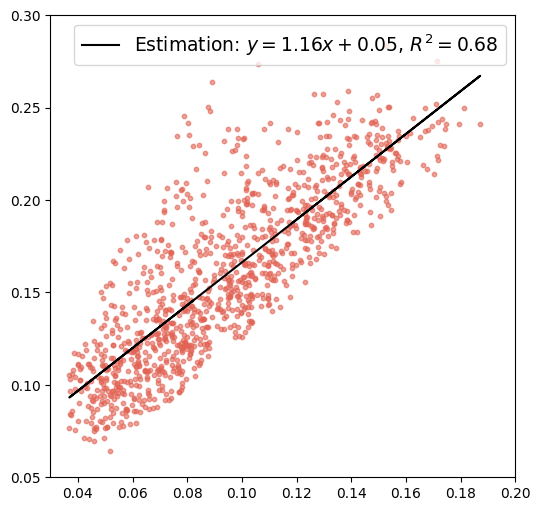

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/example/taskc_rule_gen_10000.pdf


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages

def plot_scatter(data, labels, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 提取所有点的 x 和 y 坐标
        x_all = data[:, 0]
        y_all = data[:, 1]
        ratios = data[:, 2]
        labels = np.array(labels)
        
        # 抖动强度（越小越轻微）
        jitter_strength = 0.01
        x_all = x_all + np.random.uniform(-jitter_strength, jitter_strength, size=x_all.shape)
        y_all = y_all + np.random.uniform(-jitter_strength, jitter_strength, size=y_all.shape)

        # 计算每个点的 |y/x| 比率
        ratio_all = np.abs(y_all / x_all)

        # 计算 |y/x| 的 2.5% 和 97.5% 百分位数
        ratio_low, ratio_high = np.percentile(ratio_all, [2.5, 97.5])

        # 筛选出 |y/x| 在 2.5% 和 97.5% 百分位数区间内的点
        mask = (ratio_low <= ratio_all) & (ratio_all <= ratio_high)
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered, y_filtered, c=color, alpha=0.6, s=10)

        # 打印比率的统计信息

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        print("All Points:", len(all_points))
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        print(f"Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) +np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        # print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2)))))}")

        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局
        plt.legend(fontsize=13.5)
        plt.xlim(0.03, 0.2)
        plt.ylim(0.05, 0.3)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")

# 例如，输出文件路径
output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/example/taskc_rule_gen_10000.pdf"

# 假设 `radii_data` 和 `labels` 已定义并且非空
if len(radii_data) > 0:
    plot_scatter(radii_data, labels, output_pdf_path)  # 数据拟合和绘图


/tmp/ipykernel_4058513/4134642889.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0.05, 0.175], [np.sqrt(2)*0.05, np.sqrt(2)*0.175], 'k--', label='Ground Truth: $y = \sqrt{2}x$', color='gray', linewidth=2.5)


All Points: 0
Filtered Ratios: 236
Max Ratio: 2.085786437626905
Min Ratio: 0.002453104293571595
Bias Error: 0.15970000651470279
Variance Error: 0.025776862366804317
Sum Error: 0.14898320930110112
Mean Sqrt Variance Error: 0.025776862366804317


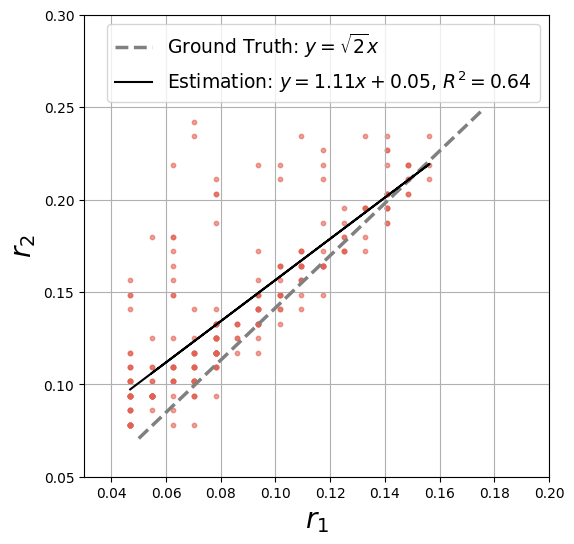

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/example/taskc_rule_gen_10000.pdf


In [32]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
def plot_scatter(data, labels, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 遍历所有 key 下的数值
        # for points in data.values():
        #     all_points.extend(points)  # 合并所有点

        # 提取所有点的 x 和 y 坐标
        x_all = data[:, 0]
        y_all = data[:, 1]
        ratios = data[:, 2]
        labels = np.array(labels)
        jitter_strength = 0.00 # 抖动强度（越小越轻微）
        x_all = x_all + np.random.uniform(-jitter_strength, jitter_strength, size=x_all.shape)
        y_all = y_all + np.random.uniform(-jitter_strength, jitter_strength, size=y_all.shape)
            
        # 绘制所有点的散点图
        

        # 绘制参考线
        plt.plot([0.05, 0.175], [np.sqrt(2)*0.05, np.sqrt(2)*0.175], 'k--', label='Ground Truth: $y = \sqrt{2}x$', color='gray', linewidth=2.5)
        plt.xlabel(r'$r_1$', fontsize=20)
        plt.ylabel(r'$r_2$', fontsize=20)
        plt.grid(True)
        # plt.axis('equal')

        # 计算 x 和 y 的 2.5% 和 97.5% 百分位数
        x_low, x_high = np.percentile(x_all, [2.5, 97.5])
        y_low, y_high = np.percentile(y_all, [2.5, 97.5])

        # 筛选在 95% 区间内的点
        mask = (x_low <= x_all) & (x_all <= x_high) & (y_low <= y_all) & (y_all <= y_high) #& ~( (x_low >= 0.06) & (y_all <= 0.20))
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered, y_filtered, c=color, alpha=0.6, s=10)

        # 打印比率的统计信息


        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        print("All Points:", len(all_points))
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        # print(f"Bias Error: {np.sqrt(intercept**2+(slope-1)**2)}")
        print(f"Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) +np.sqrt(intercept**2+(slope-1)**2)}")
        print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2))))}")
       
        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局
        plt.legend(fontsize=13.5)
        plt.xlim(0.03,0.2)
        plt.ylim(0.05,0.3)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")
# 0.16 0.27
output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/example/taskc_rule_gen_10000.pdf"  
# output_pdf_path =  "/cpfs04/user/hanyujin/causal-dm/example/taskc_rule_contrastive_epoch_1000_cfg3_classmodel015000.pdf"  
if len(radii_data) > 0:
    plot_scatter(radii_data, labels, output_pdf_path )  # 数据拟合和绘图

## Gen Case

Processing Images: 100%|██████████| 8/8 [00:00<00:00, 85.38it/s]


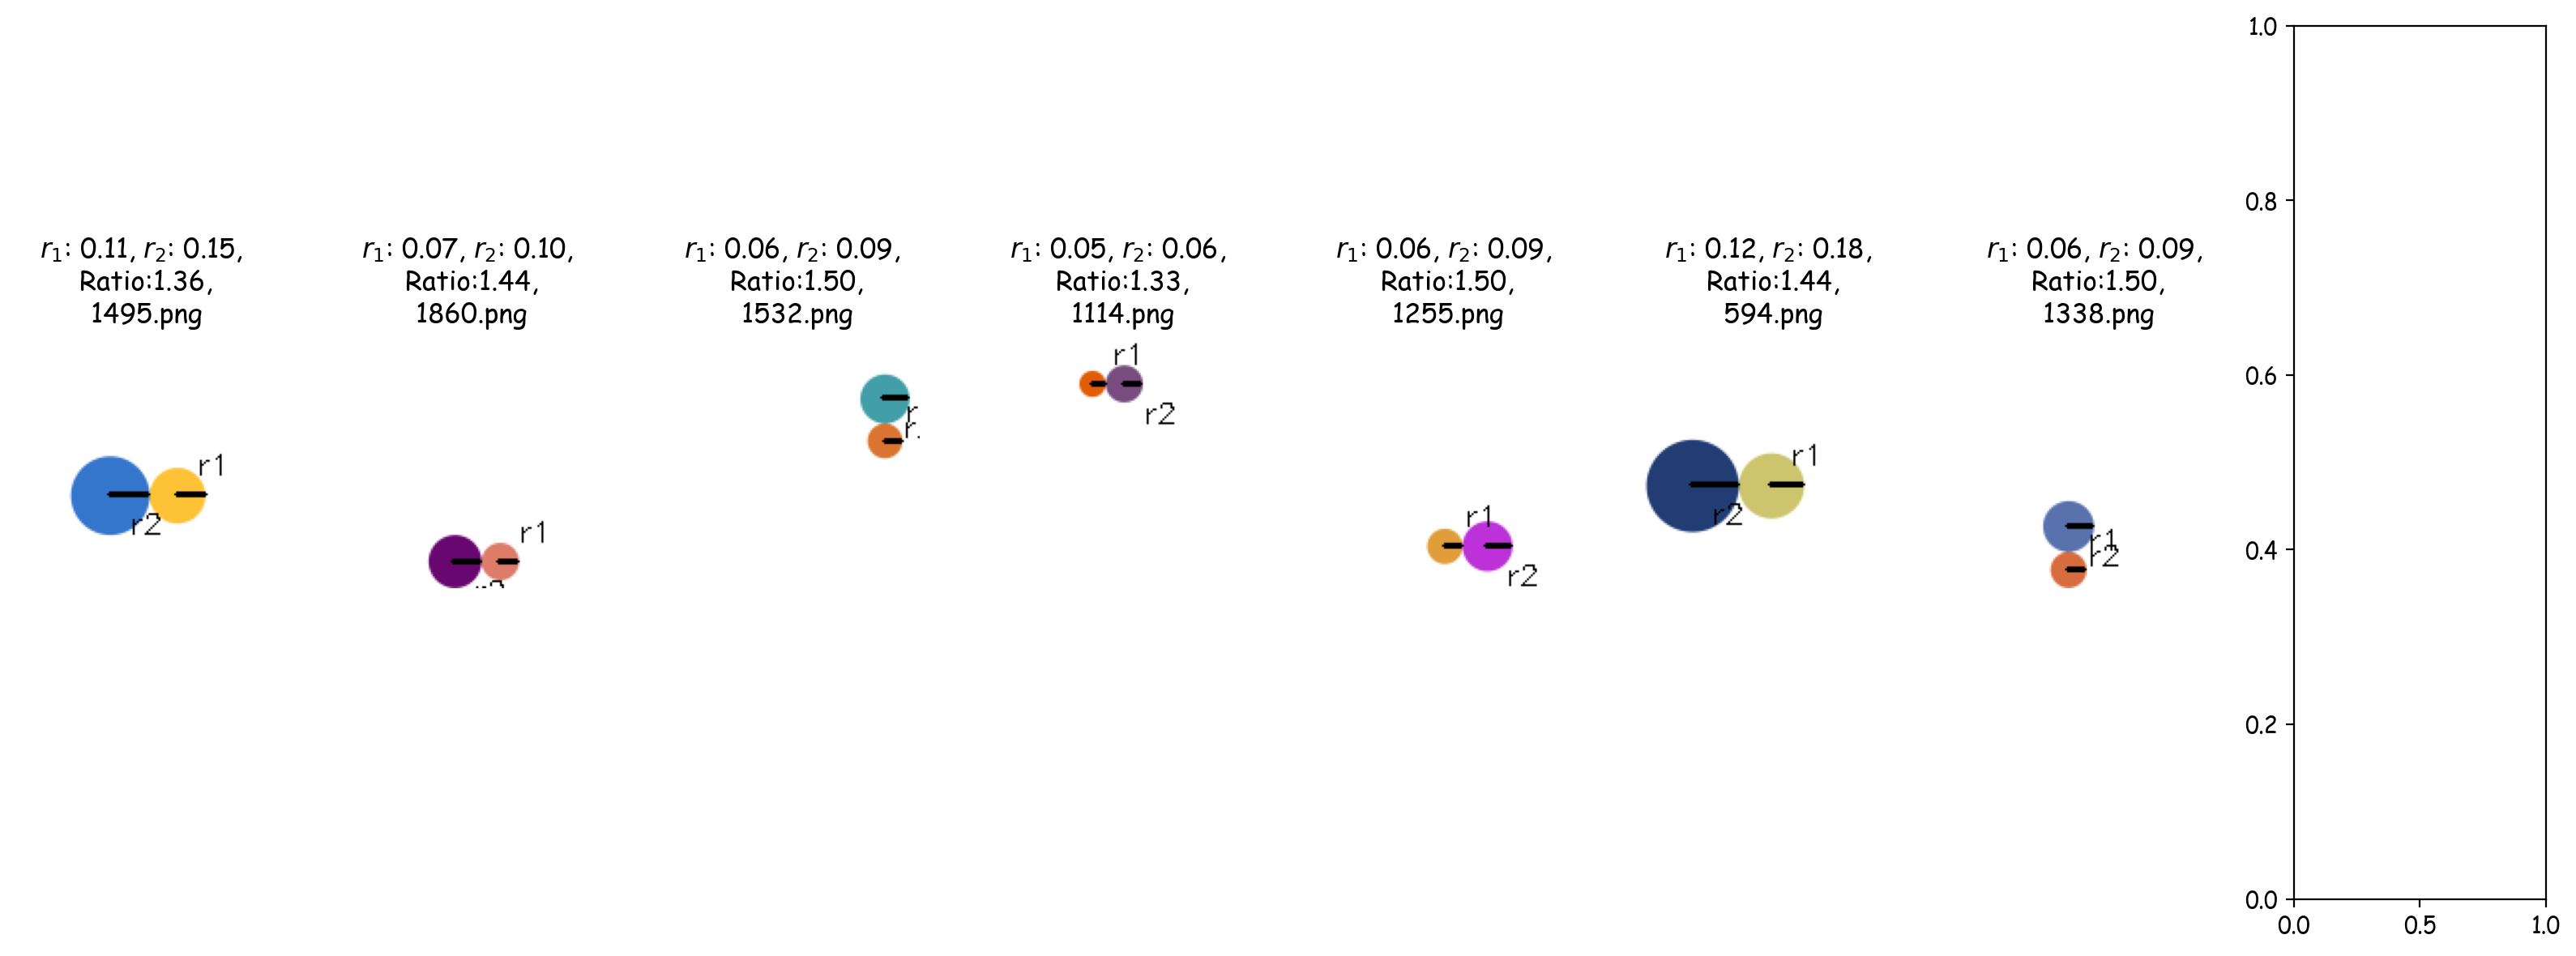

The Images is Saved to : /cpfs04/user/hanyujin/causal-dm/example/taskc_rule_case_train.pdf
Failed images: 1
Error case images: 0


In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from matplotlib.backends.backend_pdf import PdfPages

def find_circles(image, image_size):
    """
    使用颜色范围检测图像中的圆，并返回检测到的圆的半径（归一化）。
    """
    # 转换为HSV颜色空间
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]  # 黄色系
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]  # 蓝绿色系

    # 转换为HSV颜色空间的上下界
    lower_yellow = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])  
    upper_yellow = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

    lower_blue = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])  
    upper_blue = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

    # 创建颜色掩码
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # 合并所有颜色掩码
    mask = yellow_mask | blue_mask
    # 定义颜色范围（包括黄色、红色、蓝色、紫色和黑色）
    
    # lower_yellow = np.array([20, 50, 100])  
    # upper_yellow = np.array([40, 255, 255])

    # lower_red1 = np.array([0, 30, 100])   
    # upper_red1 = np.array([10, 255, 255])
    # lower_red2 = np.array([170, 30, 100]) 
    # upper_red2 = np.array([180, 255, 255])

    # lower_blue = np.array([90, 50, 20])  
    # upper_blue = np.array([130, 255, 255])

    # lower_purple = np.array([130, 50, 20])  
    # upper_purple = np.array([160, 255, 255])

    # lower_black = np.array([0, 0, 0])  
    # upper_black = np.array([180, 255, 50])  

    # # 创建颜色掩码
    # yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    # red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    # blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    # purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    # black_mask = cv2.inRange(hsv, lower_black, upper_black)

    # # 合并所有颜色掩码
    # mask = yellow_mask | red_mask1 | red_mask2 | blue_mask | purple_mask | black_mask

    # 寻找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 存储圆的信息
    circles = []

    for contour in contours:
        # 使用最小外接圆计算圆的半径和中心
        (x, y), radius = cv2.minEnclosingCircle(contour)
        radius = int(radius)

        # 判断是否为有效的圆（半径范围符合条件）
        if radius > 5:  # 最小半径限制
            circles.append((x, y, radius))

    # 归一化半径
    normalized_circles = [(x,y,r / image_size) for x,y,r in circles]

    return normalized_circles

def process_images(base_path, num_images=8, target_size=128, store_path="output.pdf"):
    """
    遍历文件夹中的图片，计算每张图片中大圆和小圆的半径。并将处理后的图像保存到PDF中。
    """
    folder_path = base_path
    failed_images = []
    radii_data = []
    labels = []
    error_case_images = []

    # Load failed images from the text file
    failed_images_file = os.path.join(folder_path, "failed_images.txt")
    if os.path.exists(failed_images_file):
        with open(failed_images_file, "r") as f:
            failed_images = [line.strip() for line in f]
    
    # Filter out failed images
    all_images = [f for f in os.listdir(folder_path) if f.endswith(".png")]
    available_images = [f for f in all_images if f not in failed_images]

    # Randomly select images
    if len(available_images) < num_images:
        print(f"Warning: Only {len(available_images)} images available, while {num_images} were requested.")
        selected_images = available_images
    else:
        selected_images = random.sample(available_images, num_images)

    with PdfPages(store_path) as pdf:
        fig, axes = plt.subplots(1, len(selected_images), figsize=(8*2, 6),dpi=200)

        if len(selected_images) == 1:
          axes = [axes]
        
        for idx, filename in enumerate(tqdm(selected_images, desc="Processing Images")):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is None:
                 print(f"Failed to read image: {filename}")
                 failed_images.append(filename)
                 continue
            image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)
            
            # Find circles and sort
            circles = find_circles(image, image_size=target_size)
            if len(circles) < 2:
                failed_images.append(filename)
                continue
            
            # Sort based on the radius
            circles = sorted(circles, key=lambda c: c[2])[:2] # Sort based on normalized radius
            
            # small_radius, large_radius = sorted([r[2] for r in circles])
            (x1, y1, small_radius), (x2, y2, large_radius) = circles
            
            if large_radius > small_radius and large_radius / small_radius >np.sqrt(2)-0.1 and large_radius / small_radius < np.sqrt(2)+0.1 :
              radii_data.append((small_radius, large_radius, np.abs(large_radius/small_radius-np.sqrt(2))))
              is_error_case = abs(small_radius - large_radius) < 1e-6
              labels.append(0 if is_error_case else 1)
              if is_error_case:
                 error_case_images.append(filename)

              # Draw a line representing the radius of the small circle, with the center as the start point
              center1 = (int(x1), int(y1))
              end1 = (int(x1 + small_radius * target_size), int(y1)) # Radius is drawn horizontally to the right
              cv2.line(image, center1, end1, (0, 0, 0), 2) # Small circle radius, green
              
               # Draw a line representing the radius of the big circle, with the center as the start point
              center2 = (int(x2), int(y2))
              end2 = (int(x2 + large_radius * target_size), int(y2))  # Radius is drawn horizontally to the right
              cv2.line(image, center2, end2, (0, 0, 0), 2) # Large circle radius, blue

              # Add text labels
              cv2.putText(image, f"r1", (int(x1)+10, int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
              cv2.putText(image, f"r2", (int(x2)+10, int(y2)+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
              
              axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
              axes[idx].set_title(f"$r_1$: {small_radius:.2f}, $r_2$: {large_radius:.2f}, \n Ratio:{large_radius/small_radius:.2f},\n {filename}")
              axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        pdf.savefig(fig)
        plt.close()
        print(f"The Images is Saved to : {store_path}")
    return np.array(radii_data), labels, len(failed_images), len(error_case_images)


# 主程序
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/circles_two/images"  # 这里填写你的文件夹路径
store_path = "/cpfs04/user/hanyujin/causal-dm/example/taskc_rule_case_train.pdf"
radii_data, labels, fail_count, error_count = process_images(folder_path, num_images=8, target_size =128, store_path=store_path)  # 数据处理
# 332.png 1227.png 1203.png 1886.png 1398.png 1995.png 1872.png 1860.png
print(f"Failed images: {fail_count}")
print(f"Error case images: {error_count}")

Processing Images: 100%|██████████| 8/8 [00:00<00:00, 93.47it/s]


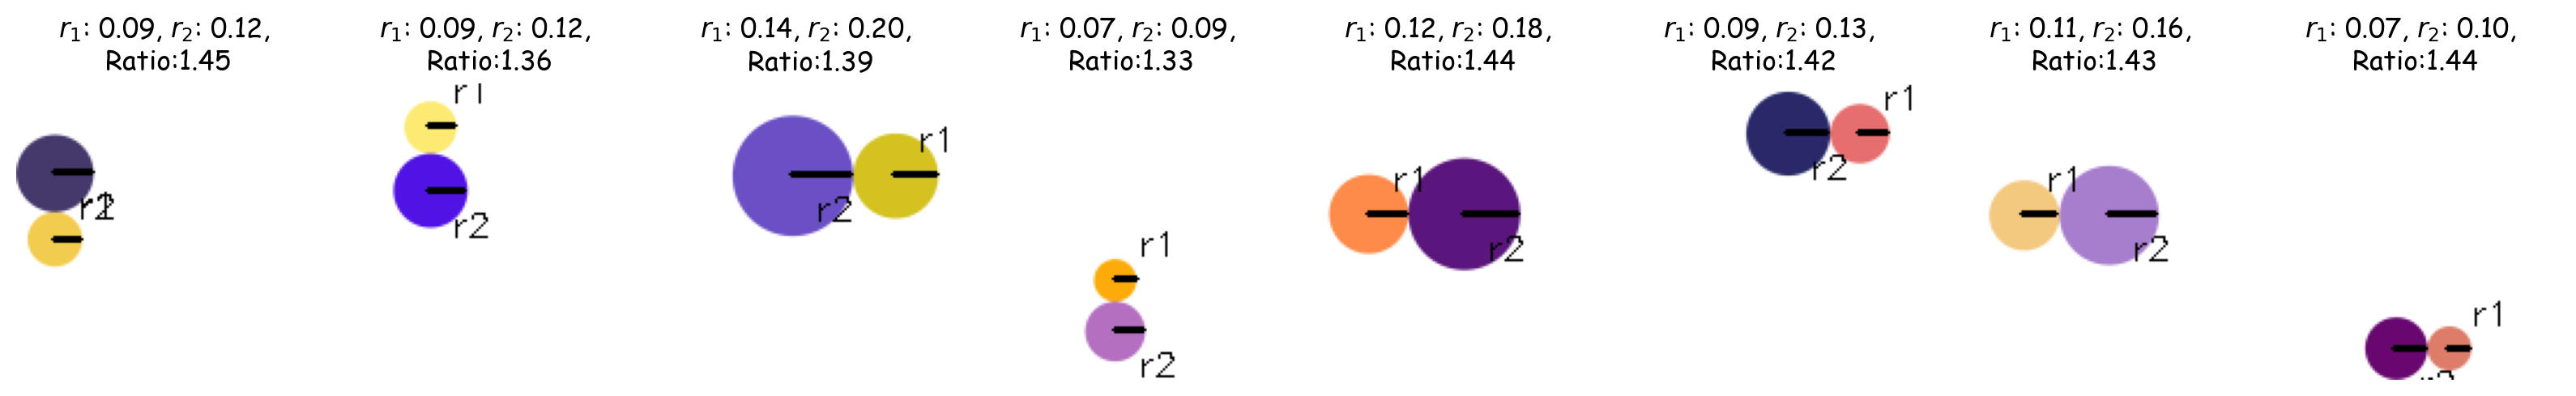

The Images is Saved to : /cpfs04/user/hanyujin/causal-dm/example/taskc_rule_case_train.pdf
Failed images: 0
Error case images: 0


In [30]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

def find_circles(image, image_size):
    """
    使用颜色范围检测图像中的圆，并返回检测到的圆的半径（归一化）。
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sun_hsv_range = [(0, 30), (100, 255), (200, 255)]  # 黄色系
    pole_hsv_range = [(90, 150), (100, 255), (100, 255)]  # 蓝绿色系

    # 转换为HSV颜色空间的上下界
    lower_yellow = np.array([sun_hsv_range[0][0], sun_hsv_range[1][0], sun_hsv_range[2][0]])  
    upper_yellow = np.array([sun_hsv_range[0][1], sun_hsv_range[1][1], sun_hsv_range[2][1]])

    lower_blue = np.array([pole_hsv_range[0][0], pole_hsv_range[1][0], pole_hsv_range[2][0]])  
    upper_blue = np.array([pole_hsv_range[0][1], pole_hsv_range[1][1], pole_hsv_range[2][1]])

    # 创建颜色掩码
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # 合并所有颜色掩码
    mask = yellow_mask | blue_mask

    # 寻找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circles = []

    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        radius = int(radius)

        if radius > 5:  # 最小半径限制
            circles.append((x, y, radius))

    normalized_circles = [(x,y,r / image_size) for x,y,r in circles]

    return normalized_circles

def process_images(base_path, image_list, target_size=128, store_path="output.pdf"):
    """
    遍历指定的图片列表，计算每张图片中大圆和小圆的半径，并将处理后的图像保存到PDF中。
    """
    folder_path = base_path
    failed_images = []
    radii_data = []
    labels = []
    error_case_images = []

    with PdfPages(store_path) as pdf:
        fig, axes = plt.subplots(1, len(image_list), figsize=(8*2, 6), dpi=200)

        if len(image_list) == 1:
            axes = [axes]

        for idx, filename in enumerate(tqdm(image_list, desc="Processing Images")):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {filename}")
                failed_images.append(filename)
                continue
            image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)

            # Find circles and sort
            circles = find_circles(image, image_size=target_size)
            if len(circles) < 2:
                failed_images.append(filename)
                continue

            circles = sorted(circles, key=lambda c: c[2])[:2]

            (x1, y1, small_radius), (x2, y2, large_radius) = circles

            if large_radius > small_radius and large_radius / small_radius > np.sqrt(2) - 0.1 and large_radius / small_radius < np.sqrt(2) + 0.1:
                radii_data.append((small_radius, large_radius, np.abs(large_radius / small_radius - np.sqrt(2))))
                is_error_case = abs(small_radius - large_radius) < 1e-6
                labels.append(0 if is_error_case else 1)
                if is_error_case:
                    error_case_images.append(filename)

                # Draw lines for small and large circle radii
                center1 = (int(x1), int(y1))
                end1 = (int(x1 + small_radius * target_size), int(y1))
                cv2.line(image, center1, end1, (0, 0, 0), 2) 

                center2 = (int(x2), int(y2))
                end2 = (int(x2 + large_radius * target_size), int(y2))
                cv2.line(image, center2, end2, (0, 0, 0), 2) 

                # Add text labels
                cv2.putText(image, f"r1", (int(x1)+10, int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
                cv2.putText(image, f"r2", (int(x2)+10, int(y2)+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

                axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[idx].set_title(f"$r_1$: {small_radius:.2f}, $r_2$: {large_radius:.2f}, \n Ratio:{large_radius/small_radius:.2f}")
                axes[idx].axis('off')

        plt.tight_layout()
        plt.show()
        pdf.savefig(fig)
        plt.close()
        print(f"The Images is Saved to : {store_path}")

    return np.array(radii_data), labels, len(failed_images), len(error_case_images)


# Main Program
folder_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/circles_two/images"  # Folder path
store_path = "/cpfs04/user/hanyujin/causal-dm/example/taskc_rule_case_train.pdf"

# List of specific images to process
image_list = ["332.png", "1227.png", "1203.png", "1886.png", "1398.png", "1995.png", "1872.png", "1860.png"]

radii_data, labels, fail_count, error_count = process_images(folder_path, image_list, target_size=128, store_path=store_path)
print(f"Failed images: {fail_count}")
print(f"Error case images: {error_count}")


# Task D

## training Vis

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os

def find_squares_in_image(image_path, image_size=32):
    """
    查找图片中的两个正方形并返回它们的边长，进行标准化处理。
    :param image_path: 图片文件路径
    :param image_size: 图片的尺寸
    :return: 上半部分和下半部分正方形的边长（l1, l2），标准化后的值
    """
    # 读取图像

    image = cv2.imread(image_path)
    height, width = image.shape[:2]  # height 是图像的高度，width 是图像的宽度
    # print(f"Actual image size - Width: {width}, Height: {height}")  # 打印实际尺寸
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转为灰度图像
    
    # 使用Canny边缘检测
    edges = cv2.Canny(image, 50, 150)

    # 查找轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    squares = []

    for contour in contours:
        # 逼近轮廓为多边形
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:  # 如果是四边形，考虑为正方形
            # 计算边长
            x, y, w, h = cv2.boundingRect(approx)
            square_size = max(w, h)  # 保证正方形的边长是最小边的长度
            squares.append((x, y, square_size))
    
    # 确保我们得到了两个正方形，一个在上半部分，一个在下半部分
    if len(squares) == 2:
        # 根据y坐标判断哪个正方形在上半部分，哪个在下半部分
        squares = sorted(squares, key=lambda x: x[1])  # 按y坐标排序
        l1 = squares[0][2]  # 上半部分的正方形边长
        l2 = squares[1][2]  # 下半部分的正方形边长

        # 打印原始边长
        # print(f"Original l1: {l1}, l2: {l2}")

        # 进行标准化，除以图片尺寸 image_size
        l1_normalized = l1 / image_size
        l2_normalized = l2 / image_size

        # 打印标准化后的边长
        # print(f"Normalized l1: {l1_normalized}, l2: {l2_normalized}")

        return l1_normalized, l2_normalized
    return None, None  # 如果没有找到两个正方形

def generate_squares_data(base_path, image_size=32, images_per_class=1000):
    """
    遍历文件夹中的图片，提取正方形边长并返回标准化数据。
    :param base_path: 图片所在的文件夹路径
    :param image_size: 图片尺寸
    :param images_per_class: 每个类别生成的图片数量
    :return: 正方形边长标准化数据
    """
    squares_data = []
    base_path = base_path + '/images'
    # 遍历文件夹中的图片
    for filename in os.listdir(base_path):
        if filename.endswith('.png'):  # 只处理PNG文件
            image_path = os.path.join(base_path, filename)

            # 查找图片中的正方形边长，并进行标准化
            l1, l2 = find_squares_in_image(image_path, image_size)
            if l1 is not None and l2 is not None:
                squares_data.append((l1, l2))

    return np.array(squares_data)

# 设置参数
base_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/square_two"
image_size = 1024

# 提取正方形数据并进行标准化
squares_data = generate_squares_data(base_path, image_size)


In [48]:
all_points = []
colors = ['#5762b8']
# x = coordinates[:, 0]
# y = coordinates[:, 1]
# for x,y in (coordinates):
#     # 提取有效点
#     valid_points = (x,y)#[p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
#     if valid_points:
#         all_points.extend(valid_points)
count = fail_count = 0
for x, y in squares_data:
    # 确定x所在区间的索引（0~9）
    idx = int(1.5*x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    # print(x,y,idx,lower,upper )
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1
    else:
        fail_count += 1
        # print(x,y,idx,lower,upper,lower <= y < upper)

# 计算占比
percentage = count / len(squares_data)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：98.63%


/tmp/ipykernel_2843439/1988971029.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0.1, 0.28], [0.15, 0.28*1.5], 'k--', label='Ground Truth: $y=1.5x$', color='gray',linewidth = 2.5)


Scatter plot and fit saved to /cpfs04/user/hanyujin/causal-dm/ar_ddpm/task2.pdf


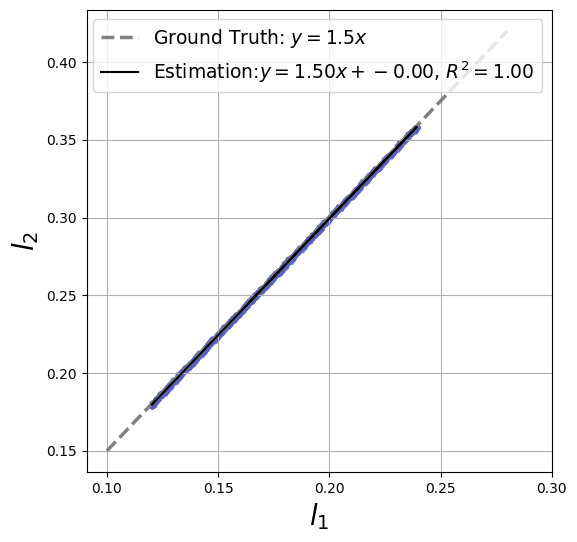

In [5]:

def plot_square_data(squares_data, base_path):
    """
    绘制正方形边长的散点图，并进行线性拟合。
    :param squares_data: 正方形边长数据
    :param base_path: 图片文件夹路径，用于保存图表
    """
    x = squares_data[:, 0]  # 上半部分正方形的边长 l1
    y = squares_data[:, 1]  # 下半部分正方形的边长 l2
    x_min, x_max = np.percentile(x, [5, 95])
    y_min, y_max = np.percentile(y, [5, 95])
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)

    # 筛选有效数据点
    x = x[mask]
    y= y[mask]
    # labels = labels[mask]
    # 使用线性回归模型拟合直线
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, y_pred)

    # 绘制散点图和拟合直线
    plt.figure(figsize=(6, 6))
    colors = ['#5762b8']
    plt.scatter(x, y, c=colors[0], alpha=0.6, s=10)
    plt.plot([0.1, 0.28], [0.15, 0.28*1.5], 'k--', label='Ground Truth: $y=1.5x$', color='gray',linewidth = 2.5) 
    plt.plot(x, y_pred, color='black', label=f"Estimation:$ y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$")
    plt.xticks([0.10,0.15,0.2, 0.25, 0.3])
    plt.xlabel('$l_1$',fontsize = 20)
    plt.ylabel('$l_2$',fontsize = 20)
    plt.legend(fontsize = 13.5)
    plt.grid(True)
    # plt.tight_layout()

    # 保存图表为PDF
    pdf_path = os.path.join("/cpfs04/user/hanyujin/causal-dm/ar_ddpm", "task2.pdf")
    plt.savefig(pdf_path)
    print(f"Scatter plot and fit saved to {pdf_path}")
# 绘制散点图并进行拟合
if len(squares_data) > 0:
    plot_square_data(squares_data, base_path)
else:
    print("No valid squares data found.")


## Genvis

In [22]:
import os
import shutil  # 用于删除目录
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

class UNet(nn.Module):
    def __init__(self, num_classes=3):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # 全局平均池化

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.global_pool(x)  # 全局平均池化
        x = torch.flatten(x, 1)  # 展平
        return x

# 加载模型
model_path = "//cpfs04/user/hanyujin/causal-dm/contrsastive_dp/model/square_contrastive_ternary_UNet_100.pth"
model = UNet()
model.load_state_dict(torch.load(model_path))
model.eval()  # 设置为评估模式

# 检查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 图片预处理
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整图片大小
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 图片目录和保存目录
image_dir = "/cpfs04/user/hanyujin/causal-dm/results/square_two/vis/epoch_1000_1735093891.1470206"
save_dir = "/cpfs04/user/hanyujin/causal-dm/results/square_two/vis/epoch_1000_1735093891.1470206_class1_100"

# 如果保存目录已存在，先删除原有数据
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)  # 删除整个目录
os.makedirs(save_dir)  # 重新创建目录

# 获取所有图片文件（支持 PNG 和 JPG）
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
total_files = len(image_files)

# 遍历图片目录，并添加进度条
for filename in tqdm(image_files, desc="Processing images", unit="image"):
    try:
        # 读取图片
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')  # 确保图片是RGB格式
        image = transform(image).unsqueeze(0).to(device)  # 增加batch维度并移动到设备

        # 预测
        with torch.no_grad():
            output = model(image)
            probabilities = torch.softmax(output, dim=1)  # 计算类别概率
            max_prob, predicted_label = torch.max(probabilities, 1)  # 获取最大概率及类别索引

        # 仅当类别为 1 且概率 > 0.7 时保存图片
        if predicted_label.item() == 1 and max_prob.item() > 0.7:
            save_path = os.path.join(save_dir, filename)
            Image.open(image_path).save(save_path)

    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("Prediction and saving completed.")


Processing images: 100%|██████████| 6000/6000 [00:54<00:00, 110.98image/s]

Prediction and saving completed.


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

def find_squares_in_image(image_path, image_size=128):
    """
    查找图片中的两个正方形并返回它们的边长，进行标准化处理。
    :param image_path: 图片文件路径
    :param image_size: 图片的尺寸
    :return: 上半部分和下半部分正方形的边长（l1, l2），标准化后的值
    """
    # 读取图像
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    
    original_image = image.copy()  # 保留原始图像，用于标记
    # image = image.filter(ImageFilter.GaussianBlur(radius=0.8)) 


    # 转换为HSV颜色空间，增强浅色正方形检测
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 定义颜色范围（黄色、红色、蓝色），包括浅色范围
 
    # 定义颜色范围（包括黄色、红色、蓝色、紫色和黑色）
    # 黄色范围
    lower_yellow = np.array([20, 50, 100])  
    upper_yellow = np.array([40, 255, 255])

    # 红色范围
    lower_red1 = np.array([0, 30, 100])   
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 30, 100]) 
    upper_red2 = np.array([180, 255, 255])

    # 蓝色范围（深蓝到浅蓝）
    lower_blue = np.array([90, 50, 20])  
    upper_blue = np.array([130, 255, 255])

    # 紫色范围
    lower_purple = np.array([130, 50, 20])  
    upper_purple = np.array([160, 255, 255])

    # 黑色范围
    lower_black = np.array([0, 0, 0])  
    upper_black = np.array([180, 255, 50])  

    # 创建颜色掩码
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    black_mask = cv2.inRange(hsv, lower_black, upper_black)

    # 合并所有颜色掩码
    mask = yellow_mask | red_mask1 | red_mask2 | blue_mask | purple_mask | black_mask

    # 添加灰度二值化结果，增强对非彩色区域的支持
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    mask = mask | binary


    # 寻找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 存储正方形的信息
    squares = []

    for contour in contours:
        # 计算轮廓的边界框
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)

        # 判断是否为正方形（宽高比接近1且面积足够大）
        if 0.9 <= aspect_ratio <= 1.1 and w > 10 and h > 10:
            squares.append((x, y, w, h))

    # 判断是否找到两个正方形
    if len(squares) != 2:
        return None, None  # 如果不是两个正方形，返回 None

    # 对正方形按y坐标排序（上侧正方形在前）
    squares = sorted(squares, key=lambda rect: rect[1])

    # 获取上侧和下侧正方形的边长
    l1 = squares[0][2]  # 上侧正方形边长
    l2 = squares[1][2]  # 下侧正方形边长

    # 进行标准化，除以图片尺寸 image_size
    l1_normalized = l1 / image_size
    l2_normalized = l2 / image_size
    # if l1_normalized <=0.15 and  l2_normalized >=0.2:
    #     return None, None

    # 在原始图像上标记正方形及其边长
    for (x, y, w, h) in squares:
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # 标记正方形边长
    cv2.putText(original_image, f"l1: {l1}", (squares[0][0] + l1 // 2, squares[0][1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    cv2.putText(original_image, f"l2: {l2}", (squares[1][0] + l2 // 2, squares[1][1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # 返回标准化边长和标记后的图片
    return l1_normalized, l2_normalized  # , original_image


def generate_squares_data(base_path, image_size=32, images_per_class=1000):
    """
    遍历文件夹中的图片，提取正方形边长并返回标准化数据。
    :param base_path: 图片所在的文件夹路径
    :param image_size: 图片尺寸
    :param images_per_class: 每个类别生成的图片数量
    :return: 正方形边长标准化数据
    """
    squares_data = []
    labels = []  # 保存数据标签
    failed_images = []
    error_case_images = []

    base_path = base_path  # + '/images'

    # 遍历文件夹中的图片
    for filename in tqdm(os.listdir(base_path), desc="Processing Images"):
        if filename.endswith('.png'):  # 只处理PNG文件
            image_path = os.path.join(base_path, filename)

            # 查找图片中的正方形边长，并进行标准化
            l1, l2 = find_squares_in_image(image_path, image_size)
            if l1 is not None and l2 is not None:
                squares_data.append((l1, l2,(l2/l1-1.5)))
                if l1 >= l2:
                    labels.append(0)
                    error_case_images.append(filename)  # 保存错误id
                else:
                    labels.append(1)
            else:
                failed_images.append(filename)

    # 保存 `failed_images` 到文本文件
    if failed_images:
        with open(os.path.join(base_path.replace('/images', ''), "failed_images.txt"), "w") as f:
            for item in failed_images:
                f.write(item + "\n")
    # 保存 `error_case_images` 到文本文件
    if error_case_images:
        with open(os.path.join(base_path.replace('/images', ''), "error_case_images.txt"), "w") as f:
            for item in error_case_images:
                f.write(item + "\n")

    return np.array(squares_data), np.array(labels), len(failed_images), len(error_case_images)


# 设置参数
base_path = "/cpfs04/user/hanyujin/causal-dm/results/square_two/vis/epoch_1000_1735093891.1470206"
# base_path =  "//cpfs04/user/hanyujin/causal-dm/AR_diff/results/square_two_parallelFalse_reverseFalse_patch8_dim480_depth6_mlpdepth3_noweightedlossTrue_trainsteps250000/generations/checkpoint.250000"
# "/cpfs04/user/hanyujin/causal-dm/results/square_two/vis/epoch_1000_1735093891.1470206_class1_100"
# "/cpfs04/user/hanyujin/causal-dm/results/square_two/vis_contrastive/epoch_1000_cfg10_classmodel015000.pt_1737341068.986422"
image_size = 128

# 提取正方形数据并进行标准化
squares_data, labels, fail_count, error_count = generate_squares_data(base_path, image_size)
print(f"Failed images: {fail_count}")
print(f"Error case images: {error_count}")


Processing Images:   1%|          | 53/6003 [00:00<00:11, 523.02it/s]

Processing Images: 100%|██████████| 6003/6003 [00:11<00:00, 503.65it/s]

Failed images: 4498
Error case images: 0


In [50]:
all_points = []
colors = ['#5762b8']
# x = coordinates[:, 0]
# y = coordinates[:, 1]
# for x,y in (coordinates):
#     # 提取有效点
#     valid_points = (x,y)#[p[0] for p in points if isinstance(p[0], (list, tuple, np.ndarray)) and len(p[0]) == 2]
#     if valid_points:
#         all_points.extend(valid_points)
count = fail_count = 0
for x, y,_ in squares_data:
    # 确定x所在区间的索引（0~9）
    idx = int(1.5*x * 20)
    
    # 计算对应区间的上下界
    lower = idx / 20
    upper = (idx + 1) / 20
    # print(x,y,idx,lower,upper )
    # 检查y是否在对应区间（左闭右开）
    if lower <= y < upper:
        count += 1
    else:
        fail_count += 1
        # print(x,y,idx,lower,upper,lower <= y < upper)

# 计算占比
percentage = count / len(squares_data)
print(f"满足条件的点占比：{percentage:.2%}")

满足条件的点占比：49.67%


/tmp/ipykernel_3823450/3263108457.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1*np.min(x_all), 1*np.max(x_all)], [1.5*np.min(x_all), 1.5*np.max(x_all)], 'k--', label='Ground Truth: $y=1.5x$', color='gray', linewidth=2.5)


Filtered Ratios: 1350
Max Ratio: 0.5
Min Ratio: -0.30000000000000004
Bias Error: 0.41067675984662594
Variance Error: 0.03046127461893128
Sum Error: 0.4411380344655572


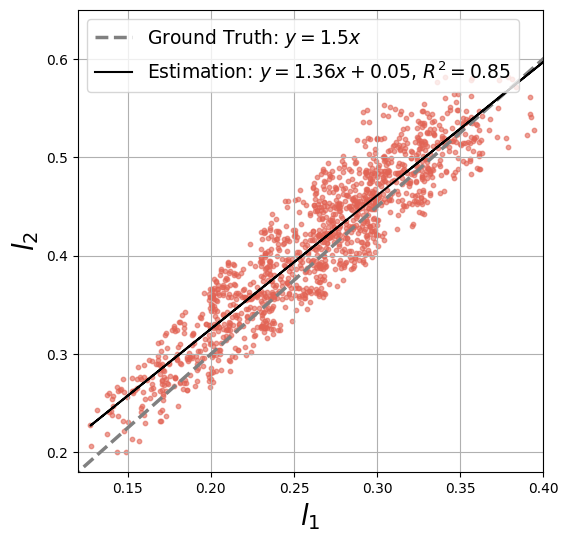

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/ar_ddpm/task2_ddpm.pdf


In [6]:
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter(data, labels, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 提取所有点的 x 和 y 坐标
        x_all = data[:, 0]
        y_all = data[:, 1]
        ratios = data[:, 2]
        labels = np.array(labels)
        
        jitter_strength = 0.02  # 抖动强度（越小越轻微）
        x_all = x_all + np.random.uniform(-jitter_strength, jitter_strength, size=x_all.shape)
        y_all = y_all + np.random.uniform(-jitter_strength, jitter_strength, size=y_all.shape)
        
        # 计算每个点的 |y/x| 比率
        ratio_all = np.abs(y_all / x_all)

        # 计算 |y/x| 的 2.5% 和 97.5% 百分位数
        ratio_low, ratio_high = np.percentile(ratio_all, [5, 95])
        plt.plot([1*np.min(x_all), 1*np.max(x_all)], [1.5*np.min(x_all), 1.5*np.max(x_all)], 'k--', label='Ground Truth: $y=1.5x$', color='gray', linewidth=2.5)
        # 筛选出 |y/x| 在 2.5% 和 97.5% 百分位数区间内的点
        mask = (ratio_low <= ratio_all) & (ratio_all <= ratio_high)
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered, y_filtered, c=color, alpha=0.6, s=10)

        # 打印比率的统计信息

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        print(f"Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) +np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        # print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2)))))}")

        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局
        plt.xlabel(r'$l_1$', fontsize=20)
        plt.ylabel(r'$l_2$', fontsize=20)
        plt.legend(fontsize=13.5)
        plt.grid(True)
        plt.xlim(0.12, 0.4)
        plt.ylim(0.12 * 1.5, 0.65)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")

# 输出文件路径
output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/ar_ddpm/task2_ddpm.pdf"

# 假设 `squares_data` 和 `labels` 已定义并且非空
if len(squares_data) > 0:
    plot_scatter(squares_data, labels, output_pdf_path)
else:
    print("No valid squares data found.")



All Points: 0
Filtered Ratios: 1373
Max Ratio: 0.6428571428571428
Min Ratio: -0.3181818181818181
Bias Error: 0.4364117140307077
Variance Error: 0.02956243408674781
Sum Error: 0.4320340003254986
Mean Sqrt Variance Error: 0.02956243408674781


/tmp/ipykernel_4058513/266620054.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0.15, 0.35], [1.5*0.15, 1.5*0.35], 'k--', label='Ground Truth: $y =1.5x$', color='gray', linewidth=2.5)


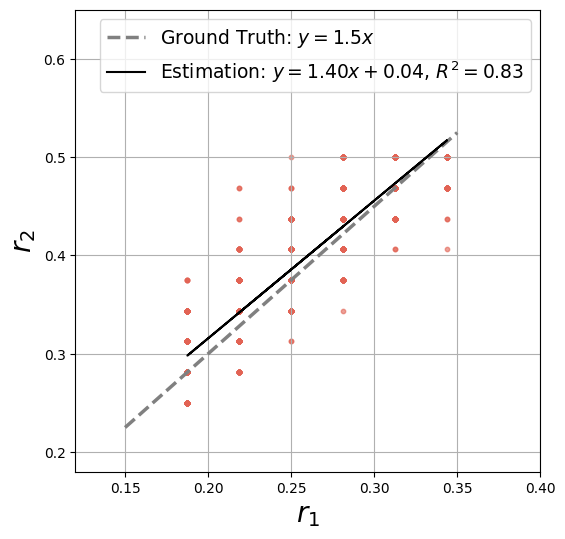

Scatter plot saved to /cpfs04/user/hanyujin/causal-dm/example/taskd_rule_gen_100000.pdf


In [26]:
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
def plot_scatter(data, labels, output_pdf_path):
    with PdfPages(output_pdf_path) as pdf:
        plt.figure(figsize=(6, 6))
        color = '#E26354'  # 统一的颜色
        all_points = []

        # 遍历所有 key 下的数值
        # for points in data.values():
        #     all_points.extend(points)  # 合并所有点

        # 提取所有点的 x 和 y 坐标
        x_all = data[:, 0]
        y_all = data[:, 1]
        ratios = data[:, 2]
        labels = np.array(labels)
        jitter_strength = 0.0 # 抖动强度（越小越轻微）
        x_all = x_all + np.random.uniform(-jitter_strength, jitter_strength, size=x_all.shape)
        y_all = y_all + np.random.uniform(-jitter_strength, jitter_strength, size=y_all.shape)
            
        # 绘制所有点的散点图
        

        # 绘制参考线
        plt.plot([0.15, 0.35], [1.5*0.15, 1.5*0.35], 'k--', label='Ground Truth: $y =1.5x$', color='gray', linewidth=2.5)
        plt.xlabel(r'$r_1$', fontsize=20)
        plt.ylabel(r'$r_2$', fontsize=20)
        plt.grid(True)
        # plt.axis('equal')

        # 计算 x 和 y 的 2.5% 和 97.5% 百分位数
        x_low, x_high = np.percentile(x_all, [2.5, 97.5])
        y_low, y_high = np.percentile(y_all, [2.5, 97.5])

        # 筛选在 95% 区间内的点
        mask = (x_low <= x_all) & (x_all <= x_high) & (y_low <= y_all) & (y_all <= y_high) & ~ ((x_all <= 0.16) & (0.25 <= y_all) )& ~ ((x_all <= 0.20) & (0.4 <= y_all) )& ~ ((x_all >= 0.30) & (0.4 >= y_all) )
        x_filtered = x_all[mask].reshape(-1, 1)
        y_filtered = y_all[mask]
        ratios = np.array(ratios)[mask]  # 筛选对应的比率
        plt.scatter(x_filtered, y_filtered, c=color, alpha=0.6, s=10)

        # 打印比率的统计信息
        # print("All Points:", len(all_points))
        # print("Filtered Ratios:", len(ratios))
        # print(f"Max Ratio: {np.max(ratios)}")
        # print(f"Variance Error: {np.var(ratios)}")
        # print(f"Mean Error: {np.mean(ratios)}")

        # 使用筛选后的点进行拟合
        lin_reg = LinearRegression()
        lin_reg.fit(x_filtered, y_filtered)
        y_pred = lin_reg.predict(x_filtered)
        r2 = r2_score(y_filtered, y_pred)
        slope = lin_reg.coef_[0]
        intercept = lin_reg.intercept_

        print("All Points:", len(all_points))
        print("Filtered Ratios:", len(ratios))
        print(f"Max Ratio: {np.max(ratios)}")
        print(f"Min Ratio: {np.min(ratios)}")
        # print(f"Bias Error: {np.sqrt(intercept**2+(slope-1)**2)}")
        print(f"Bias Error: {np.sqrt((slope-1)**2)+np.sqrt(intercept**2)}")
        print(f"Variance Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) }")
        print(f"Sum Error: {np.sqrt(np.mean((y_filtered - y_pred-np.mean(y_filtered - y_pred))**2)) +np.sqrt(intercept**2+(slope-1)**2)}")
        print(f"Mean Sqrt Variance Error: {(np.sqrt(np.mean(((y_filtered - y_pred) ** 2))))}")
       

        # 绘制拟合直线
        plt.plot(x_filtered, y_pred, color='black', 
                 label=f'Estimation: $y={slope:.2f}x+{intercept:.2f}$, $R^2={r2:.2f}$')

        # 设置图例和布局a
        plt.legend(fontsize=13.5)
        plt.xlim(0.12,0.4)
        plt.ylim(0.12*1.5,0.65)
        pdf.savefig()  # 保存当前图像到 PDF
        plt.show()
        plt.close()

    print(f"Scatter plot saved to {output_pdf_path}")

# output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/example/taskd_rule_gen_class1_100_0.7.pdf" 
output_pdf_path = "/cpfs04/user/hanyujin/causal-dm/example/taskd_rule_gen_100000.pdf"  
if len(squares_data) > 0:
    plot_scatter(squares_data, labels, output_pdf_path)
else:
    print("No valid squares data found.")

# 0.46 0.39

## Gen Case

Processing Images: 100%|██████████| 8/8 [00:00<00:00, 85.85it/s]


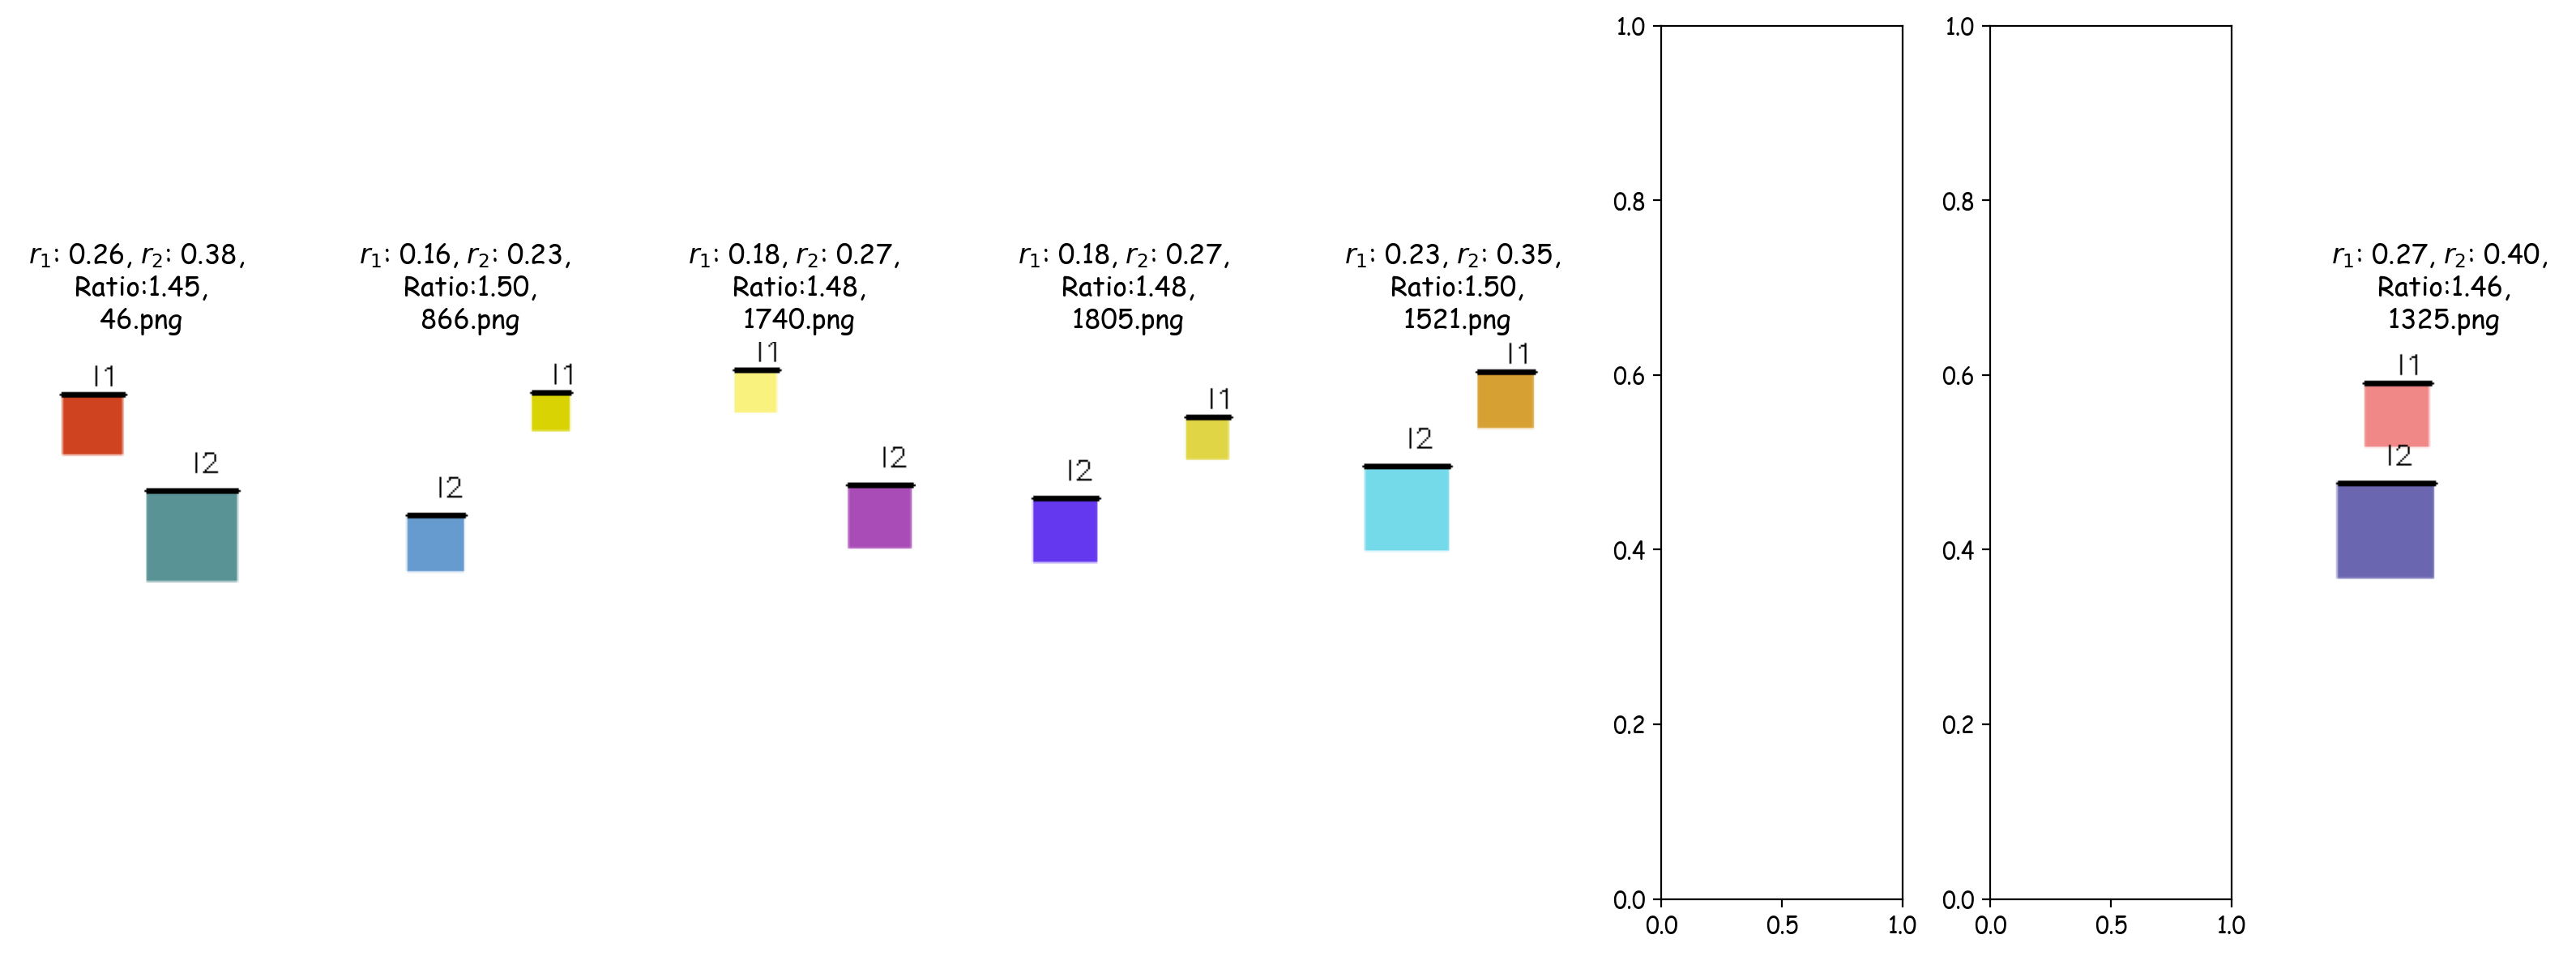

The images are saved to /cpfs04/user/hanyujin/causal-dm/example/taskd_gen_train.pdf
Failed images: 2
Error case images: 0


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
from matplotlib.backends.backend_pdf import PdfPages

def find_squares_in_image(image, image_size):
    """
    查找图片中的两个正方形并返回它们的边长，进行标准化处理。
    """
    original_image = image.copy()  # 保留原始图像，用于标记
    # image = image.filter(ImageFilter.GaussianBlur(radius=0.8)) 


    # 转换为HSV颜色空间，增强浅色正方形检测
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 定义颜色范围（黄色、红色、蓝色），包括浅色范围
 
    # 定义颜色范围（包括黄色、红色、蓝色、紫色和黑色）
    # 黄色范围
    lower_yellow = np.array([20, 50, 100])  
    upper_yellow = np.array([40, 255, 255])

    # 红色范围
    lower_red1 = np.array([0, 30, 100])   
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 30, 100]) 
    upper_red2 = np.array([180, 255, 255])

    # 蓝色范围（深蓝到浅蓝）
    lower_blue = np.array([90, 50, 20])  
    upper_blue = np.array([130, 255, 255])

    # 紫色范围
    lower_purple = np.array([130, 50, 20])  
    upper_purple = np.array([160, 255, 255])

    # 黑色范围
    lower_black = np.array([0, 0, 0])  
    upper_black = np.array([180, 255, 50])  

    # 创建颜色掩码
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    black_mask = cv2.inRange(hsv, lower_black, upper_black)

    # 合并所有颜色掩码
    mask = yellow_mask | red_mask1 | red_mask2 | blue_mask | purple_mask | black_mask

    # 添加灰度二值化结果，增强对非彩色区域的支持
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    mask = mask | binary


    # 寻找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 存储正方形的信息
    squares = []

    for contour in contours:
        # 计算轮廓的边界框
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)

        # 判断是否为正方形（宽高比接近1且面积足够大）
        if 0.9 <= aspect_ratio <= 1.1 and w > 10 and h > 10:
            squares.append((x, y, w, h))

    # 判断是否找到两个正方形
    if len(squares) != 2:
        return None, None, original_image  # 如果不是两个正方形，返回 None

    # 对正方形按y坐标排序（上侧正方形在前）
    squares = sorted(squares, key=lambda rect: rect[1])

    # 获取上侧和下侧正方形的边长
    l1 = squares[0][2]  # 上侧正方形边长
    l2 = squares[1][2]  # 下侧正方形边长

    # 进行标准化，除以图片尺寸 image_size
    l1_normalized = l1 / image_size
    l2_normalized = l2 / image_size
    # if l1_normalized <=0.15 and  l2_normalized >=0.2:
    #     return None, None, original_image

    # 在原始图像上标记正方形及其边长
    # for (x, y, w, h) in squares:
    #     cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    x1, y1, w1, h1 = squares[0]
    x2, y2, w2, h2 = squares[1]
     # Mark the sides of the squares
    cv2.line(original_image, (x1, y1), (x1 + w1, y1), (0, 0, 0), 2)  # Top side of the first square
    cv2.line(original_image, (x2, y2), (x2 + w2, y2), (0, 0, 0), 2)  # Top side of the second square

    # 标记正方形边长
    cv2.putText(original_image, f"l1", (squares[0][0] + w1 // 2, squares[0][1]-5 ),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.putText(original_image, f"l2", (squares[1][0] + w2 // 2, squares[1][1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # 返回标准化边长和标记后的图片
    return l1_normalized, l2_normalized, original_image

def process_images(base_path, num_images=8, target_size=128, store_path="output.pdf"):
    """
    遍历文件夹中的图片，计算每张图片中正方形的边长，并将处理后的图像保存到PDF中。
    """
    folder_path = base_path
    failed_images = []
    squares_data = []
    labels = []
    error_case_images = []

    # Load failed images from the text file
    failed_images_file = os.path.join(folder_path, "failed_images.txt")
    if os.path.exists(failed_images_file):
        with open(failed_images_file, "r") as f:
            failed_images = [line.strip() for line in f]
    
    # Filter out failed images
    all_images = [f for f in os.listdir(folder_path) if f.endswith(".png")]
    available_images = [f for f in all_images if f not in failed_images]

    # Randomly select images
    if len(available_images) < num_images:
        print(f"Warning: Only {len(available_images)} images available, while {num_images} were requested.")
        selected_images = available_images
    else:
        selected_images = random.sample(available_images, num_images)

    with PdfPages(store_path) as pdf:
         fig, axes = plt.subplots(1, len(selected_images), figsize=(8 * 2, 6), dpi=200)
         if len(selected_images) == 1:
            axes = [axes]
         
         for idx, filename in enumerate(tqdm(selected_images, desc="Processing Images")):
                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path)
                if image is None:
                  print(f"Failed to read image: {filename}")
                  failed_images.append(filename)
                  continue
                image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)
              
                l1, l2, marked_image = find_squares_in_image(image, image_size=target_size)
                if l1 is None or l2 is None:
                    failed_images.append(filename)
                    continue

                squares_data.append((l1, l2, (l2/l1-1.5)))
                if l1 >= l2:
                    labels.append(0)
                    error_case_images.append(filename)  # 保存错误id
                else:
                   labels.append(1)
                
                axes[idx].imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
                axes[idx].set_title(f"$r_1$: {l1:.2f}, $r_2$: {l2:.2f}, \n Ratio:{l2/l1:.2f}")
                axes[idx].axis('off')
         
         plt.tight_layout()
         plt.show()
         pdf.savefig(fig)
         plt.close()
         print(f"The images are saved to {store_path}")

    # Save `failed_images` and `error_case_images` to text file
    # if failed_images:
    #     with open(os.path.join(folder_path, "failed_images.txt"), "w") as f:
    #         for item in failed_images:
    #             f.write(item + "\n")
    # if error_case_images:
    #      with open(os.path.join(folder_path, "error_case_images.txt"), "w") as f:
    #         for item in error_case_images:
    #             f.write(item + "\n")

    return np.array(squares_data), labels, len(failed_images), len(error_case_images)


# 设置参数
base_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/square_two/images"
store_path = "/cpfs04/user/hanyujin/causal-dm/example/taskd_gen_train.pdf"
image_size = 128
# 提取正方形数据并进行标准化
squares_data, labels, fail_count, error_count = process_images(base_path, num_images=8, target_size = image_size, store_path=store_path)
print(f"Failed images: {fail_count}")
print(f"Error case images: {error_count}")

# 1405.png 1047.png,1718.png,1934.png 866.png 1521.png 1740.png 1805.png

Processing Images: 100%|██████████| 8/8 [00:00<00:00, 95.10it/s]


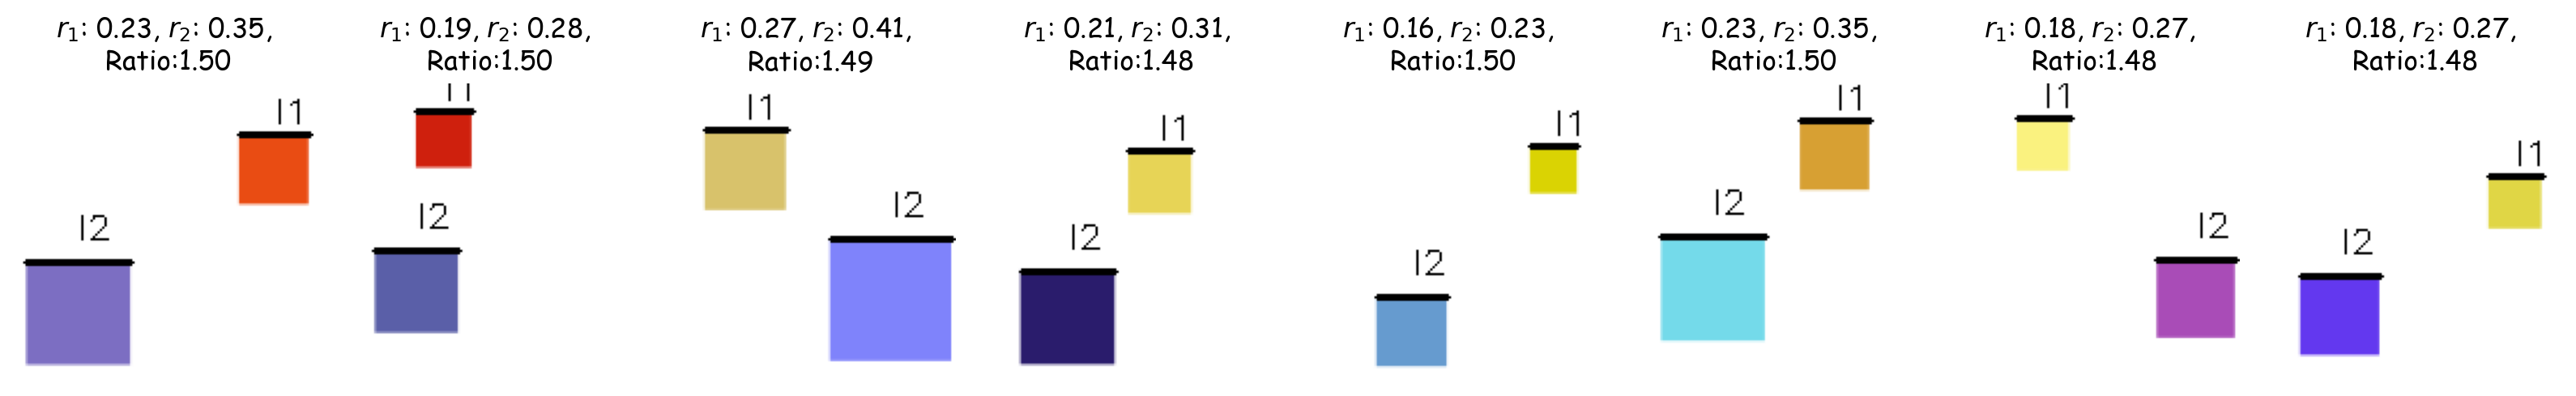

The images are saved to /cpfs04/user/hanyujin/causal-dm/example/taskd_gen_train.pdf


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

def find_squares_in_image(image, image_size):
    """
    查找图片中的两个正方形并返回它们的边长，进行标准化处理。
    """
    original_image = image.copy()  # 保留原始图像，用于标记

    # 转换为HSV颜色空间，增强浅色正方形检测
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 定义颜色范围（黄色、红色、蓝色），包括浅色范围
    lower_yellow = np.array([20, 50, 100])  
    upper_yellow = np.array([40, 255, 255])
    lower_red1 = np.array([0, 30, 100])   
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 30, 100]) 
    upper_red2 = np.array([180, 255, 255])
    lower_blue = np.array([90, 50, 20])  
    upper_blue = np.array([130, 255, 255])
    lower_purple = np.array([130, 50, 20])  
    upper_purple = np.array([160, 255, 255])
    lower_black = np.array([0, 0, 0])  
    upper_black = np.array([180, 255, 50])  

    # 创建颜色掩码
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    purple_mask = cv2.inRange(hsv, lower_purple, upper_purple)
    black_mask = cv2.inRange(hsv, lower_black, upper_black)

    # 合并所有颜色掩码
    mask = yellow_mask | red_mask1 | red_mask2 | blue_mask | purple_mask | black_mask

    # 添加灰度二值化结果，增强对非彩色区域的支持
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    mask = mask | binary

    # 寻找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 存储正方形的信息
    squares = []

    for contour in contours:
        # 计算轮廓的边界框
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)

        # 判断是否为正方形（宽高比接近1且面积足够大）
        if 0.9 <= aspect_ratio <= 1.1 and w > 10 and h > 10:
            squares.append((x, y, w, h))

    # 判断是否找到两个正方形
    if len(squares) != 2:
        return None, None, original_image  # 如果不是两个正方形，返回 None

    # 对正方形按y坐标排序（上侧正方形在前）
    squares = sorted(squares, key=lambda rect: rect[1])

    # 获取上侧和下侧正方形的边长
    l1 = squares[0][2]  # 上侧正方形边长
    l2 = squares[1][2]  # 下侧正方形边长

    # 进行标准化，除以图片尺寸 image_size
    l1_normalized = l1 / image_size
    l2_normalized = l2 / image_size

    # 在原始图像上标记正方形及其边长
    x1, y1, w1, h1 = squares[0]
    x2, y2, w2, h2 = squares[1]
    # Mark the sides of the squares
    cv2.line(original_image, (x1, y1), (x1 + w1, y1), (0, 0, 0), 2)  # Top side of the first square
    cv2.line(original_image, (x2, y2), (x2 + w2, y2), (0, 0, 0), 2)  # Top side of the second square

    # 标记正方形边长
    cv2.putText(original_image, f"l1", (squares[0][0] + w1 // 2, squares[0][1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.putText(original_image, f"l2", (squares[1][0] + w2 // 2, squares[1][1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # 返回标准化边长和标记后的图片
    return l1_normalized, l2_normalized, original_image


def process_images(base_path, selected_images, target_size=128, store_path="output.pdf"):
    """
    处理指定的图片，计算每张图片中正方形的边长，并将处理后的图像保存到PDF中。
    """
    squares_data = []
    labels = []

    with PdfPages(store_path) as pdf:
        fig, axes = plt.subplots(1, len(selected_images), figsize=(8 * 2, 6), dpi=200)
        if len(selected_images) == 1:
            axes = [axes]

        for idx, filename in enumerate(tqdm(selected_images, desc="Processing Images")):
            image_path = os.path.join(base_path, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {filename}")
                continue
            image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_AREA)

            l1, l2, marked_image = find_squares_in_image(image, image_size=target_size)
            if l1 is None or l2 is None:
                continue

            squares_data.append((l1, l2, (l2 / l1 - 1.5)))
            if l1 >= l2:
                labels.append(0)
            else:
                labels.append(1)

            axes[idx].imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f"$r_1$: {l1:.2f}, $r_2$: {l2:.2f}, \n Ratio:{l2 / l1:.2f}")
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()
        pdf.savefig(fig)
        plt.close()

    print(f"The images are saved to {store_path}")
    return np.array(squares_data), labels


# 设置参数
base_path = "/cpfs04/user/hanyujin/causal-dm/Integrated-Design-Diffusion-Model/datasets/square_two/images"
store_path = "/cpfs04/user/hanyujin/causal-dm/example/taskd_gen_train.pdf"
image_size = 128
selected_images = ["1405.png", "1047.png", "1718.png", "1934.png", "866.png", "1521.png", "1740.png", "1805.png"]

# 处理指定的图片并生成PDF
squares_data, labels = process_images(base_path, selected_images, target_size=image_size, store_path=store_path)


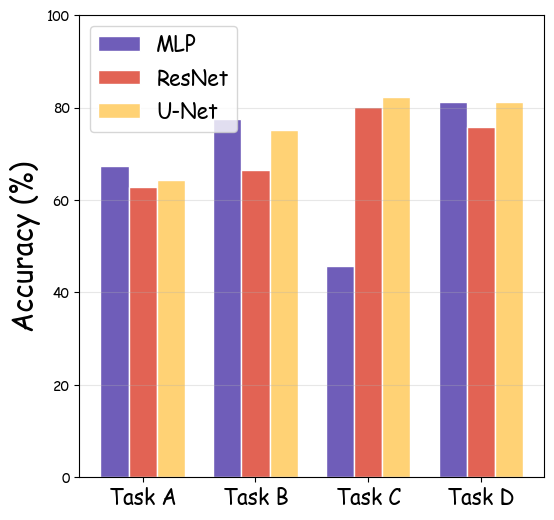

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import font_manager as fm

# 设置字体
comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")

# 数据设置
groups = ["Task A", "Task B", "Task C", "Task D"]
models = ['MLP', 'ResNet', 'U-Net']
colors = ["#6f5db9", '#E26354', "#ffd275"]

# 每个模型的数据
mlp = [67.47, 77.58, 45.83, 81.17]
resnet = [62.74, 66.50, 80.17, 75.83]
unet = [64.25, 75.13, 82.37, 81.17]

# 绘图参数
bar_width = 0.25
x = np.arange(len(groups))

# 创建画布
plt.figure(figsize=(6, 6), dpi=100)

# 绘制柱状图
plt.bar(x - bar_width, mlp, bar_width, color=colors[0], label=models[0], edgecolor='white')
plt.bar(x, resnet, bar_width, color=colors[1], label=models[1], edgecolor='white')
plt.bar(x + bar_width, unet, bar_width, color=colors[2], label=models[2], edgecolor='white')

# 轴标签与刻度
plt.ylabel('Accuracy (%)', fontsize=20)
plt.xticks(x, groups, fontsize=15)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

# 添加图例
plt.legend(fontsize=15)

# 保存为 PDF
save_path = "/cpfs04/user/hanyujin/causal-dm/example/test_acc.pdf"
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # 确保目录存在
plt.savefig(save_path, format='pdf', bbox_inches='tight')  # 保存 PDF

# 显示图像
plt.show()


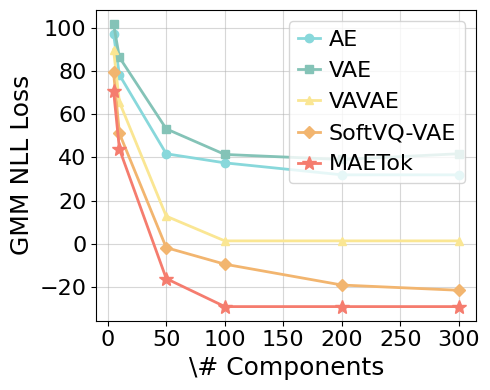

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import font_manager as fm

colors_plattest = [
    '#88d8db',
    '#84c3b7',
    '#fae693',
    '#f2b56f',
    '#f57c6e'
]

def teaser_gmm_plot():
    n_components = [5,10,50,100,200,300]


    # running exp71  - AE train: (300) [97.71112,78.49733, 41.6107,37.52429,31.06919,31.0691] val:[97.18526,78.2707,41.69613,37.48902,31.92514,31.92514]
    # exp77. - KL-VAE train:() [100.9184,85.20406,51.25858,39.13523,36.3303,39.53011] val:[101.81863,86.42886,53.24639,41.38463,39.04416,41.71183]
    # running 200 300 vavae - vavae train: (200,300) [89.80167,65.73468,12.3873,0.29481] val:[89.92623,65.64875,12.75888,1.29535]
    # exp93 - softvq () train:[79.90423,51.44699,-1.75101,-9.75161,-17.6874,-22.48021] val:[79.48209,51.1412,-1.82957,-9.50362,-19.17179,-21.60907]
    # running 200 300 exp99  - MAETok (200,300) train:[70.64417,43.84518,-15.57515,-28.25985] val:[70.99981,43.89427,-16.18076,-29.17179]
    # train vs. val



    exp71 = [97.18526,78.2707,41.69613,37.48902,31.92514,31.92514]
    exp77 = [101.81863,86.42886,53.24639,41.38463,39.04416,41.71183]
    expvavae = [89.92623,65.64875,12.75888,1.29535,1.29535,1.29535]
    # exp93 = [79.48209,51.1412,-1.82957,-9.50362,-19.17179,-21.60907]
    exp99 = [70.99981,43.89427,-16.18076,-29.17179,-29.17179,-29.17179]

    exp_to_label = {
        'exp71': 'AE',
        'exp72': 'VAE',
        'exp73': 'vavae',
        'exp79': 'softvqvae',
        'exp99': 'MAETok',
    }

    plt.figure(figsize=(5, 4))
    plt.plot(n_components, exp71, label='AE', color=colors_plattest[0], marker='o', linewidth=2)
    plt.plot(n_components, exp77, label='VAE', color=colors_plattest[1], marker='s', linewidth=2)
    plt.plot(n_components, expvavae, label='VAVAE', color=colors_plattest[2], marker='^', linewidth=2)
    # plt.plot(n_components, exp93, label='SoftVQ', color=colors_plattest[3], marker='D', linewidth=2)
    plt.plot(n_components, exp99, label='MAETok', color=colors_plattest[4], marker='*', linewidth=2, markersize=10)

    # Labels and title
    plt.xlabel('\# Components', fontsize=18)
    plt.ylabel('GMM NLL Loss', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Legend
    plt.legend(fontsize=16, handlelength=1.0, handletextpad=0.4, ncol=1, columnspacing=1.0)

    # Grid and layout
    plt.grid(alpha=0.5)
    plt.tight_layout()

    # Save and show
    plt.savefig('maetok_figures/gmm_losses.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

teaser_gmm_plot()

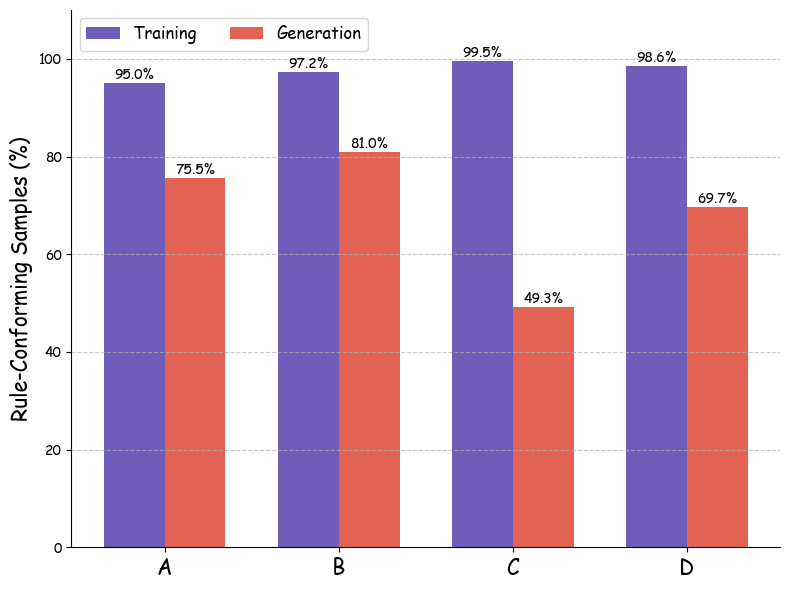

In [65]:
comic_sans_path = "/usr/share/fonts/truetype/msttcorefonts/comic.ttf"  # Linux 常见路径
if os.path.exists(comic_sans_path):
    fm.fontManager.addfont(comic_sans_path)
    plt.rcParams['font.family'] = 'Comic Sans MS'
else:
    print("Comic Sans MS font not found. Using default font.")
import matplotlib.pyplot as plt
import numpy as np

# 配置参数
colors = ["#6f5db9", '#E26354']
training = [95.02, 97.22, 99.51, 98.63]
generation = [75.53, 80.99, 49.27, 69.67]
Task = ["A", "B", "C", "D"]

# 设置画布
plt.figure(figsize=(8, 6), dpi=100)

# 生成柱状图位置
x = np.arange(len(Task))  # 任务标签位置
width = 0.35  # 柱子宽度

# 绘制双柱状图
bars1 = plt.bar(x - width/2, training, width, color=colors[0], label='Training')
bars2 = plt.bar(x + width/2, generation, width, color=colors[1], label='Generation')

# 添加数据标签
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# 美化图表
plt.xticks(x, Task, fontsize=15)
plt.ylabel("Rule-Conforming Samples (%)", fontsize=15)
plt.ylim(0, 110)  # 扩展y轴显示范围
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=12,  ncol=2)

# 添加辅助元素
# plt.title("Task Performance Comparison", fontsize=14, pad=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
# 保存为 PDF
save_path = "/cpfs04/user/hanyujin/causal-dm/example/discrete_samples.pdf"
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # 确保目录存在
plt.savefig(save_path, format='pdf', bbox_inches='tight')  # 保存 PDF
plt.show()